In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import json
import ast
from matplotlib.ticker import FuncFormatter
import glob
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
import scipy
from scipy.stats import entropy
from sklearn import manifold
from adjustText import adjust_text
from mpl_toolkits import mplot3d
import networkx as nx
import os.path as osp
from sklearn import tree
import graphviz
from sklearn.metrics import classification_report
from itertools import product, combinations
from joblib import Parallel, delayed


In [3]:
# use this to keep the cells wider, very nice on wide screens, set the percentage as you like it
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [116]:
#plt.rcParams.update(mpl.rcParamsDefault)  # for recovering from xkcd

#plt.style.use('seaborn-white')
#plt.style.use('seaborn-deep')
#plt.style.use('seaborn')
plt.style.use('seaborn-talk')
#plt.style.use('classic')
# for matplotlib xkcd I need to install new font without root, like this: 
#https://community.linuxmint.com/tutorial/view/29
# and then ivalidate cache like this: 
#https://stackoverflow.com/questions/19663986/getting-xkcd-plots-using-matplotlib/22812176#22812176
# or by deleting by: rm ~/.cache/matplotlib -r
# the font ttf file must be in ~/.fonts/fonts/truetype/humor-sans directory

# to recover from xkcd
#mpl.rcParams.update(saved_state)

# to save state and go to xkcd
#saved_state = mpl.rcParams.copy()
#plt.xkcd()
conf = {
    'font.size': 14.0,
    'axes.grid': True,
    'axes.axisbelow': True,
    'axes.edgecolor': 'black',
#    'axes.facecolor': '#E5E5EF',
#    'axes.facecolor': '#E0E0EF',
    'axes.labelcolor': 'black',
    'axes.titlesize': 15.6,
    'axes.labelsize': 'large',    
    'figure.figsize': (12, 7),
    'figure.titlesize': 'x-large',
    'grid.linewidth': 1.3,
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'legend.fontsize': 'large',
}

plt.rcParams.update(conf)


In [5]:
# cleaned data are good for user anylysis but not for anime analysis. For users, around 200k animelist records were discarded, over 30m records remainded.
from pandas.io.common import _NA_VALUES
na_values = _NA_VALUES - {'NULL', 'null', 'nan', 'NaN'}

animes = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('users_cleaned.csv', na_values=na_values, keep_default_na=False)
animelists = pd.read_csv('animelists_cleaned.csv', na_values=na_values, keep_default_na=False)

In [6]:
users['birth_date'] = pd.to_datetime(users['birth_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['join_date'] = pd.to_datetime(users['join_date'])
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'])
# renaming possibly array-like columns to end with -s
animes = animes.rename(columns={'genre': 'genres', 'studio': 'studios'})

In [7]:
# setting index for primary identifiers
animes = animes.set_index('anime_id')
users = users.set_index('username')


In [8]:
users['age'] = 2019 - users['birth_date'].dt.year   # fix this to be more robust and precise

In [9]:
animes.head()

title              title_english title_japanese  \
anime_id                                                                  
11013           Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
2104         Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   
5262       Shugo Chara!! Doki         Shugo Chara!! Doki    しゅごキャラ！！どきっ   
721             Princess Tutu              Princess Tutu      プリンセスチュチュ   
12365     Bakuman. 3rd Season                   Bakuman.          バクマン。   

                                         title_synonyms  \
anime_id                                                  
11013                                   Youko x Boku SS   
2104                               The Inland Sea Bride   
5262      Shugo Chara Ninenme, Shugo Chara! Second Year   
721                                                 NaN   
12365                                  Bakuman Season 3   

                                                  image_url type    source  \
anime_id                                                                     
11013     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
2104      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
5262      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
721       https://myanimelist.cdn-dena.com/images/anime/...   TV  Original   
12365     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   

          episodes           status  airing  ...           broadcast  \
anime_id                                     ...                       
11013           12  Finished Airing   False  ...  Fridays at Unknown   
2104            26  Finished Airing   False  ...             Unknown   
5262            51  Finished Airing   False  ...             Unknown   
721             38  Finished Airing   False  ...  Fridays at Unknown   
12365           25  Finished Airing   False  ...             Unknown   

                                                    related  \
anime_id                                                      
11013     {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104      {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
5262      {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
721       {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
12365     {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                                   producer          licensor  \
anime_id                                                                        
11013     Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
2104                      TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
5262                                        TV Tokyo, Sotsu               NaN   
721                      Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
12365                                         NHK, Shueisha               NaN   

                   studios                                    genres  \
anime_id                                                               
11013     David Production    Comedy, Supernatural, Romance, Shounen   
2104                 Gonzo  Comedy, Parody, Romance, School, Shounen   
5262             Satelight             Comedy, Magic, School, Shoujo   
721         Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
12365            J.C.Staff           Comedy, Drama, Romance, Shounen   

                                              opening_theme  \
anime_id                                                      
11013                                 ['"Nirvana" by MUCC']   
2104                     ['"Romantic summer" by SUN&LUNAR']   
5262      ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   
721                  ['"Morning Grace" by Ritsuko Okazaki']   
12365     ['#1: "Moshimo no Hanashi (もしもの話)" by nano.RIP...   

                                               ending_theme  duration_min  

In [10]:
animelists.head()

username  anime_id  my_watched_episodes my_start_date my_finish_date  \
0  karthiga        21                  586    0000-00-00     0000-00-00   
1  karthiga        59                   26    0000-00-00     0000-00-00   
2  karthiga        74                   26    0000-00-00     0000-00-00   
3  karthiga       120                   26    0000-00-00     0000-00-00   
4  karthiga       178                   26    0000-00-00     0000-00-00   

   my_score  my_status  my_rewatching  my_rewatching_ep     my_last_updated  \
0         9          1            NaN                 0 2013-03-03 10:52:53   
1         7          2            NaN                 0 2013-03-10 13:54:51   
2         7          2            NaN                 0 2013-04-27 16:43:35   
3         7          2            NaN                 0 2013-03-03 10:53:57   
4         7          2            0.0                 0 2013-03-27 15:59:13   

  my_tags  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [11]:
users.head()

user_id  user_watching  user_completed  user_onhold  \
username                                                              
karthiga        2255153              3              49            1   
Damonashu         37326             45             195           27   
bskai            228342             25             414            2   
terune_uzumaki   327311              5               5            0   
Bas_G           5015094             35             114            6   

                user_dropped  user_plantowatch  user_days_spent_watching  \
username                                                                   
karthiga                   0                 0                 55.091667   
Damonashu                 25                59                 82.574306   
bskai                      5                11                159.483333   
terune_uzumaki             0                 0                 11.394444   
Bas_G                     20               175                 30.458333   

                gender             location birth_date  access_rank  \
username                                                              
karthiga        Female      Chennai, India  1990-04-29          NaN   
Damonashu         Male     Detroit,Michigan 1991-08-01          NaN   
bskai             Male      Nayarit, Mexico 1990-12-14          NaN   
terune_uzumaki  Female    Malaysia, Kuantan 1998-08-24          NaN   
Bas_G             Male  Nijmegen, Nederland 1999-10-24          NaN   

                join_date         last_online  stats_mean_score  \
username                                                          
karthiga       2013-03-03 2014-02-04 01:32:00              7.43   
Damonashu      2008-02-13 2017-07-10 06:52:54              6.15   
bskai          2009-08-31 2014-05-12 16:35:00              8.27   
terune_uzumaki 2010-05-10 2012-10-18 19:06:00              9.70   
Bas_G          2015-11-26 2018-05-10 20:53:37              7.86   

                stats_rewatched  stats_episodes  age  
username                                              
karthiga                    0.0            3391   29  
Damonashu                   6.0            4903   28  
bskai                       1.0            9701   29  
terune_uzumaki              6.0             697   21  
Bas_G                       0.0            1847   20

### comparison of all and active users
Active users are users with some ratings in last 3 months

In [12]:
# newest update date, reflects time of data gathering
now = animelists['my_last_updated'].max()
now

Timestamp('2018-05-22 07:49:06')

In [13]:
from dateutil.relativedelta import relativedelta
last_update = animelists.groupby('username')['my_last_updated'].max()
is_active = last_update > (now - relativedelta(months=3))
active_users = last_update[is_active].index

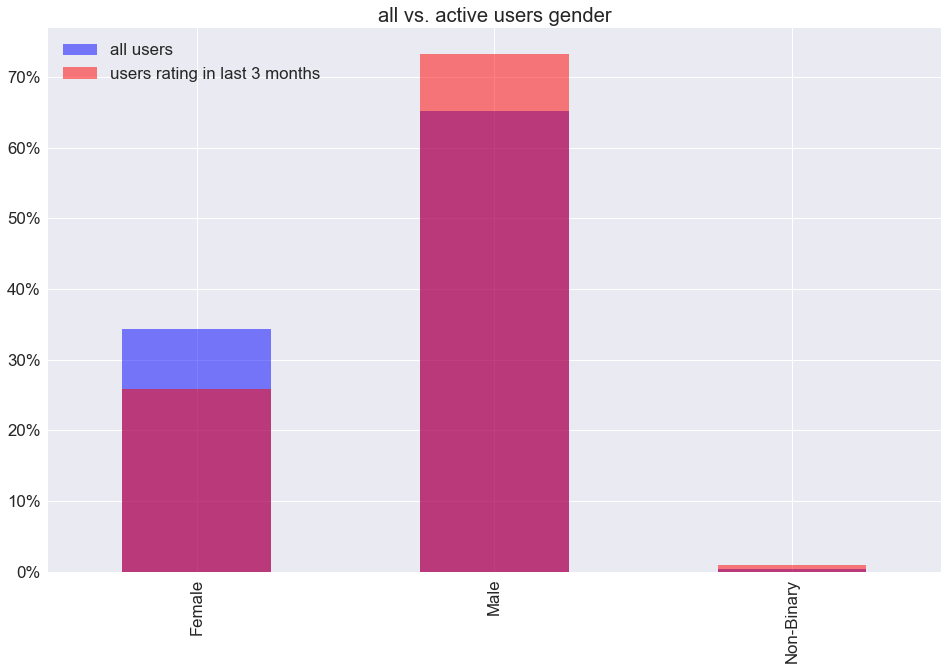

In [14]:
(users['gender'].value_counts() / users['gender'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users gender', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['gender'].value_counts() / users.loc[active_users]['gender'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

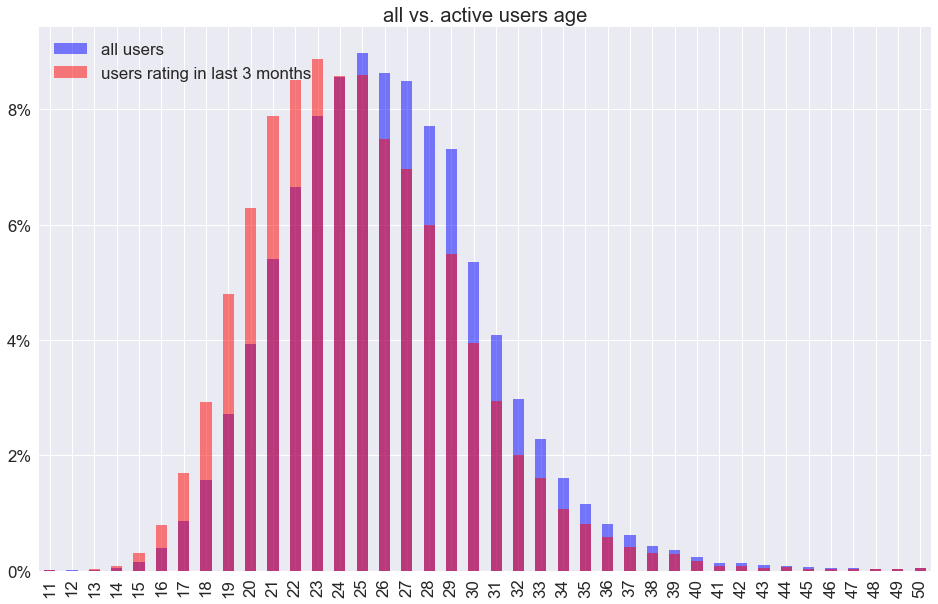

In [15]:
(users['age'].value_counts() / users['age'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users age', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['age'].value_counts() / users.loc[active_users]['age'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

### inspecing seen animes per all genres by age, gender etc.

In [16]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].str.replace(' ', '').str.split(',', expand=True).stack().reset_index(drop=True, level=1).to_frame(name='genre')
genres_arr = genres_arr[genres_arr['genre'] != '']
animes_genres = pd.merge(animes, genres_arr, how='inner', left_index=True, right_index=True)
genres = genres_arr['genre'].unique()

In [17]:
# the fastest and safest option (having separate dataframe per each genre is better than one big dataframe)
# todo: rewrite all queries using animelists_genres to access dict
def filter_by_genre(animelists, genre):
    print(genre)
    return genre, animelists[animelists['anime_id'].isin(genres_arr[genres_arr['genre'] == genre].index)]

res_lists = Parallel(n_jobs=16, backend='threading')(delayed(filter_by_genre)(animelists, genre) for genre in genres_arr['genre'].unique())
animelists_genres = {key: val for key, val in res_lists}

ComedySupernaturalRomance
ShounenParody
School
Magic

Shoujo
Drama
Fantasy
Kids
ActionMusic
SliceofLife

Josei


Harem
ShounenAi
Adventure
SuperPower
Sci-FiEcchi

Seinen
MartialArts
Game
Sports
Demons
HistoricalHorror

Mystery
Psychological
Vampire
Mecha
Military
Space
Samurai
Thriller
Hentai
Yaoi
ShoujoAi
PoliceCars

Dementia
Yuri


In [18]:
# semantics of my_status column
status = {
    'watching': 1,
    'completed': 2,
    'on hold': 3,
    'dropped': 4,
    'plan to watch': 6,
}

In [19]:
def calculate_genre_pairs(genre1, genre2):
    animelists_genre1 = animelists_genres[genre1]
    animelists_genre2 = animelists_genres[genre2]
    animelists_genre = pd.concat([animelists_genre1, animelists_genre2]).drop_duplicates(['username', 'anime_id']).reset_index(drop=True) # merging those two
    genres_name = genre1 + '_' + genre2
    print('processing genres pair: ', genres_name)
    completed = animelists_genre['my_status'] == status['completed']
    users['pair_completed_'+genres_name] = animelists_genre[completed].groupby('username')['anime_id'].count()
    dropped = animelists_genre['my_status'] == status['dropped']
    users['pair_dropped_'+genres_name] = animelists_genre[dropped].groupby('username')['anime_id'].count()
    rated = animelists_genre['my_score'] != 0
    users['pair_meanscore_'+genres_name] = animelists_genre[completed & rated].groupby('username')['my_score'].mean()
    # good score is 9 or higher
    rated8 = animelists_genre['my_score'] > 8
    users['pair_scoreabove8_'+genres_name] = animelists_genre[completed & rated8].groupby('username')['my_score'].count()
    # score is 10
    rated9 = animelists_genre['my_score'] > 9
    users['pair_scoreabove9_'+genres_name] = animelists_genre[completed & rated9].groupby('username')['my_score'].count()
    
if osp.exists('users_calculated.csv'):
    users = pd.read_csv('users_calculated.csv')
    users = users.set_index('username')
else:
    # handcrafted features
    for genre, animelists_genre in animelists_genres.items():
        print('processing genre: ', genre)
        completed = animelists_genre['my_status'] == status['completed']
        users['completed_'+genre] = animelists_genre[completed].groupby('username')['anime_id'].count()
        dropped = animelists_genre['my_status'] == status['dropped']
        users['dropped_'+genre] = animelists_genre[dropped].groupby('username')['anime_id'].count()
        rated = animelists_genre['my_score'] != 0
        users['meanscore_'+genre] = animelists_genre[completed & rated].groupby('username')['my_score'].mean()
        # good score is 9 or higher
        rated8 = animelists_genre['my_score'] > 8
        users['scoreabove8_'+genre] = animelists_genre[completed & rated8].groupby('username')['my_score'].count()
        # score is 10
        rated9 = animelists_genre['my_score'] > 9
        users['scoreabove9_'+genre] = animelists_genre[completed & rated9].groupby('username')['my_score'].count()

    # handcrafted features for OR of all pairs
    # without parallelization, it's annoyingly slow
    #Parallel(n_jobs=8, backend='threading')(delayed(calculate_genre_pairs)(genre1, genre2) for genre1, genre2 in combinations(animelists_genres.keys(), 2))  # generates all pairs
    for genre1, genre2 in combinations(animelists_genres.keys(), 2):
        calculate_genre_pairs(genre1, genre2)

    print('processing all animelists')
    completed = animelists['my_status'] == status['completed']
    dropped = animelists['my_status'] == status['dropped']
    rated = animelists['my_score'] != 0
    users['all_completed'] = animelists[completed].groupby('username')['anime_id'].count()
    users['all_dropped'] = animelists[dropped].groupby('username')['anime_id'].count()
    users['all_meanscore'] = animelists[completed & rated].groupby('username')['my_score'].mean()
    users['all_rated'] = animelists[completed & rated].groupby('username')['anime_id'].count()

    users.reset_index().to_csv('users_calculated.csv', index=False, sep=',', encoding='utf-8')

In [20]:
completed_columns = sorted(['completed_'+x for x in genres if x != ''])
above8_columns = sorted(['scoreabove8_'+x for x in genres if x != ''])
above9_columns = sorted(['scoreabove9_'+x for x in genres if x != ''])
mean_columns = sorted(['meanscore_'+x for x in genres if x != ''])


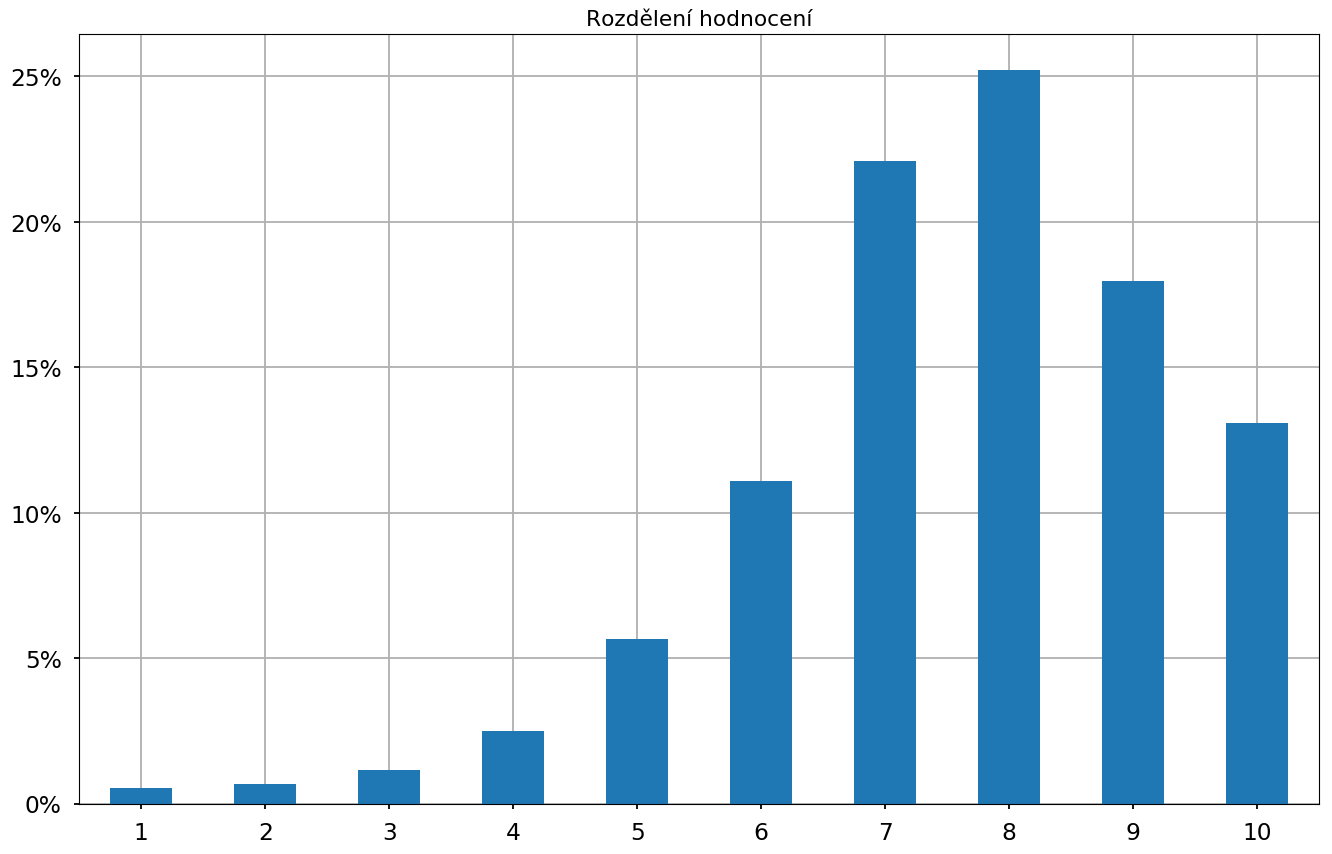

In [117]:
#showing score distribution
scores = animelists[animelists['my_score'] != 0]['my_score'].value_counts()
(scores / scores.sum()).sort_index().plot(kind='bar', figsize=(16, 10), title='Rozdělení hodnocení')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(rotation=0)
plt.savefig('graphs/uzivatele-hodnoceni.png', bbox_inches='tight')

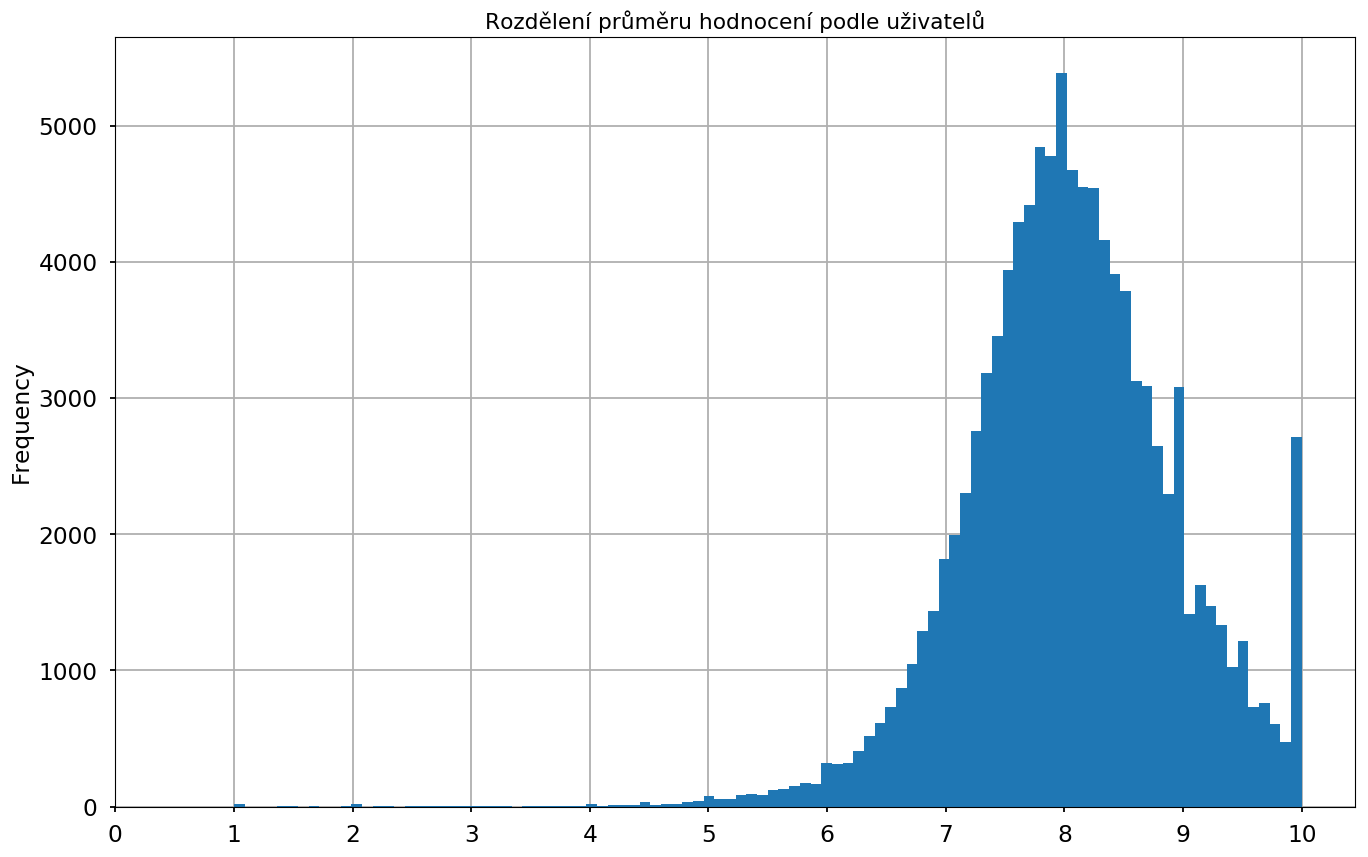

In [120]:
users['all_meanscore'].plot(kind='hist', bins=100, figsize=(16, 10), title='Rozdělení průměru hodnocení podle uživatelů')
plt.xticks(range(11), rotation=0)
plt.savefig('graphs/uzivatele-hodnoceni-prumer-histogram.png', bbox_inches='tight')

In [23]:
print('total users:', users['all_meanscore'].count())
print('users with mean score 10:', (users['all_meanscore'] == 10).sum())


total users: 105723
users with mean score 10: 2437


### analyzing users and genres now when I have features for genres per user

In [24]:

users[completed_columns] = users[completed_columns].fillna(0)  # without this, NaN values are ommited from mean calculation, which messes up data a lot
# semantically, NaN is zero, because it means that user has no completed anime of that genre
users_completed = users[completed_columns].div(users['all_completed'], axis=0).fillna(0)
users_ages_completed = users_completed.join(users['age'])
ages_genres = users_ages_completed.groupby('age').mean()
users_genders_completed = users_completed.join(users['gender'])
genders_genres = users_genders_completed.groupby('gender').mean()

users[above8_columns] = users[above8_columns].fillna(0)
users[above9_columns] = users[above9_columns].fillna(0)
users[mean_columns] = users[mean_columns].fillna(0)


In [25]:
# now try the histogram equalization on colormap to better show data
# histogram equalization taken from https://github.com/jobar8/graphics/blob/master/graphics.py and modified little bit
from skimage import exposure

def cmap_to_array(cmap,N=256):
    """
    Return a Nx3 array of RGB values generated from a colormap.
    """
    return cmap(np.linspace(0, 1, N))[:,:3] # remove alpha column

def equalize_colormap(cmap, data, name='EqualizedMap'):
    if type(data) is pd.DataFrame:
        data = data.values
    data = data[~np.isnan(data)].flatten()
    cdf, bins = exposure.cumulative_distribution(data, nbins=256)
    # Using it for highly non-uniform data will cause high information loss for extreme values
    #So we do only half equalization, equalizing with histogram averaged with uniform histogram
    # and now the same for uniform distribution of same size
    cdf_u, bins_u = exposure.cumulative_distribution(np.linspace(data.min(), data.max(), data.shape[0]),nbins=256)
    cdf = (cdf + cdf_u) / 2
    '''
    Re-map a colormap according to a cumulative distribution. This is used to 
    perform histogram equalization of an image by changing the colormap 
    instead of the image. *This is not strickly speaking the equalization of the 
    colormap itself*.
    The cdf and bins should be calculated from an input image, as if carrying out
    the histogram equalization of that image. In effect, the cdf becomes integrated  
    to the colormap as a mapping function by redistributing the indices of the
    input colormap.
    
    Parameters
    ----------
    cmap : string or colormap object
        Input colormap to remap.
    bins : array
        Centers of bins.
    cdf : array
        Values of cumulative distribution function.
    '''
    
    # first retrieve the color table (lists of RGB values) behind the input colormap
    if cmap in mpl.cm.cmap_d: # matplotlib colormaps + plus the new ones (viridis, inferno, etc.)
        cmList = cmap_to_array(cm.cmap_d[cmap])
    else:
        try:
            # in case cmap is a colormap object
            cmList = cmap_to_array(cmap) 
        except:
            raise ValueError('Colormap {} has not been recognised'.format(cmap))
    
    # normalize the input bins to interval (0,1)
    bins_norm = (bins - bins.min())/np.float(bins.max() - bins.min())
    
    # calculate new indices by applying the cdf as a function on the old indices
    # which are initially regularly spaced. 
    old_indices = np.linspace(0,1,len(cmList))
    new_indices = np.interp(old_indices,cdf,bins_norm)
    
    # make sure indices start with 0 and end with 1
    new_indices[0] = 0.0
    new_indices[-1] = 1.0
    
    # remap the color table
    cdict = {'red': [], 'green': [], 'blue': []}
    for i,n in enumerate(new_indices):
        r1, g1, b1 = cmList[i]
        cdict['red'].append([n, r1, r1])
        cdict['green'].append([n, g1, g1])
        cdict['blue'].append([n, b1, b1])
        
    return mpl.colors.LinearSegmentedColormap(name, cdict)


Text(0.5, 1.0, 'genre percentage in animelists')

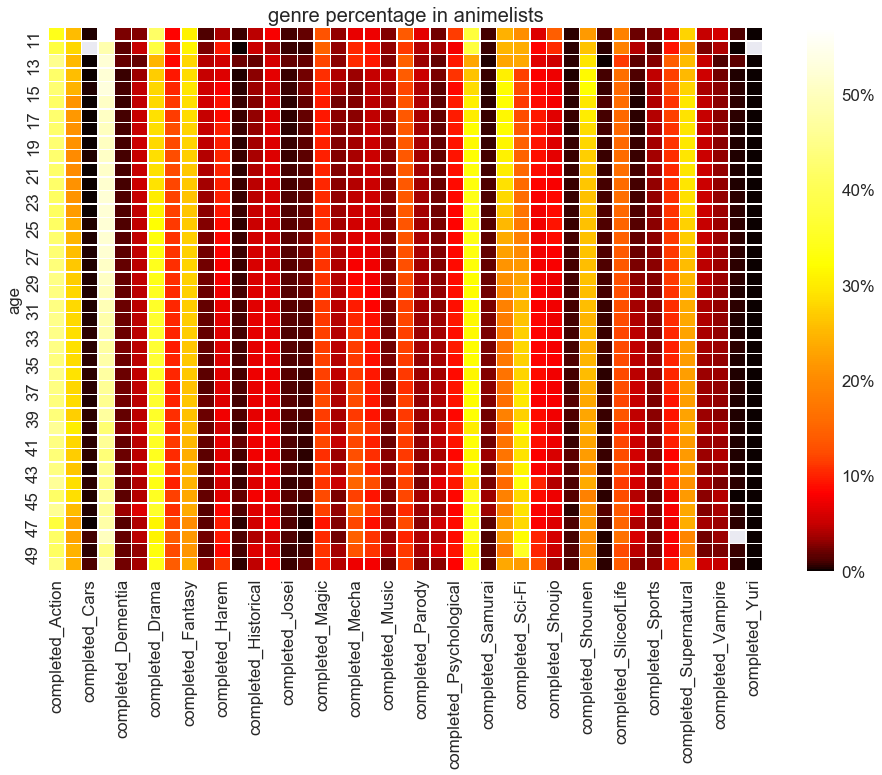

In [26]:
f, ax = plt.subplots(figsize=(16, 10))
#data = ages_genres.div(ages_genres.sum(axis=1), axis=0) * 100
data = ages_genres * 100
cmap = equalize_colormap(plt.cm.hot, data)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=cmap, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('genre percentage in animelists')

Text(0.5, 1.0, 'histograms normed per genre')

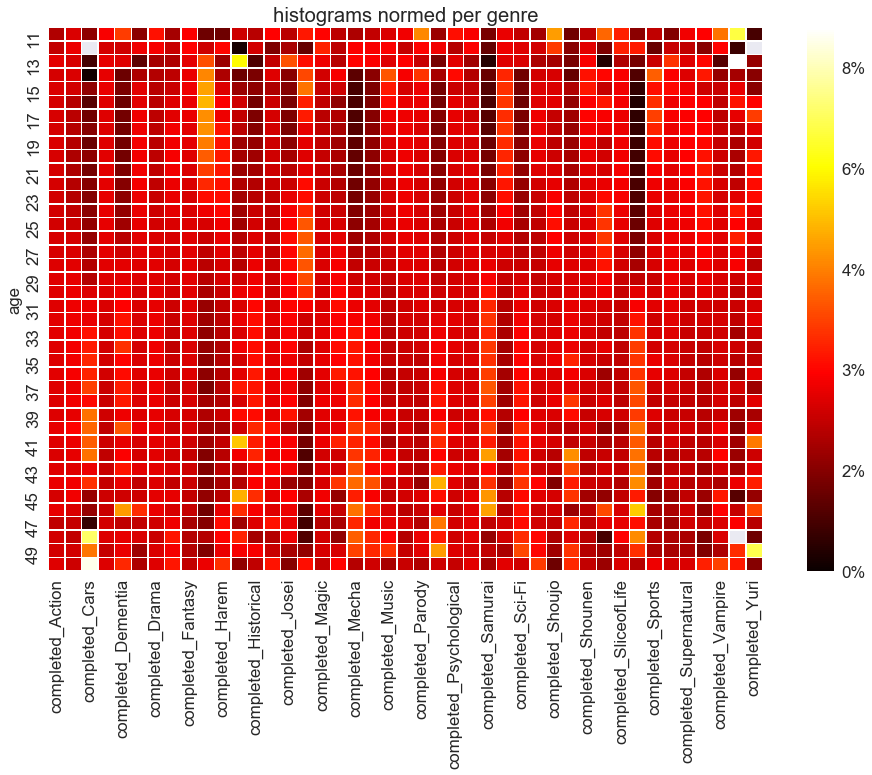

In [27]:
f, ax = plt.subplots(figsize=(16, 10))
data = ages_genres.div(ages_genres.sum(axis=0), axis=1) * 100
#data = ages_genres * 100
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=plt.cm.hot, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('histograms normed per genre')

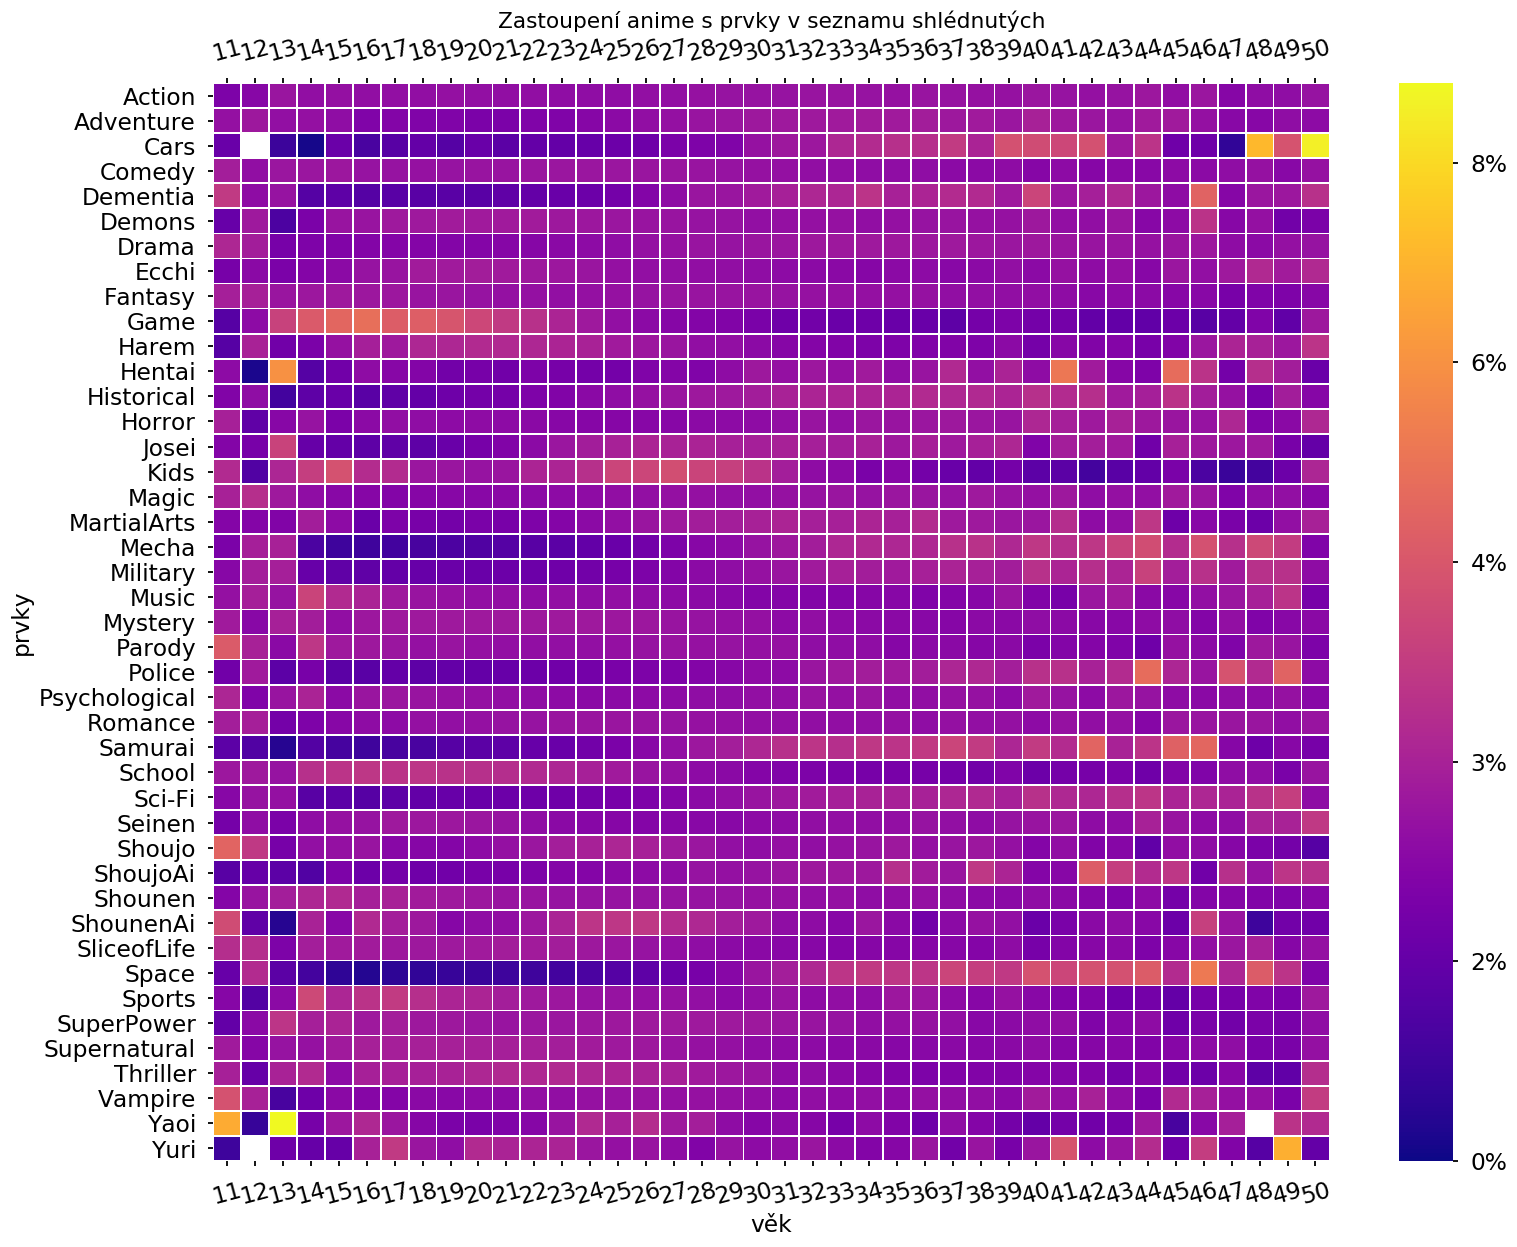

In [148]:
f, ax = plt.subplots(figsize=(18, 14))
renaming = {x: x.replace('completed_', '') for x in completed_columns}
data = ages_genres.div(ages_genres.sum(axis=0), axis=1) * 100
data = data.rename(columns=renaming)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data.T, mask=mask.T, cmap=plt.cm.plasma, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.gca().tick_params(labelbottom=True,labeltop=True, top=True, bottom=True)
plt.title('Zastoupení anime s prvky v seznamu shlédnutých', pad=40)
plt.xticks(rotation=15)
plt.xlabel('věk')
plt.ylabel('prvky')
plt.savefig('graphs/uzivatele-vek-zanr-heatmap.png', bbox_inches='tight')

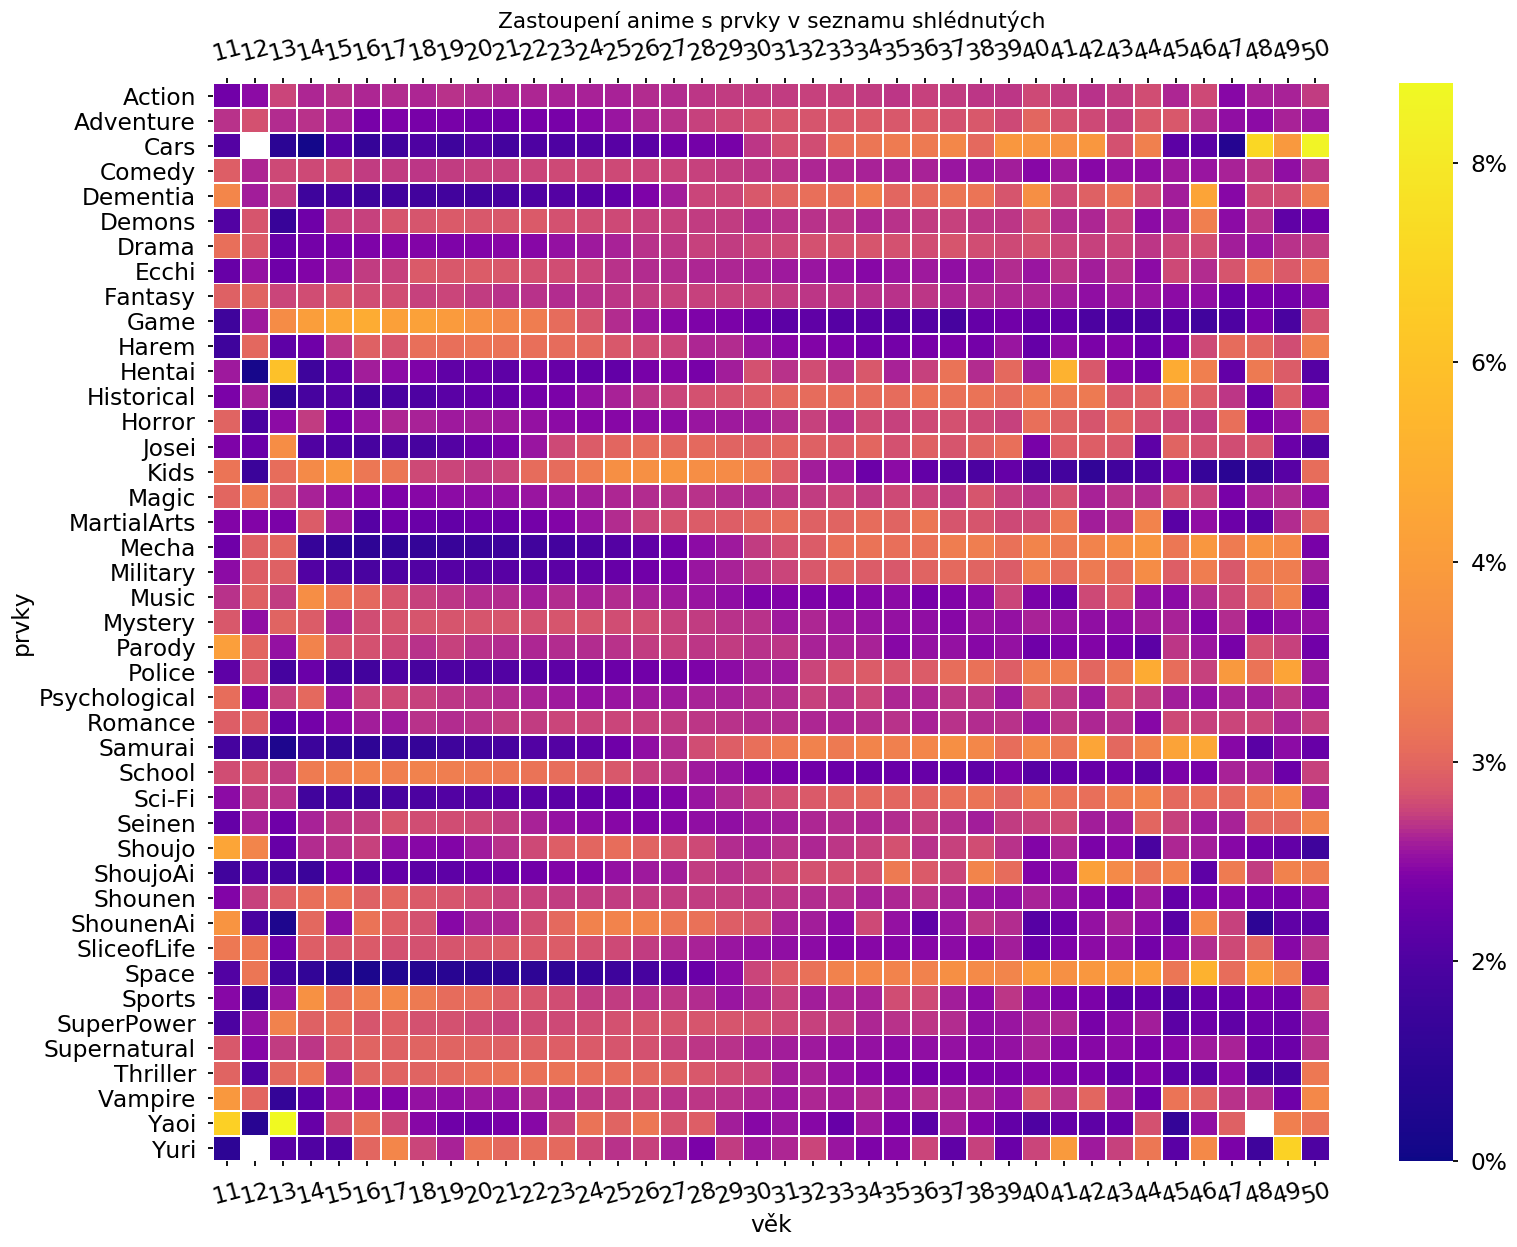

In [147]:
f, ax = plt.subplots(figsize=(18, 14))
renaming = {x: x.replace('completed_', '') for x in completed_columns}
data = ages_genres.div(ages_genres.sum(axis=0), axis=1) * 100
data = data.rename(columns=renaming)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data.T, mask=mask.T, cmap=equalize_colormap(plt.cm.plasma, data.T), linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.gca().tick_params(labelbottom=True,labeltop=True, top=True, bottom=True)
plt.title('Zastoupení anime s prvky v seznamu shlédnutých', pad=40)
plt.xticks(rotation=15)
plt.xlabel('věk')
plt.ylabel('prvky')
plt.savefig('graphs/uzivatele-vek-zanr-heatmap-equalized.png', bbox_inches='tight')

In [29]:
users[['all_completed', 'age', 'gender'] + completed_columns]

all_completed  age  gender  completed_Action  \
username                                                         
karthiga                   49.0   29  Female               7.0   
Damonashu                 188.0   28    Male             103.0   
bskai                     378.0   29    Male             130.0   
terune_uzumaki              5.0   21  Female               0.0   
Bas_G                     113.0   20    Male              58.0   
HimeAria                   84.0   23  Female              25.0   
Skallington                 3.0   28    Male               0.0   
Slimak                    222.0   31    Male             169.0   
Elysiun                     4.0   35    Male               3.0   
jimothy000                  NaN   24    Male               0.0   
MistButterfly            3011.0   27  Female            1118.0   
ProperBritish             225.0   27    Male              50.0   
kioniel                   405.0   31    Male             218.0   
Xinil                     213.0   34    Male              87.0   
helenply                  184.0   20  Female              51.0   
hood_rad                  309.0   22    Male              75.0   
detestedlove311            29.0   30  Female              17.0   
ihasabucket               145.0   35    Male              59.0   
xTheFallenx               608.0   26    Male             246.0   
L-LawlietDN                 NaN   24    Male               0.0   
zZKinhoZz                  65.0   19    Male              28.0   
glittermilk                33.0   25  Female              12.0   
Lithuelle                 139.0   34  Female              42.0   
scootarski                252.0   35    Male              88.0   
Yukia-Kontan               12.0   29    Male               4.0   
Akihara                   586.0   25  Female             284.0   
Tomoki-sama               334.0   23    Male             154.0   
Sakurei                   594.0   16  Female             202.0   
raickos                   166.0   30    Male              92.0   
Spike                     341.0   25  Female             158.0   
...                         ...  ...     ...               ...   
NessaIero                 235.0   24  Female              69.0   
TsuyoiTamashi231          266.0   21    Male             144.0   
Falco2424                 128.0   25    Male              73.0   
Theasn                    144.0   23    Male              83.0   
Ray0flight                 27.0   24    Male               7.0   
adultswimfan88             34.0   31    Male              20.0   
Doraka                     26.0   22    Male              16.0   
BlackRockShtr              98.0   19    Male              41.0   
Sadpanda                  243.0   40    Male             156.0   
FateMaster                508.0   27    Male             263.0   
xsxeotakux                  6.0   28    Male               5.0   
Perzik                     90.0   22  Female              44.0   
Tenos                     125.0   26    Male              54.0   
Destiney                   62.0   27  Female              19.0   
Lost_Bullet                71.0   28  Female              43.0   
alesos                     70.0   32    Male              51.0   
Jarlath7                  361.0   23    Male             181.0   
M_Northstar                38.0   45    Male              22.0   
ZnamJendrka               223.0   20    Male              87.0   
kvothe96_                 317.0   23    Male             169.0   
Dusty9797                  86.0   22    Male              36.0   
assassin0202              178.0   28    Male             136.0   
ZeroFr3aK                 178.0   26    Male             113.0   
yoyoman9                   32.0   20    Male              13.0   
generalist                184.0   31    Male              36.0   
isoann                    208.0   22    Male              66.0   
bumcakee                  116.0   21  Female              23.0   
Scarlet95                 103.0   24  Female              

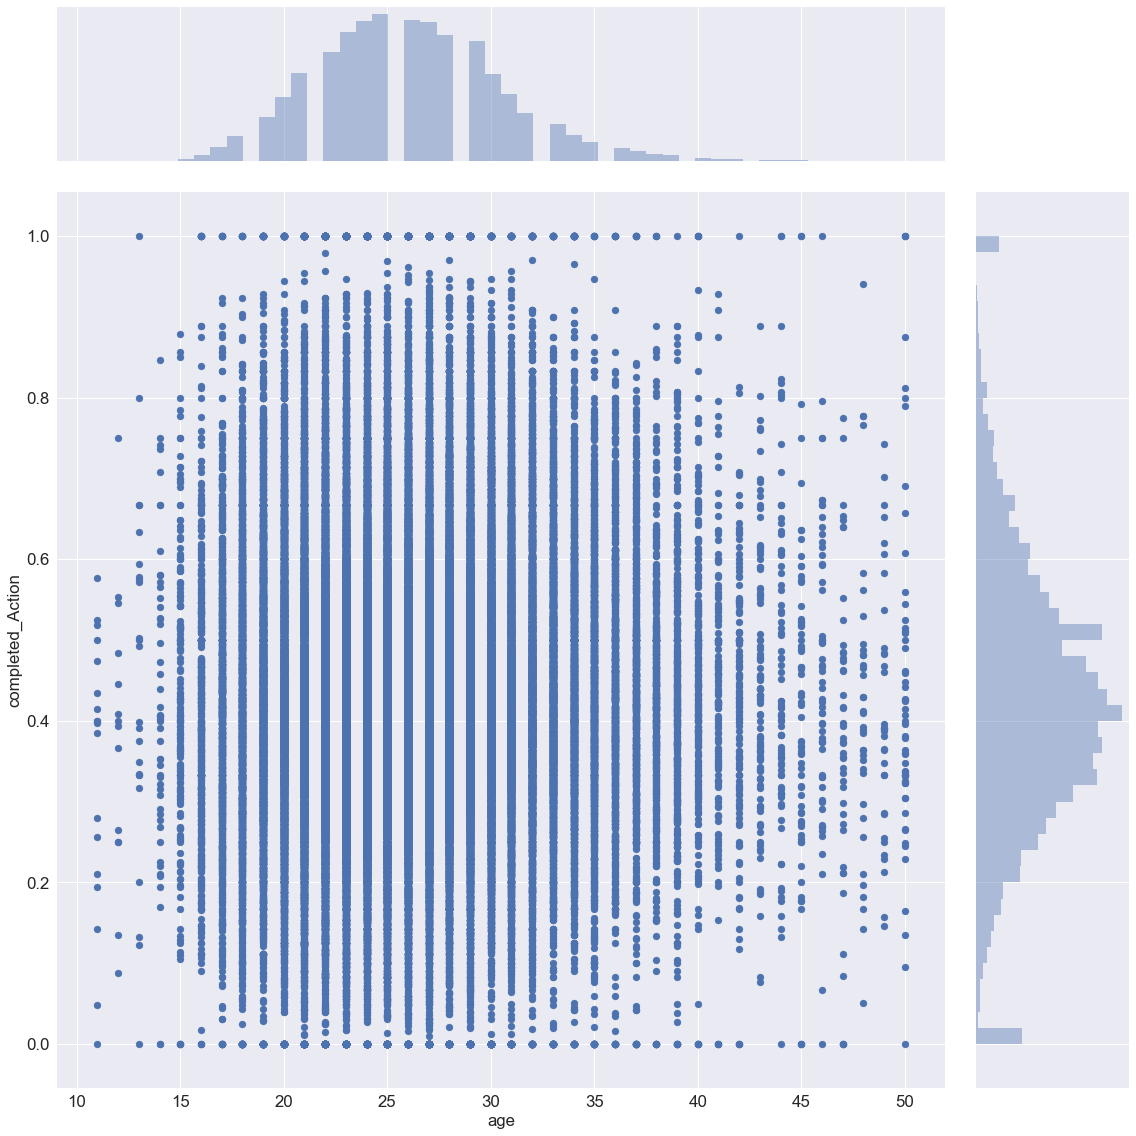

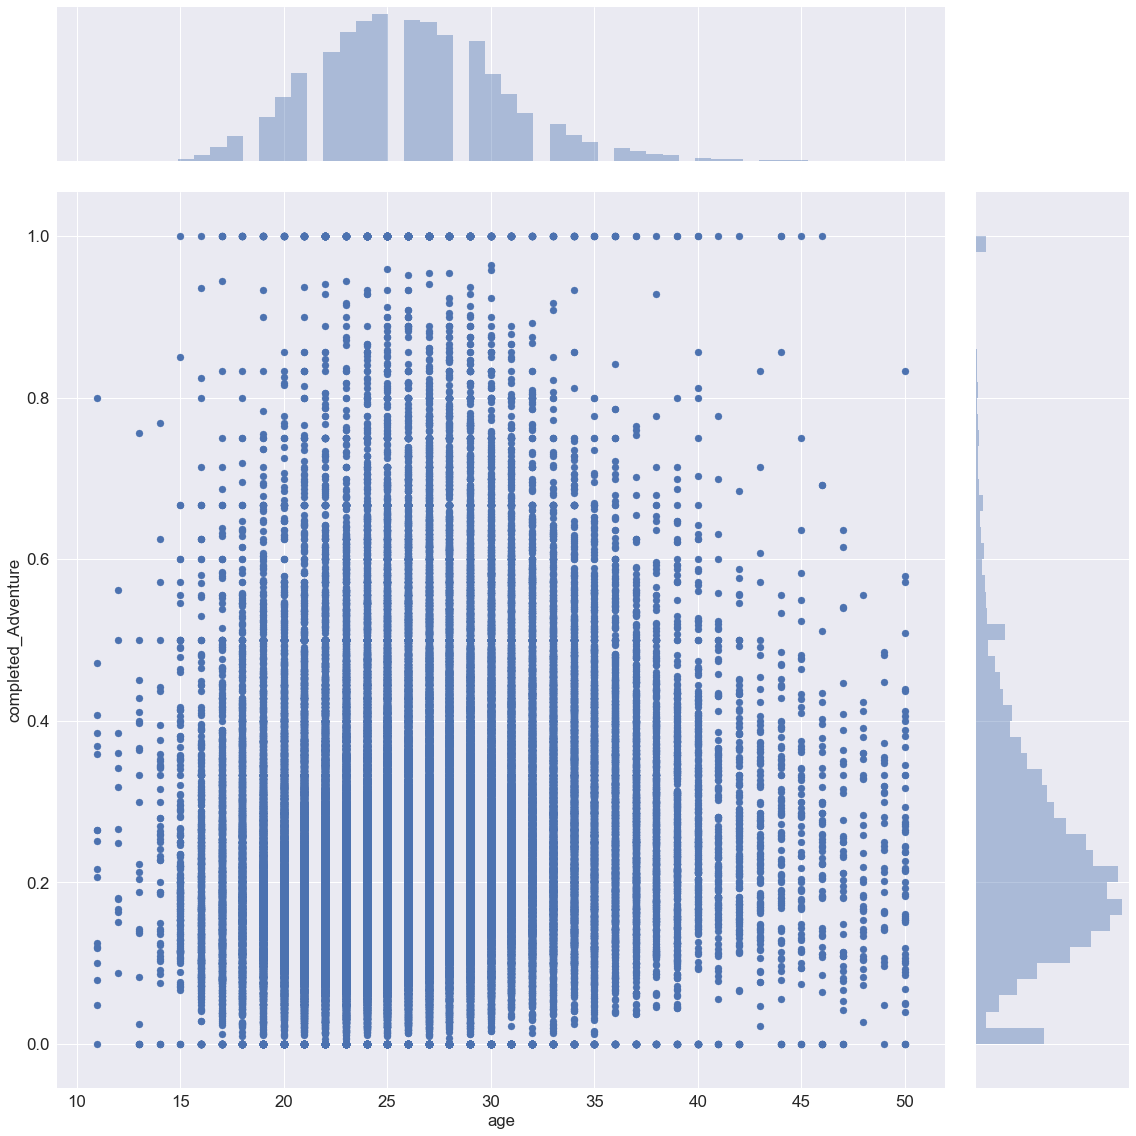

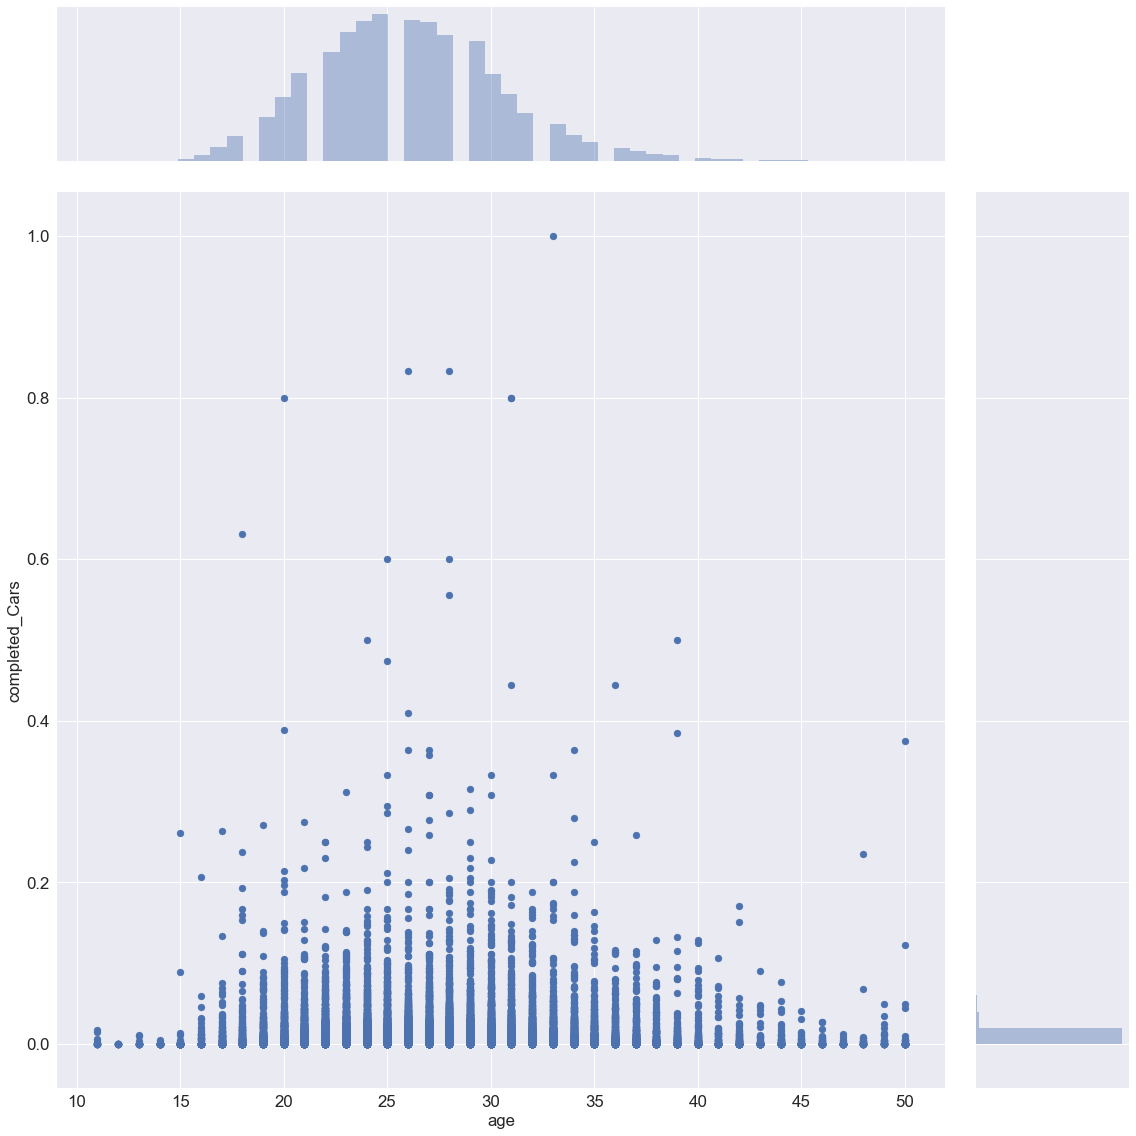

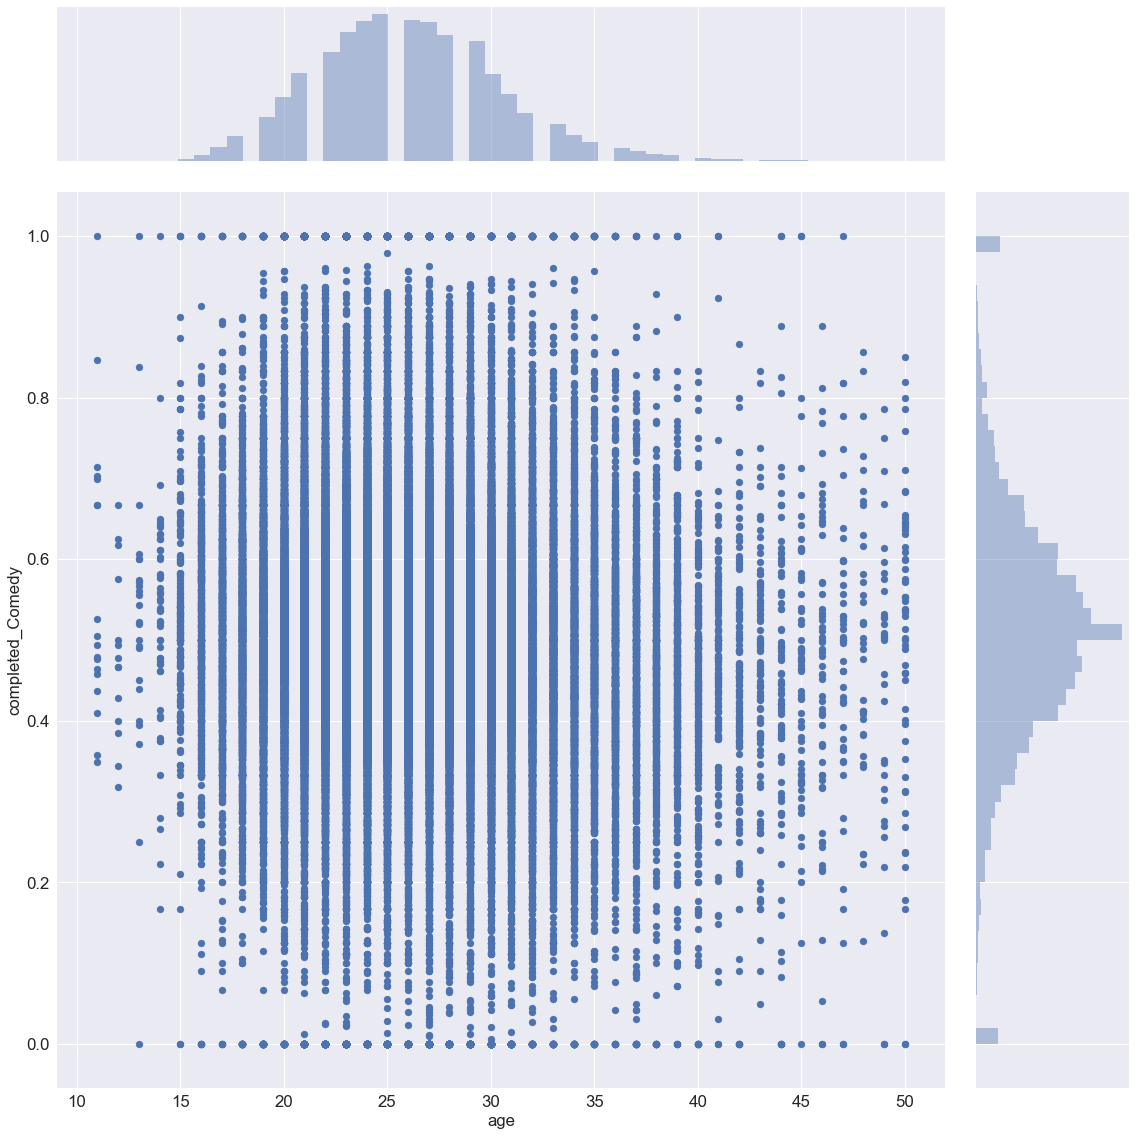

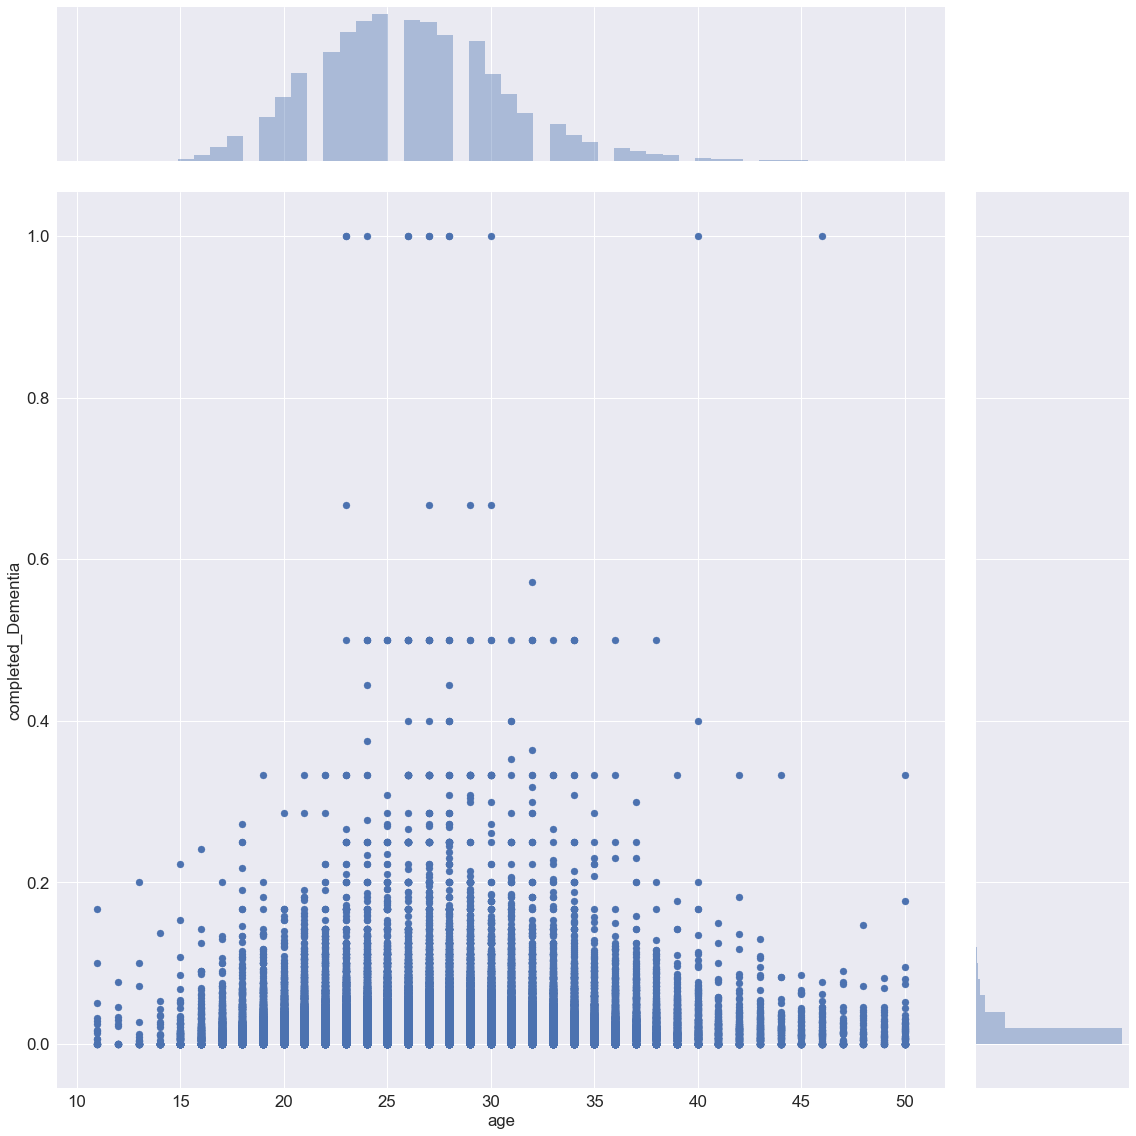

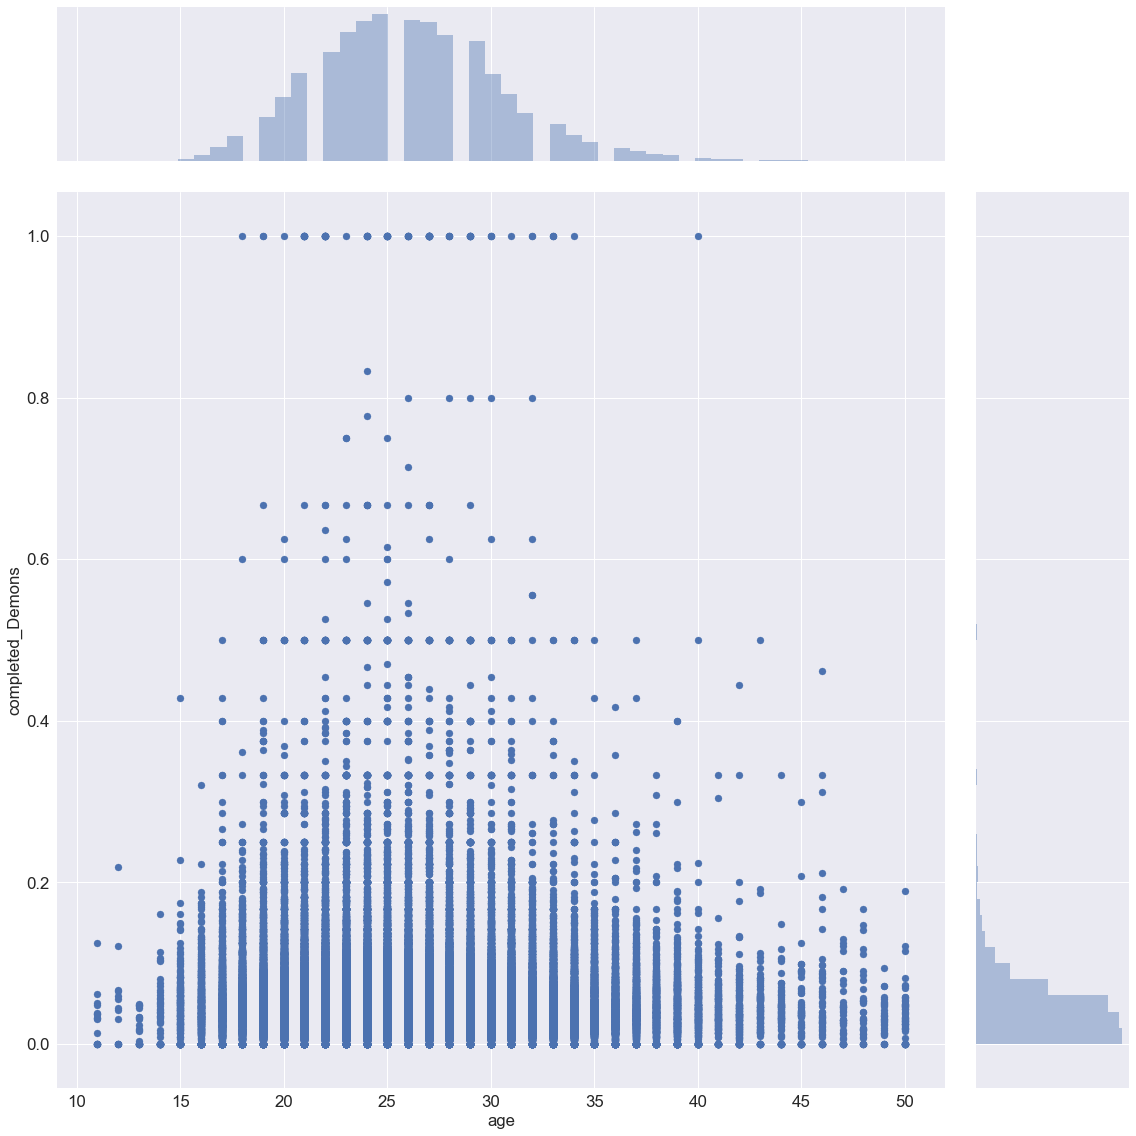

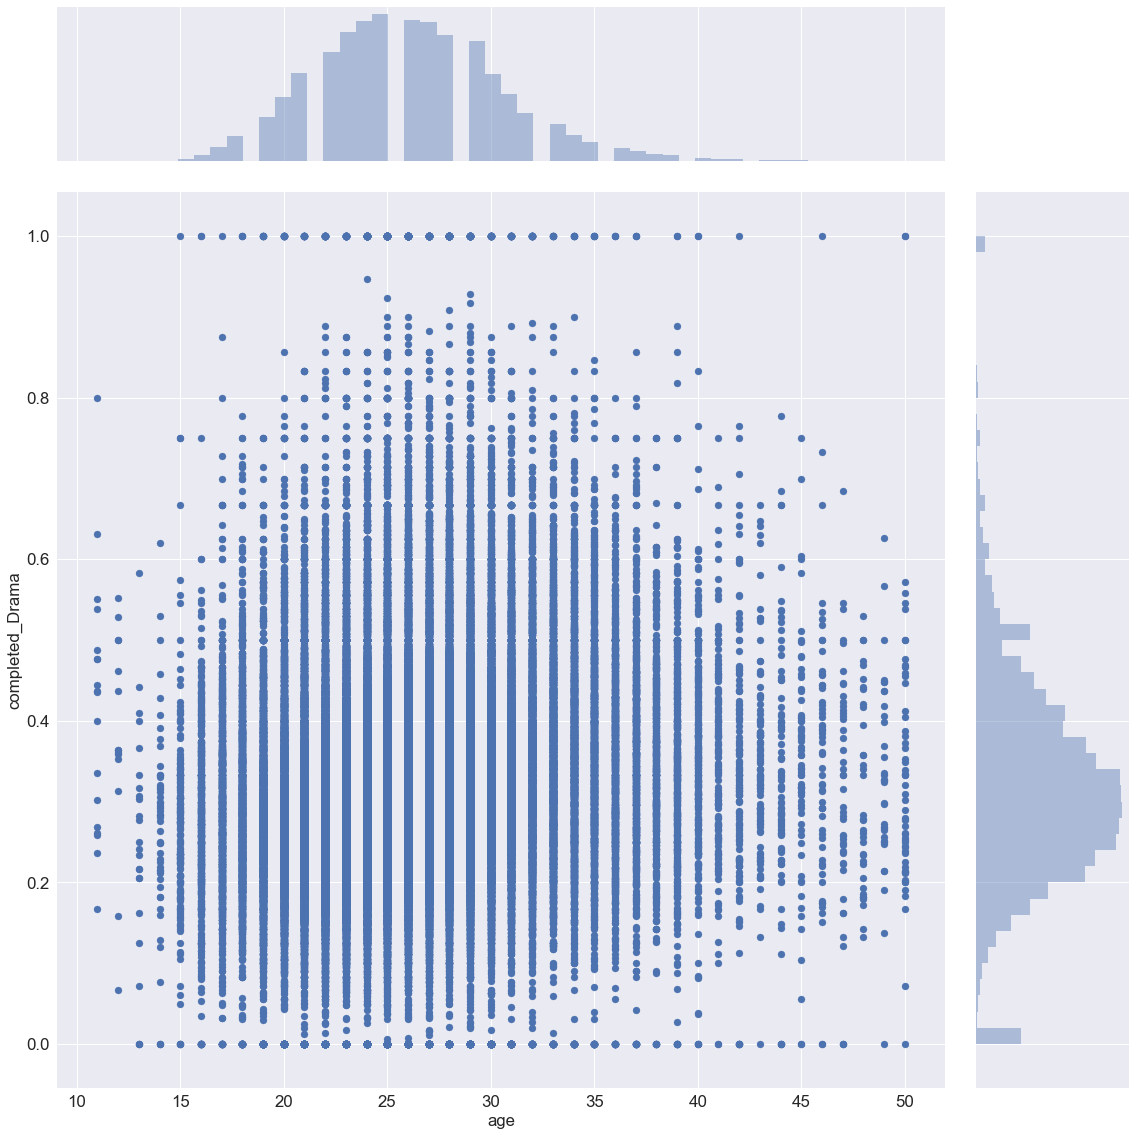

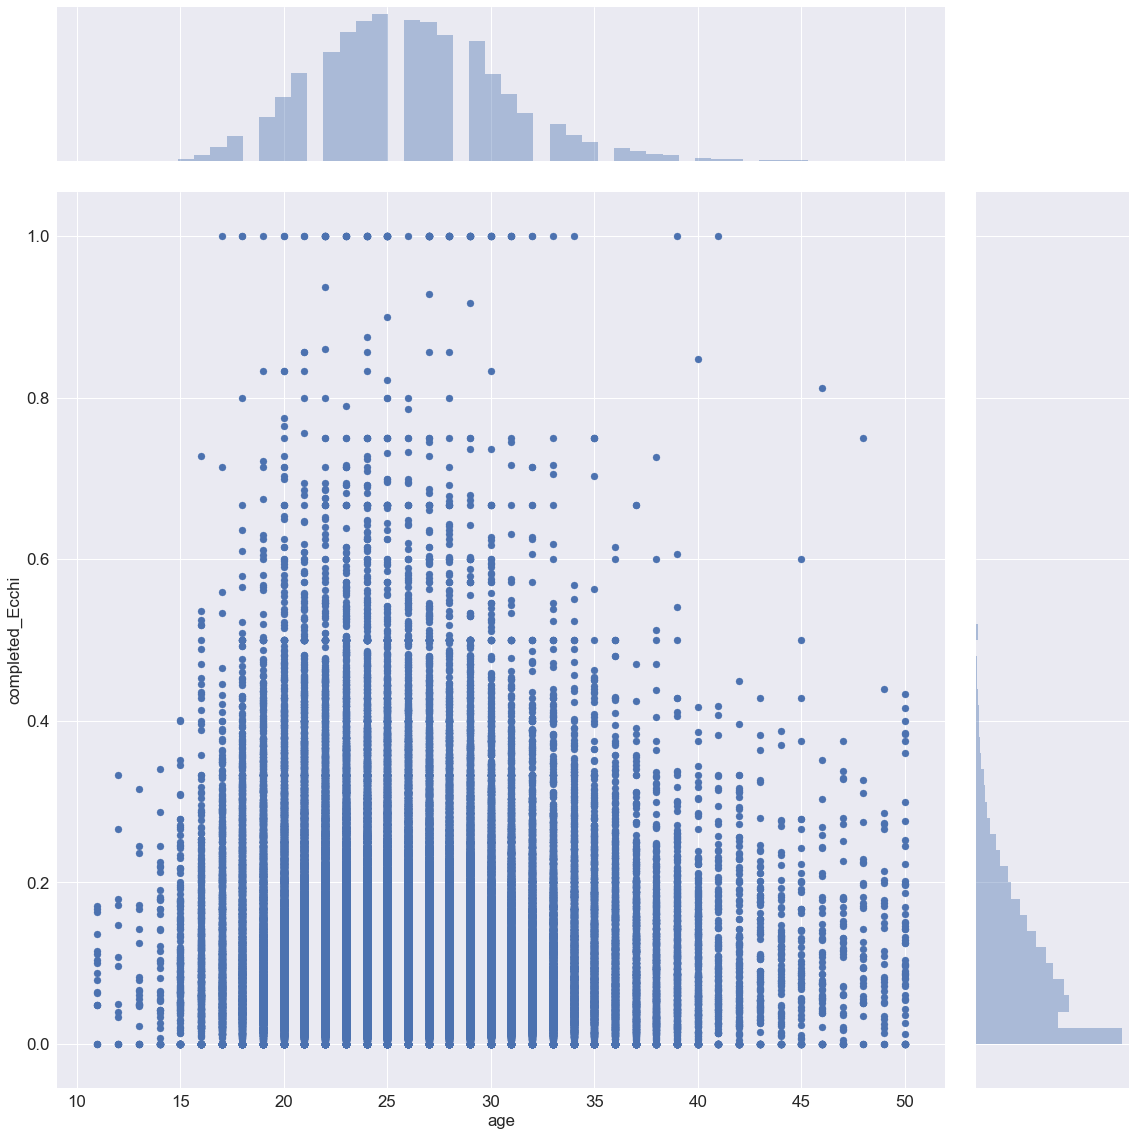

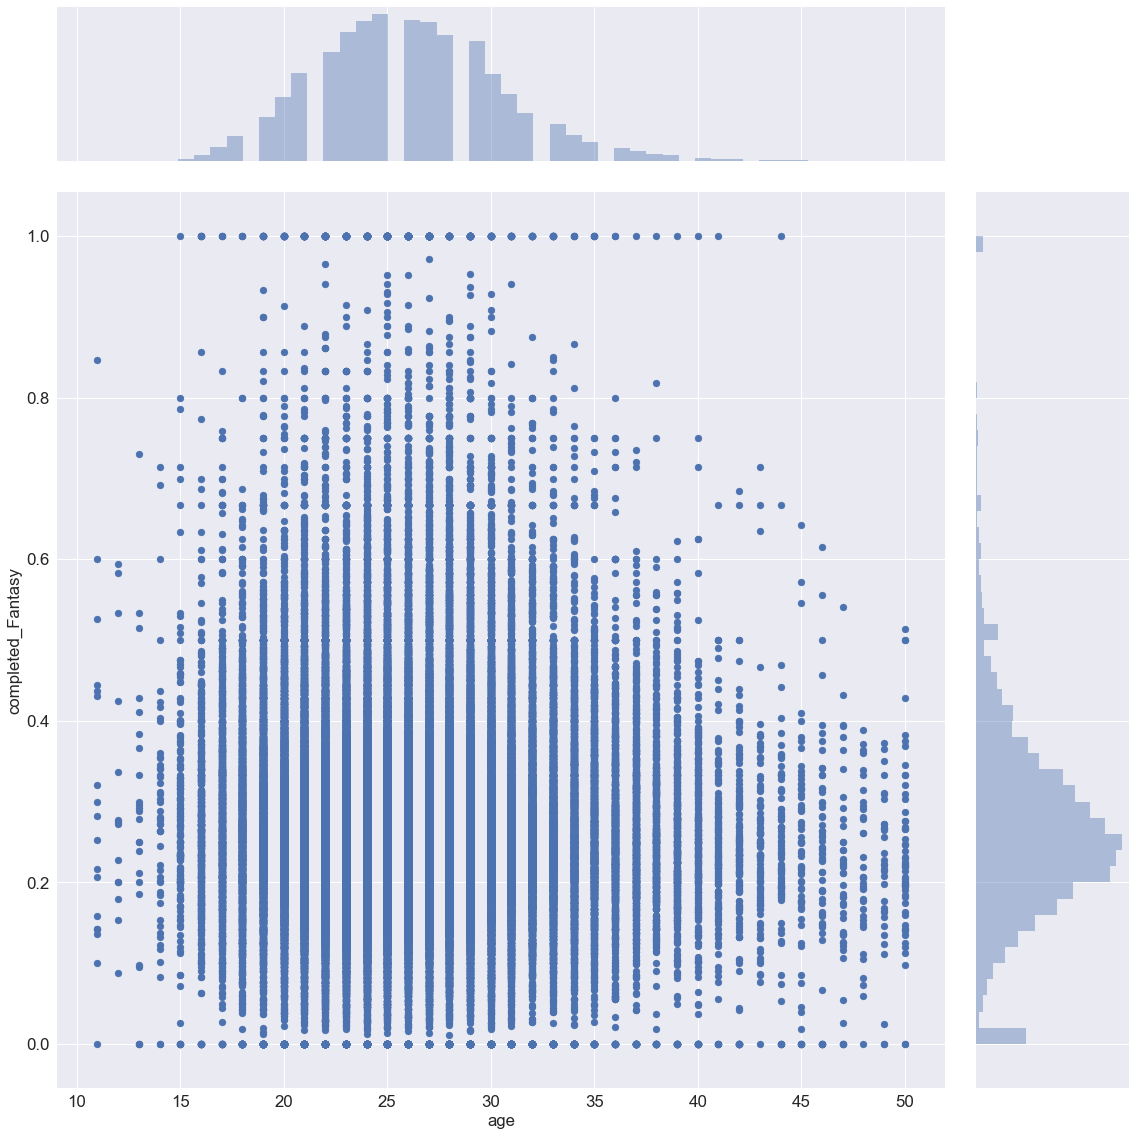

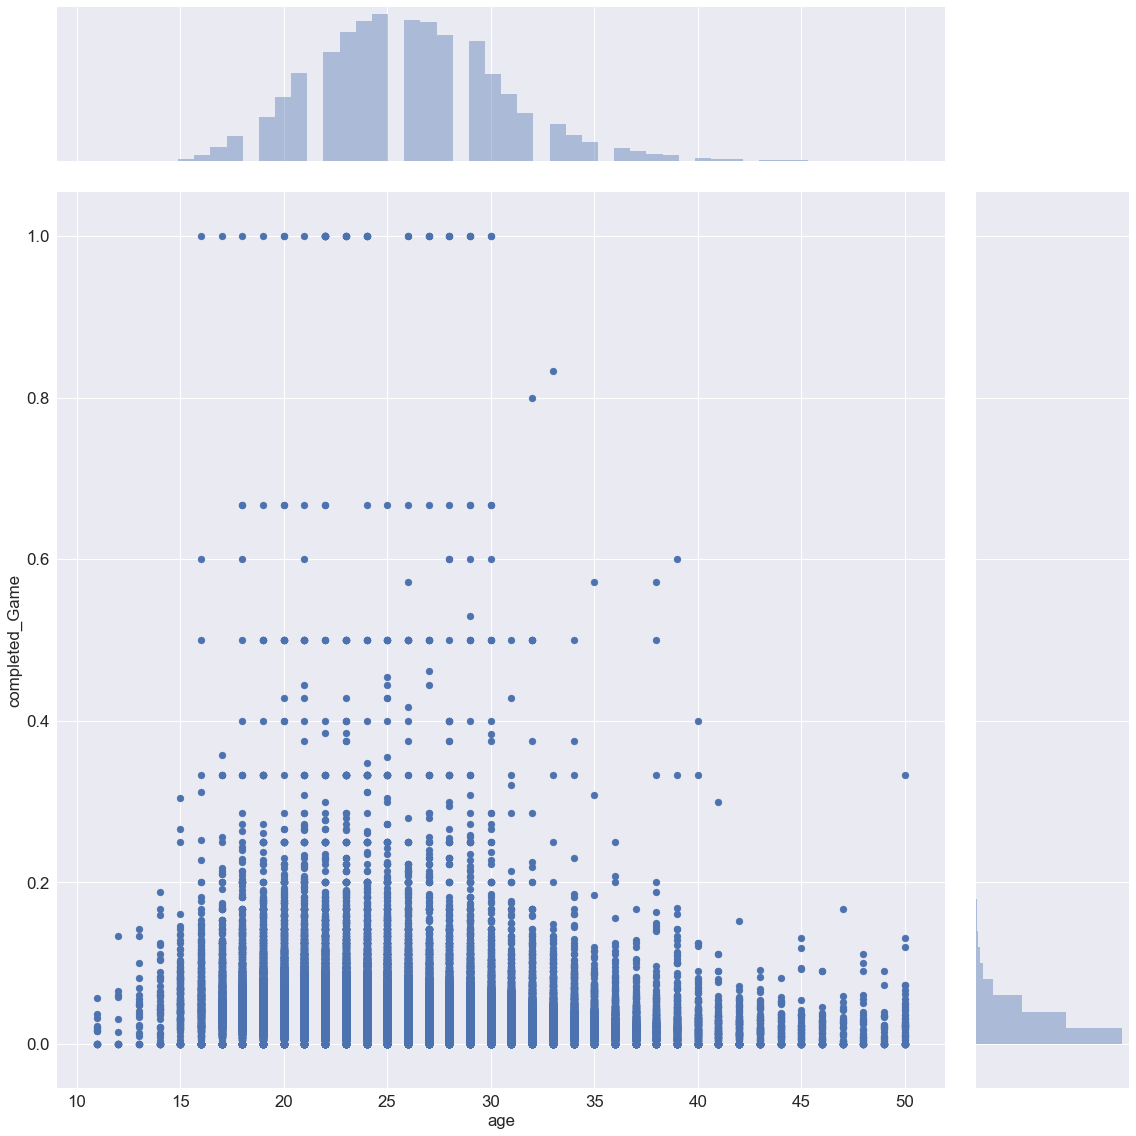

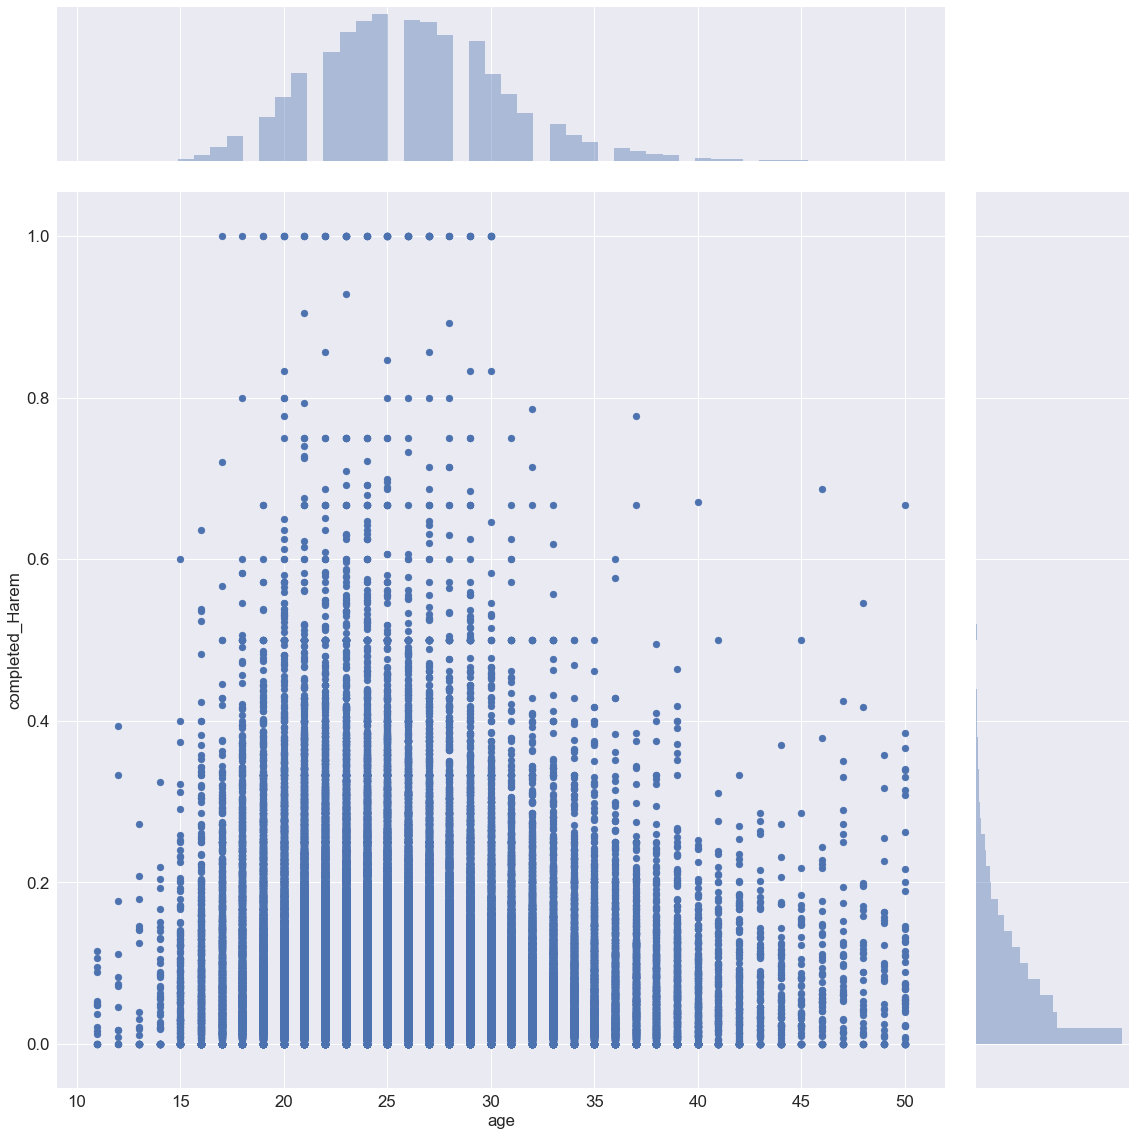

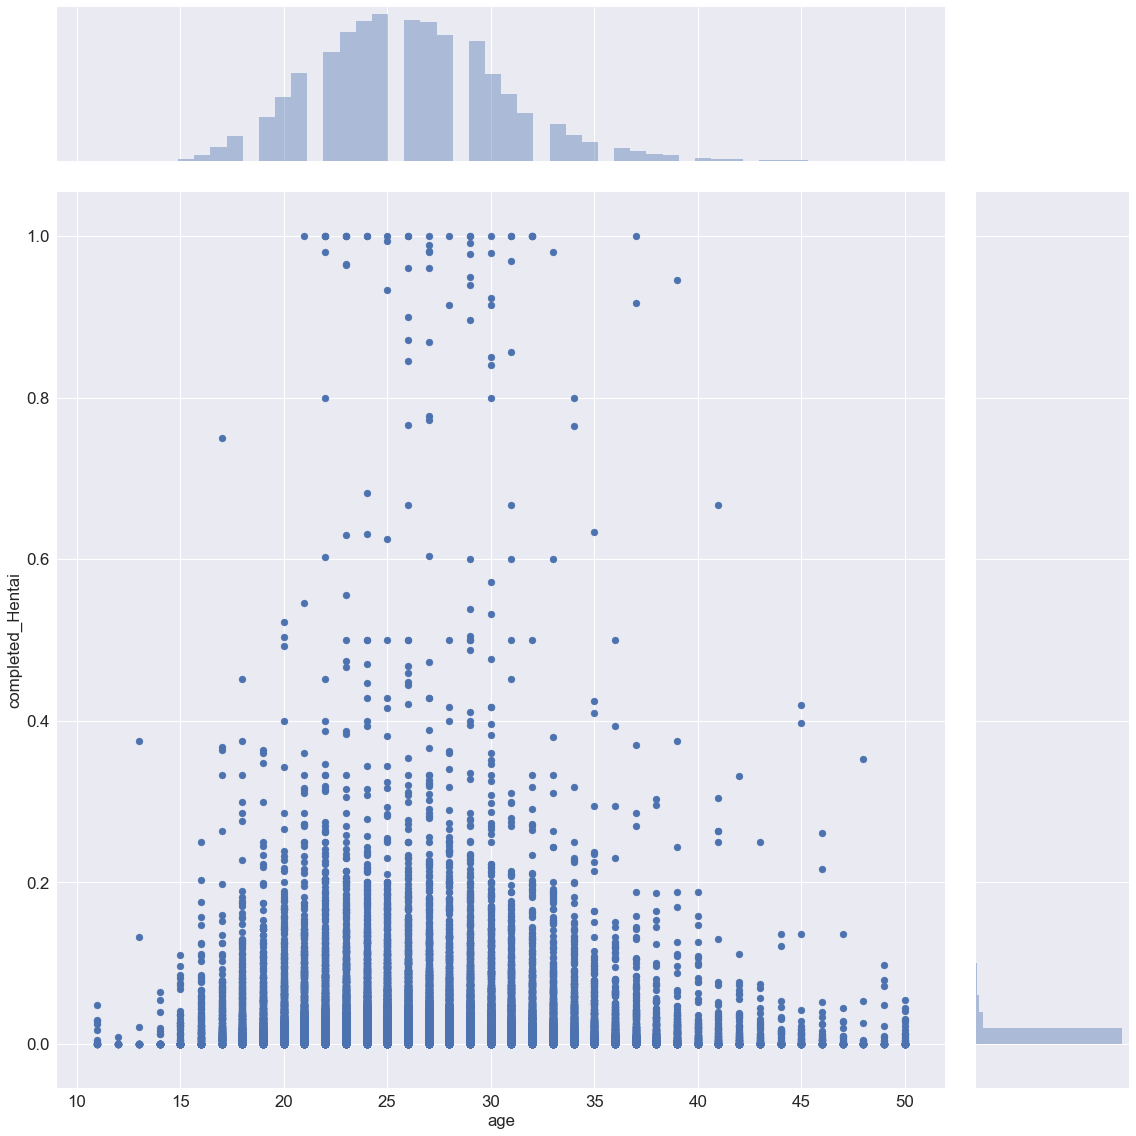

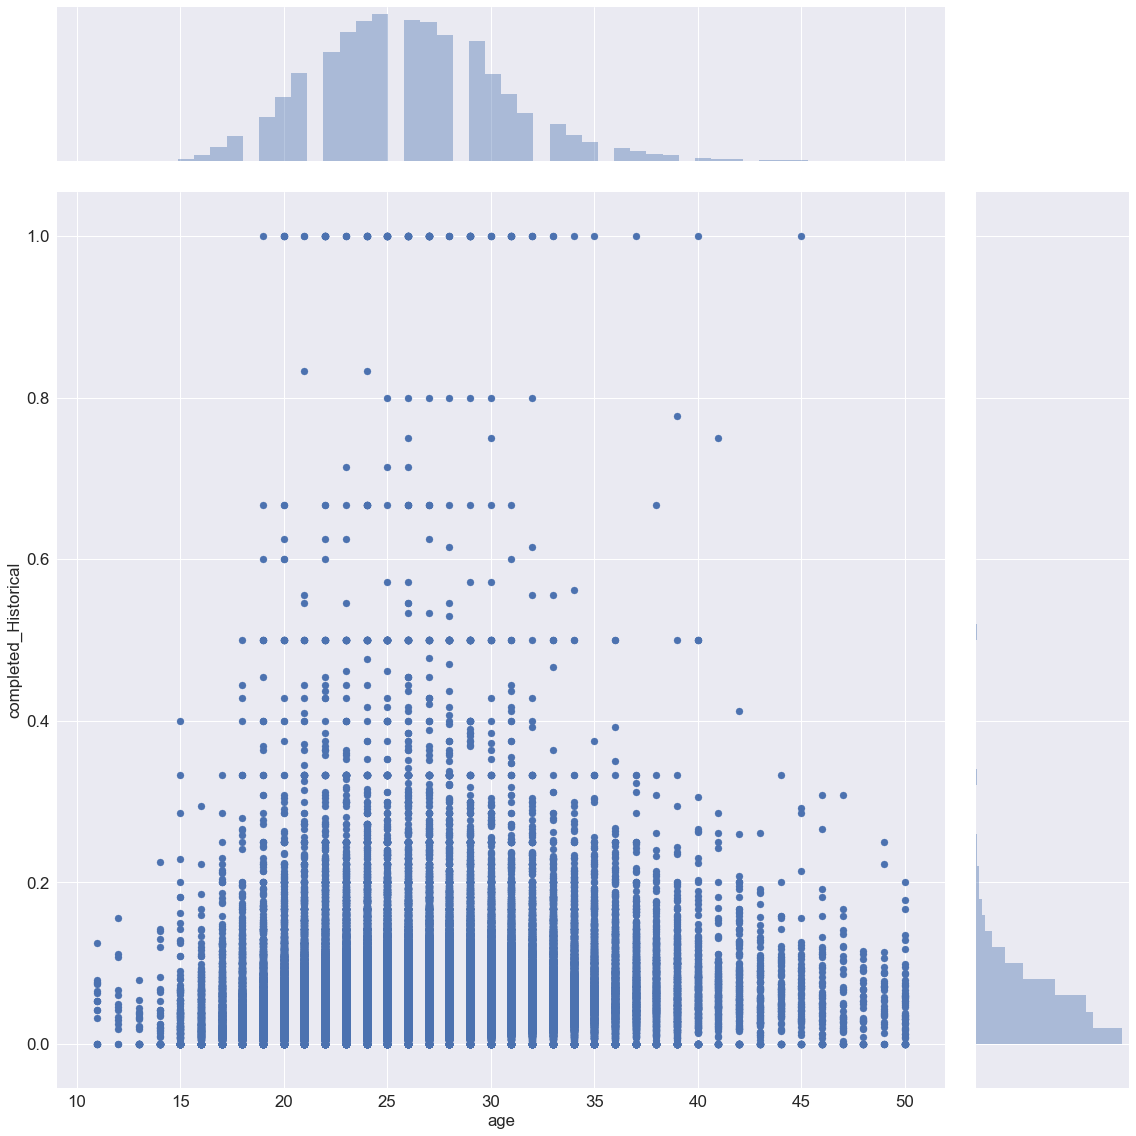

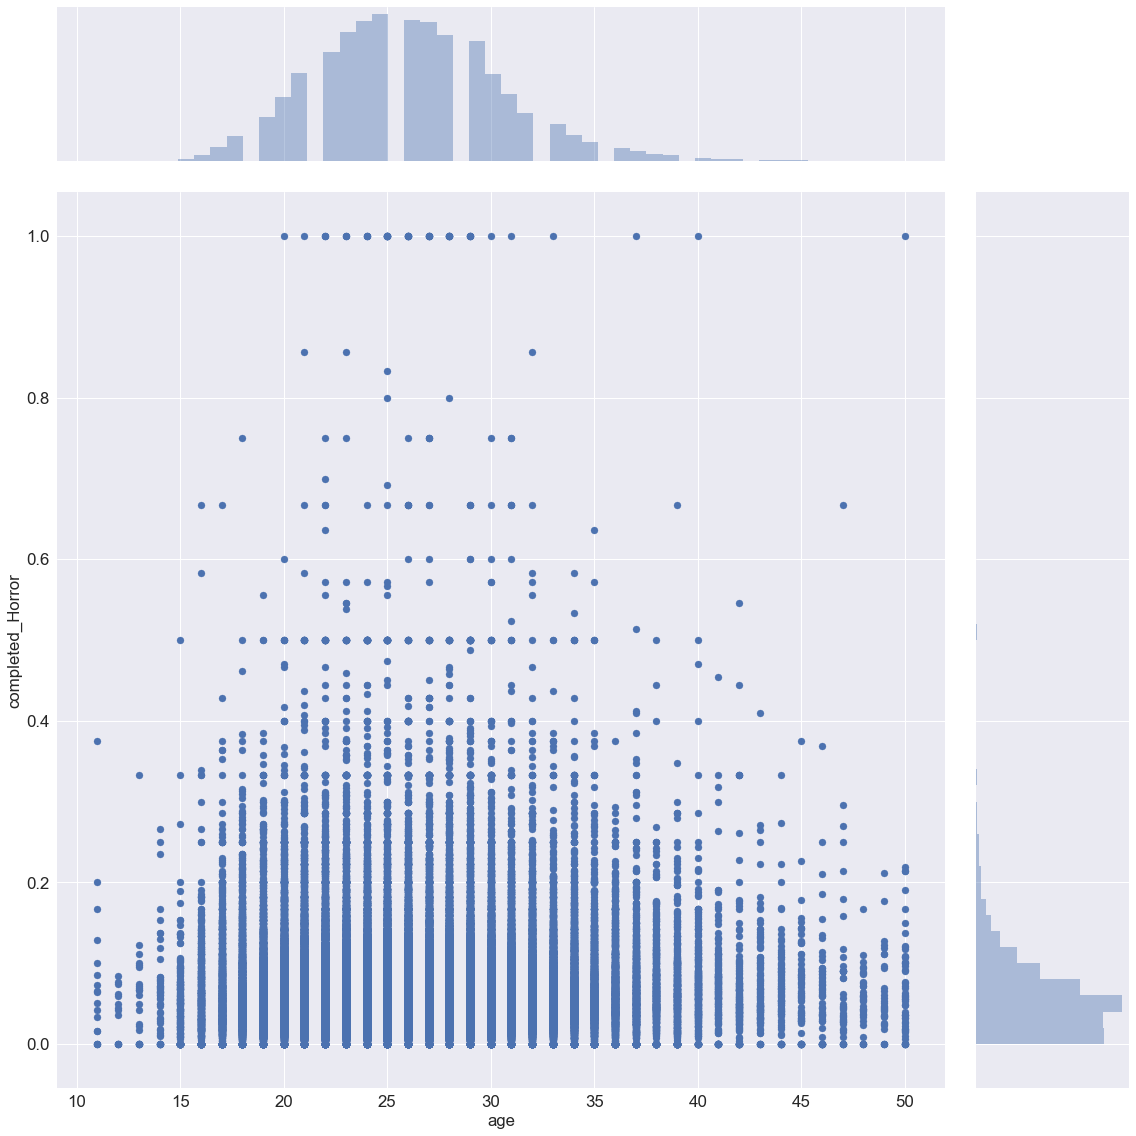

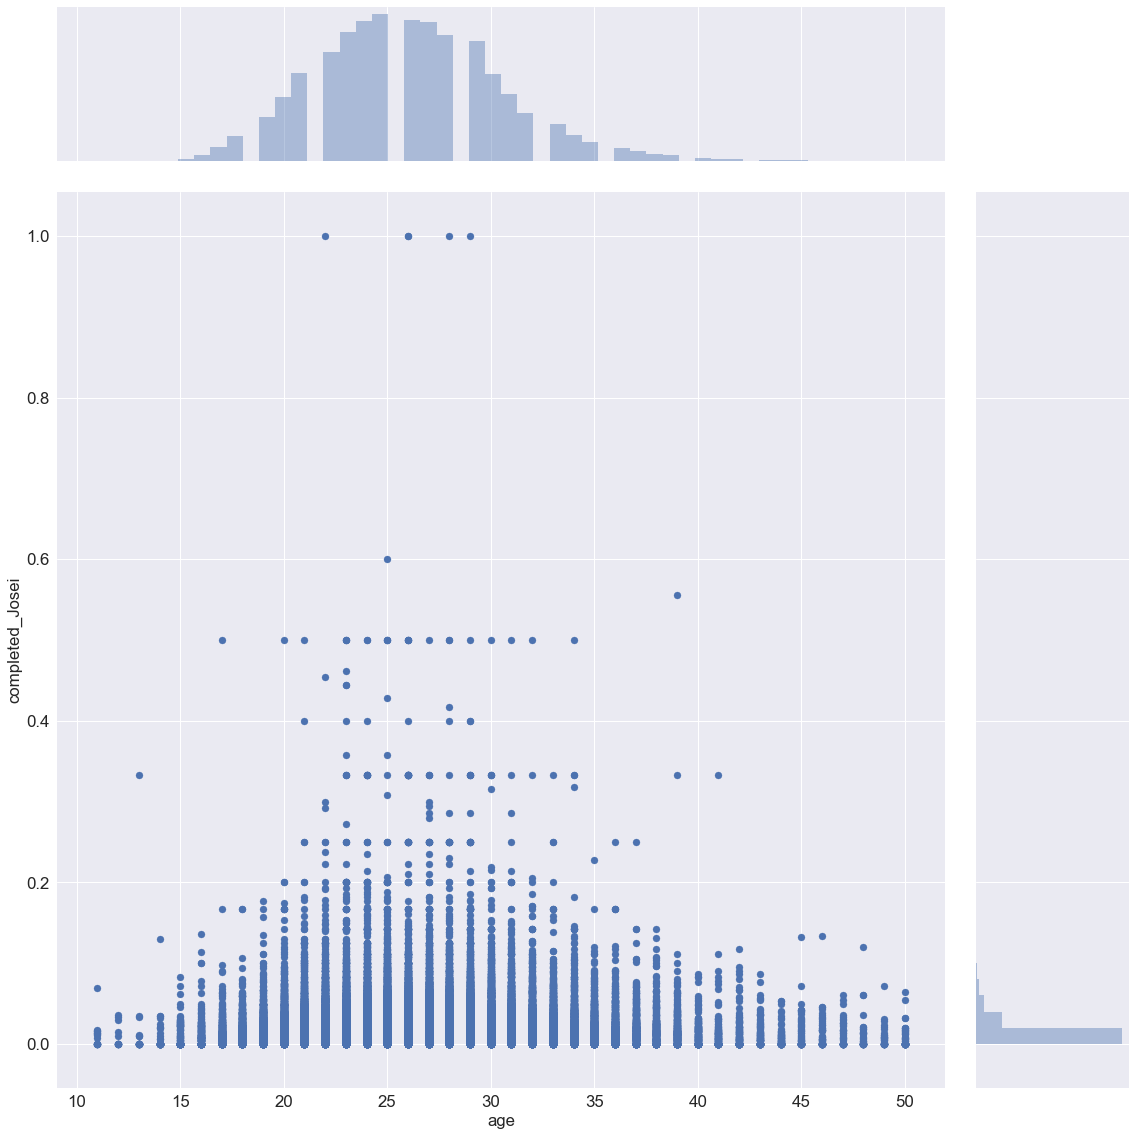

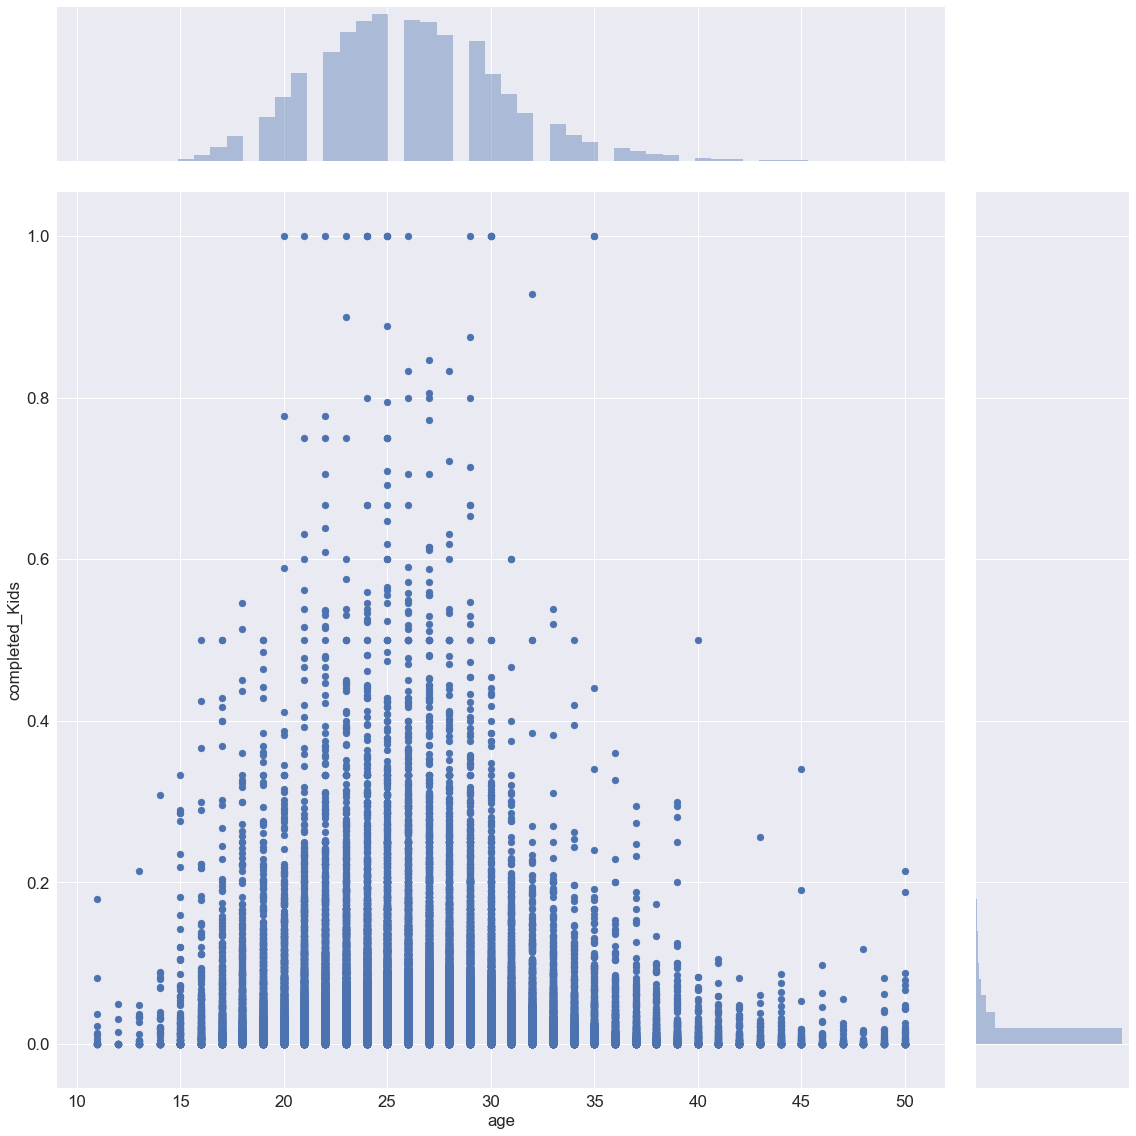

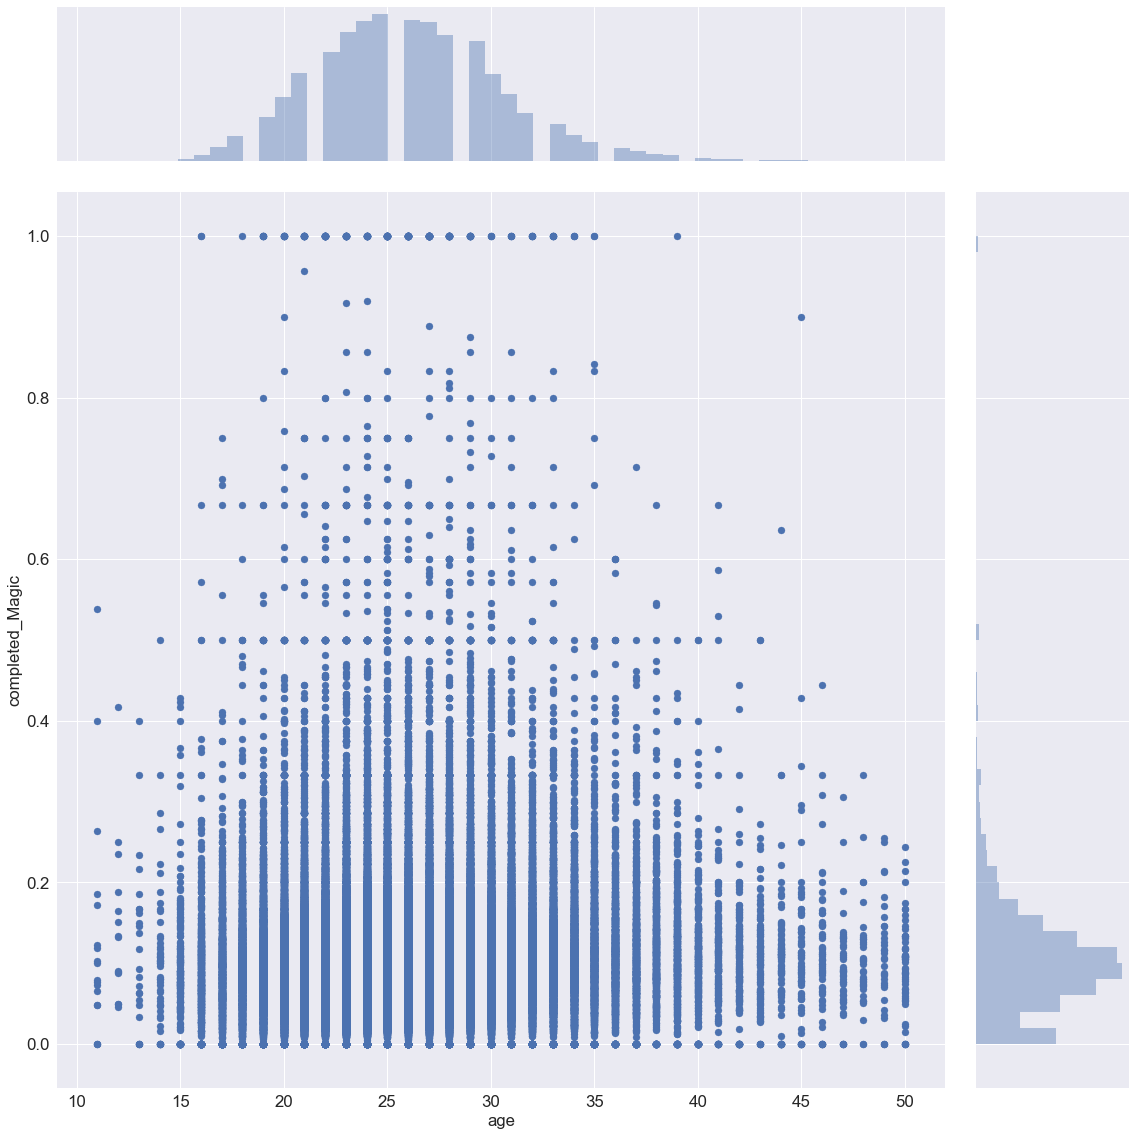

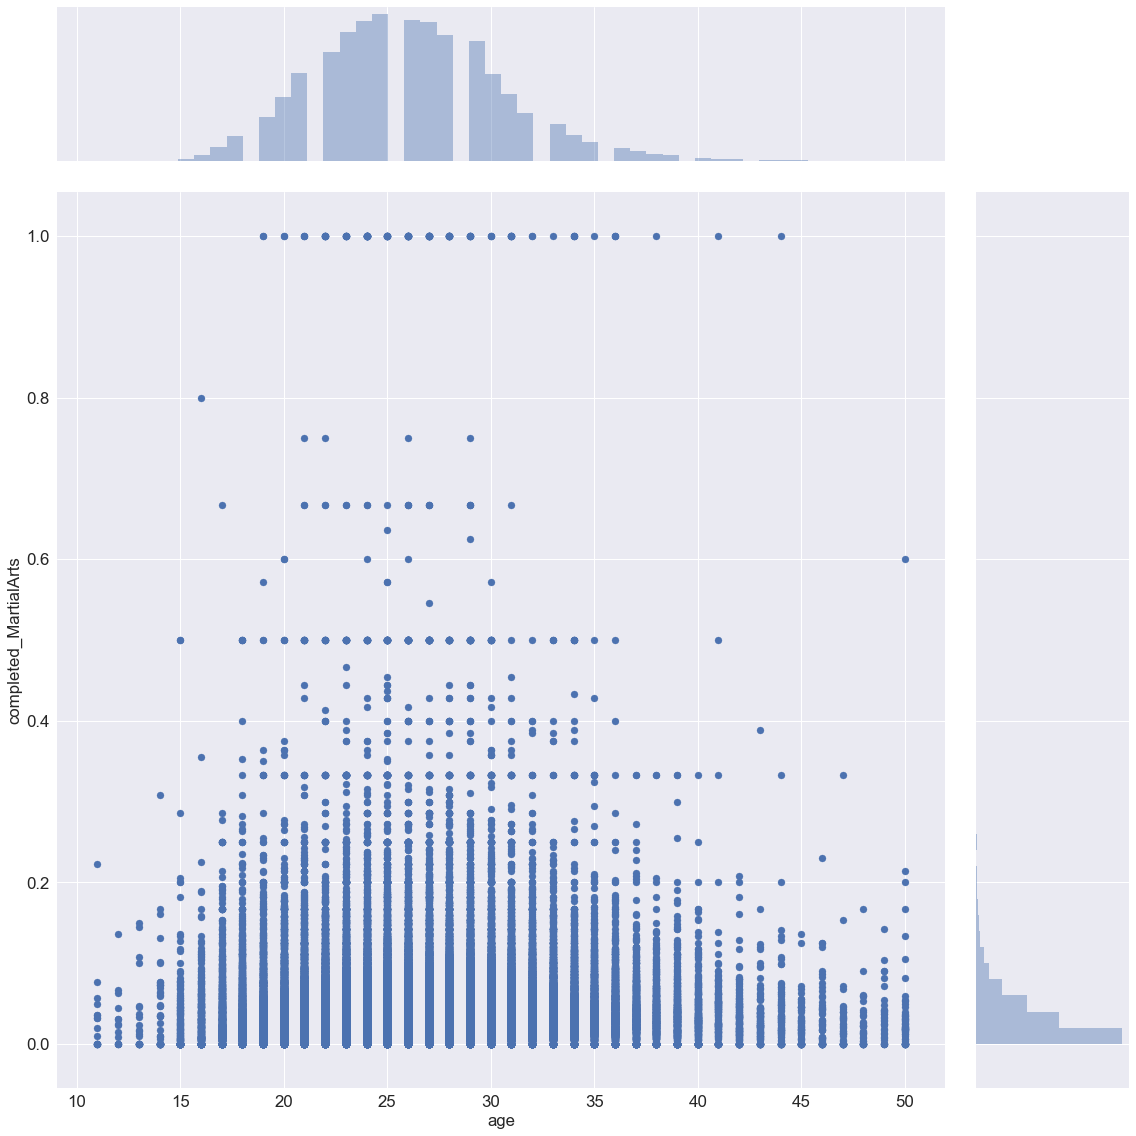

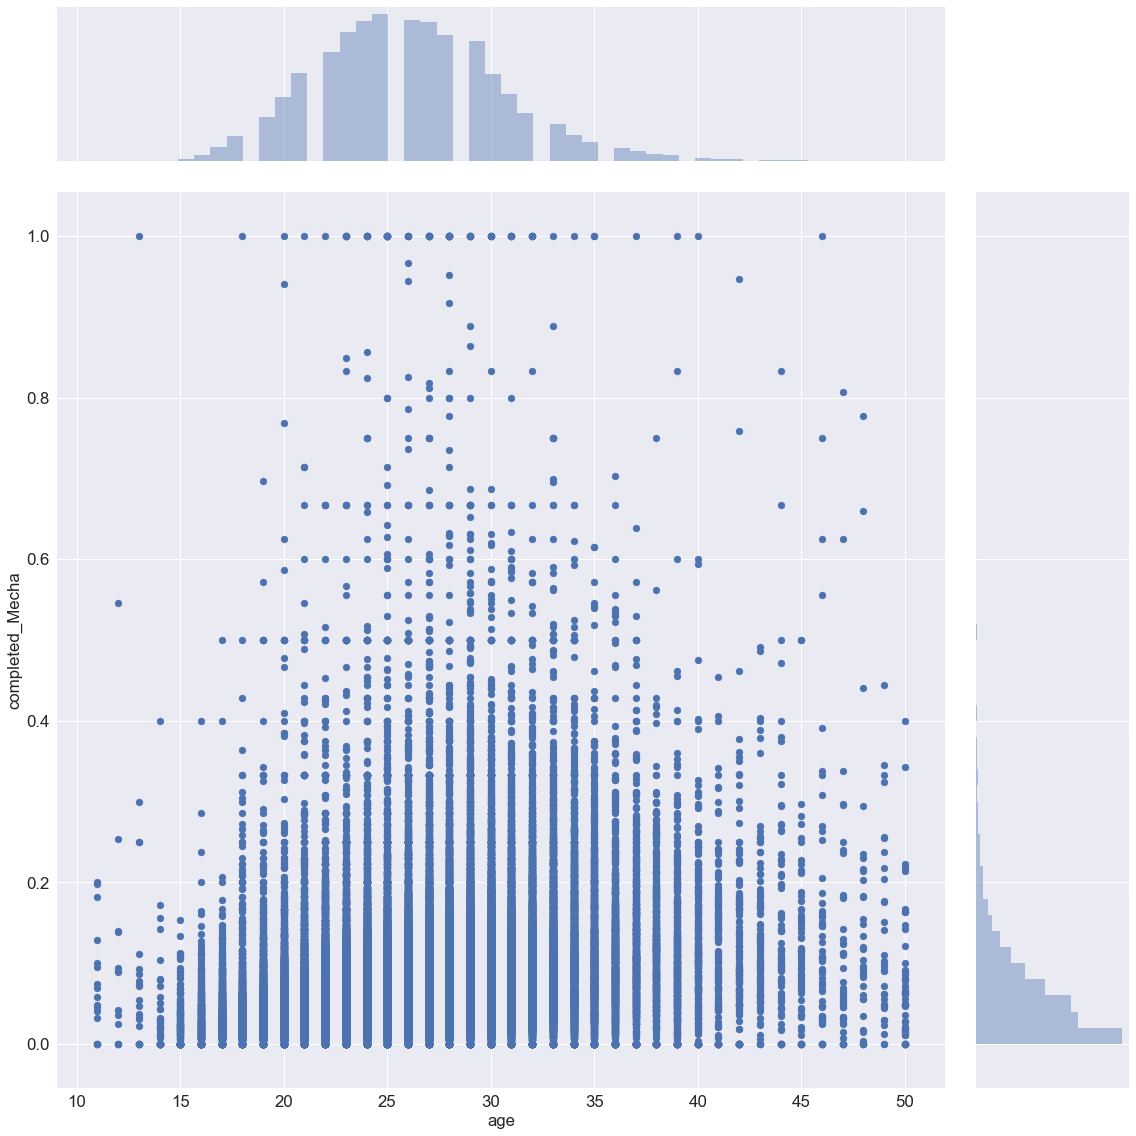

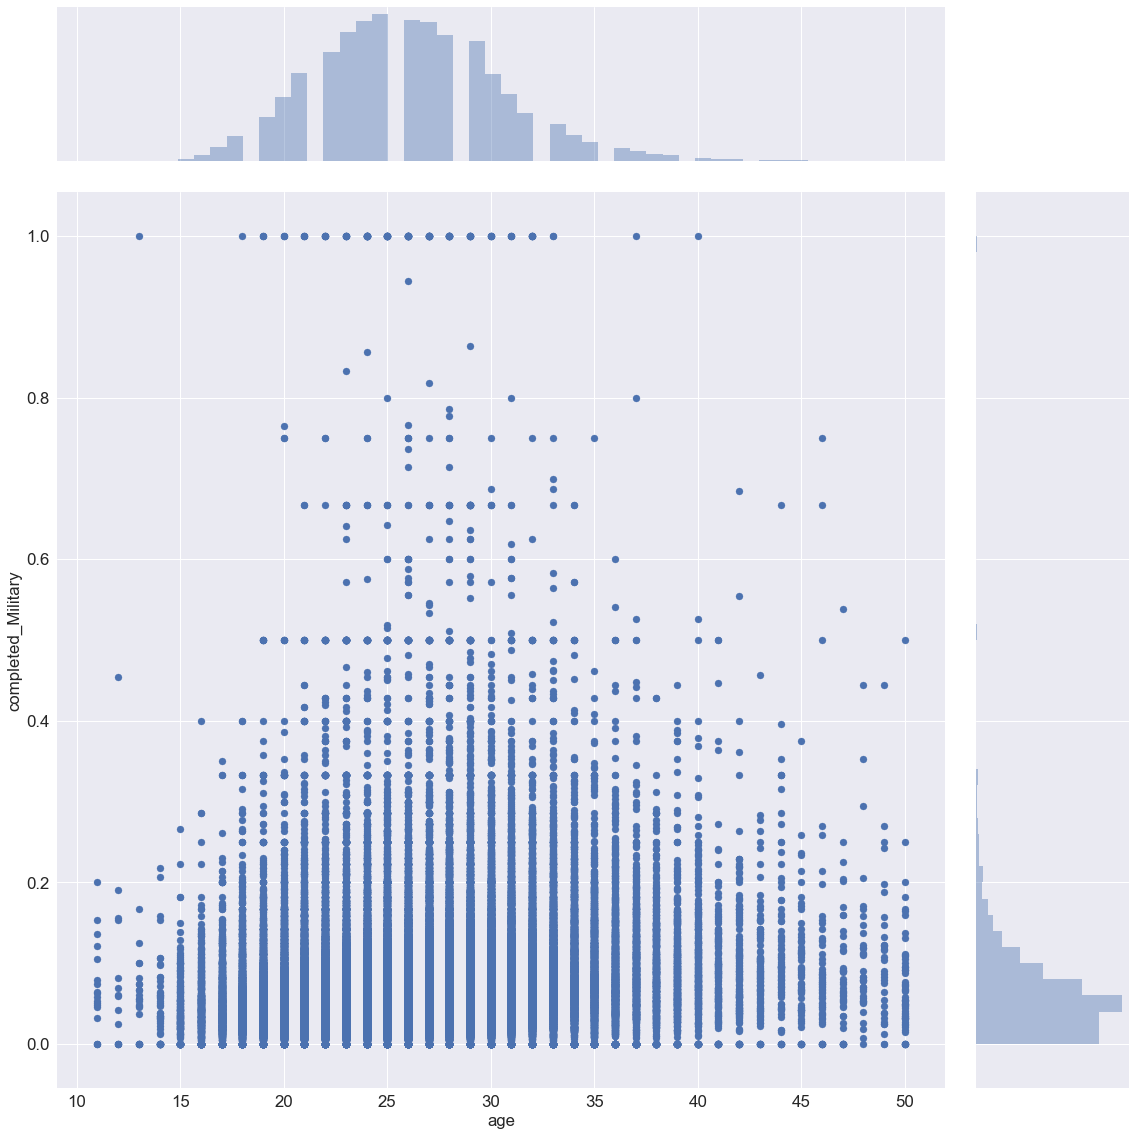

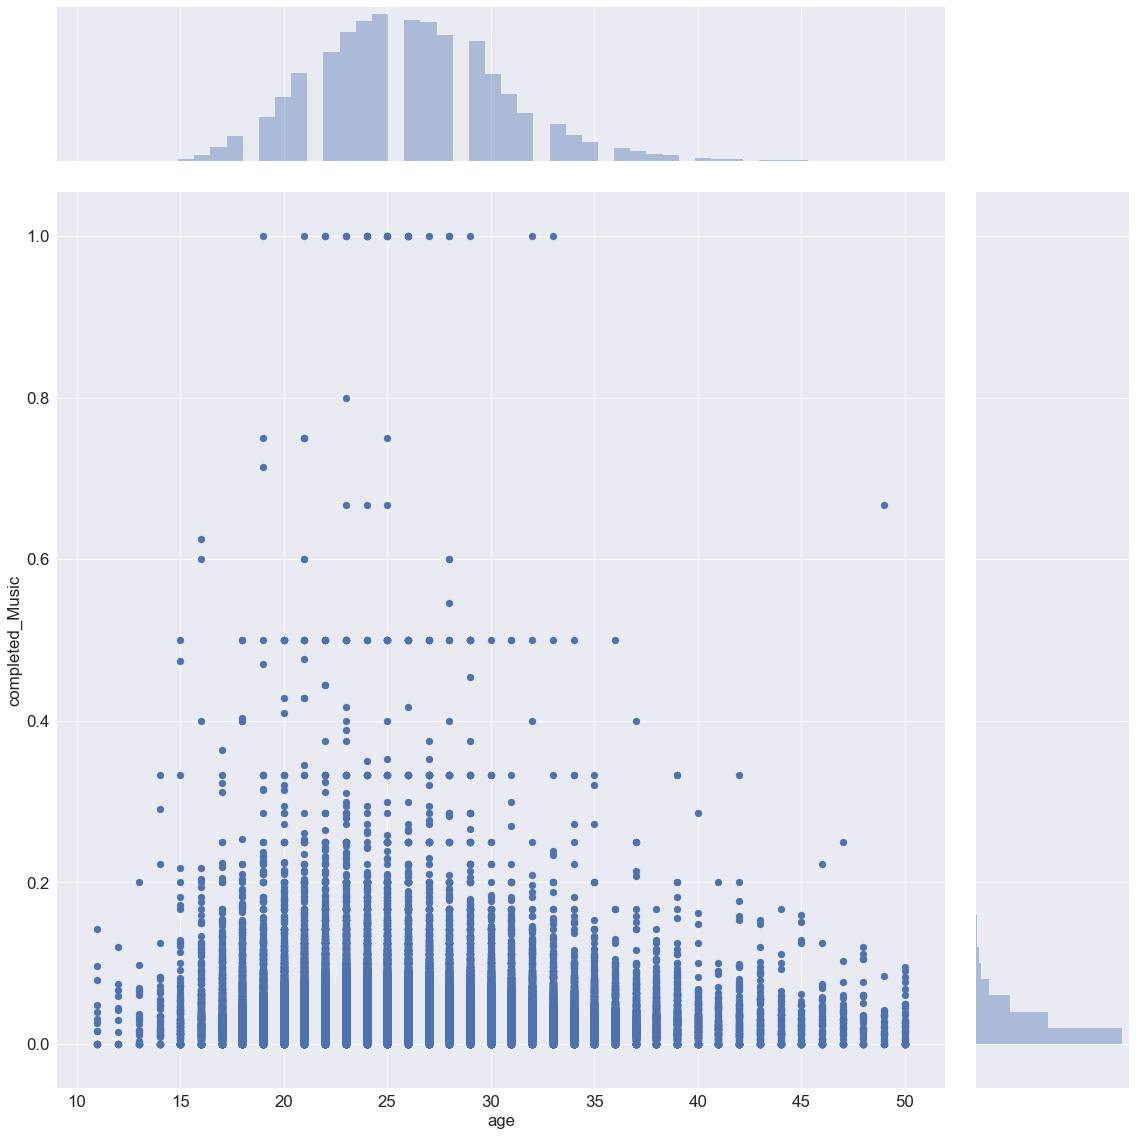

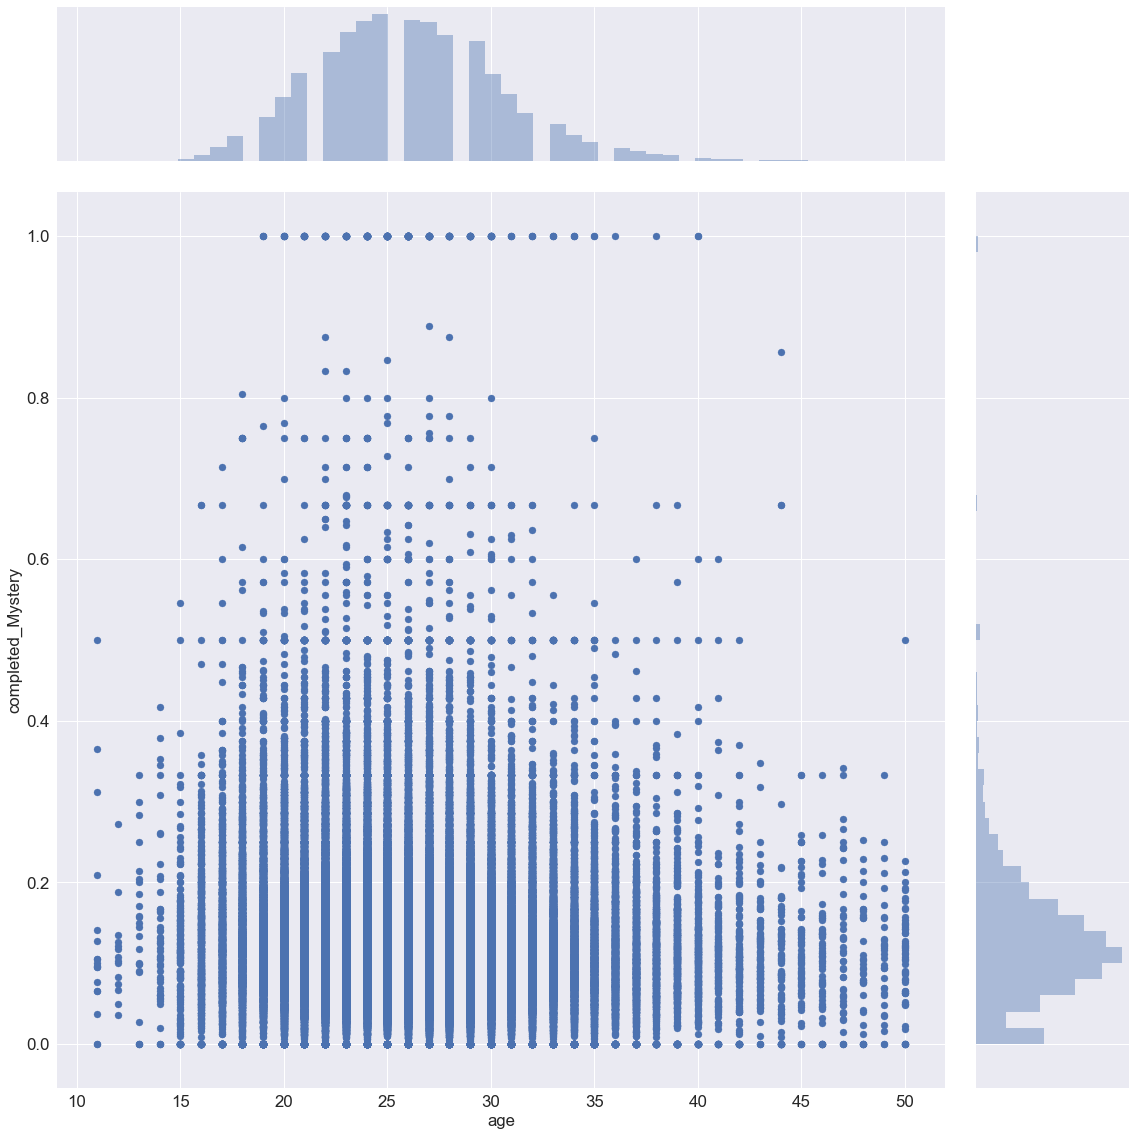

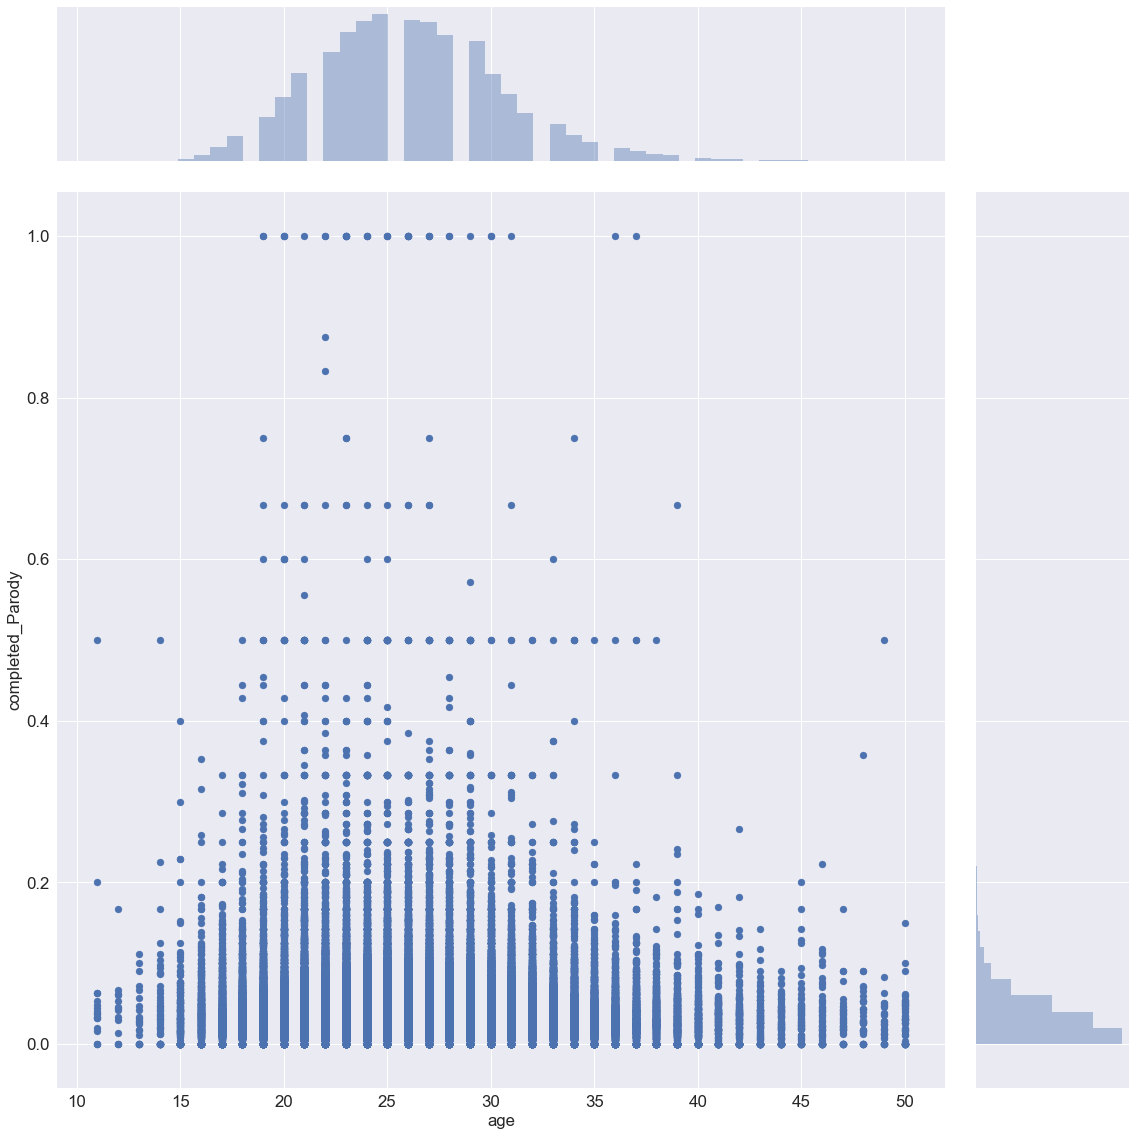

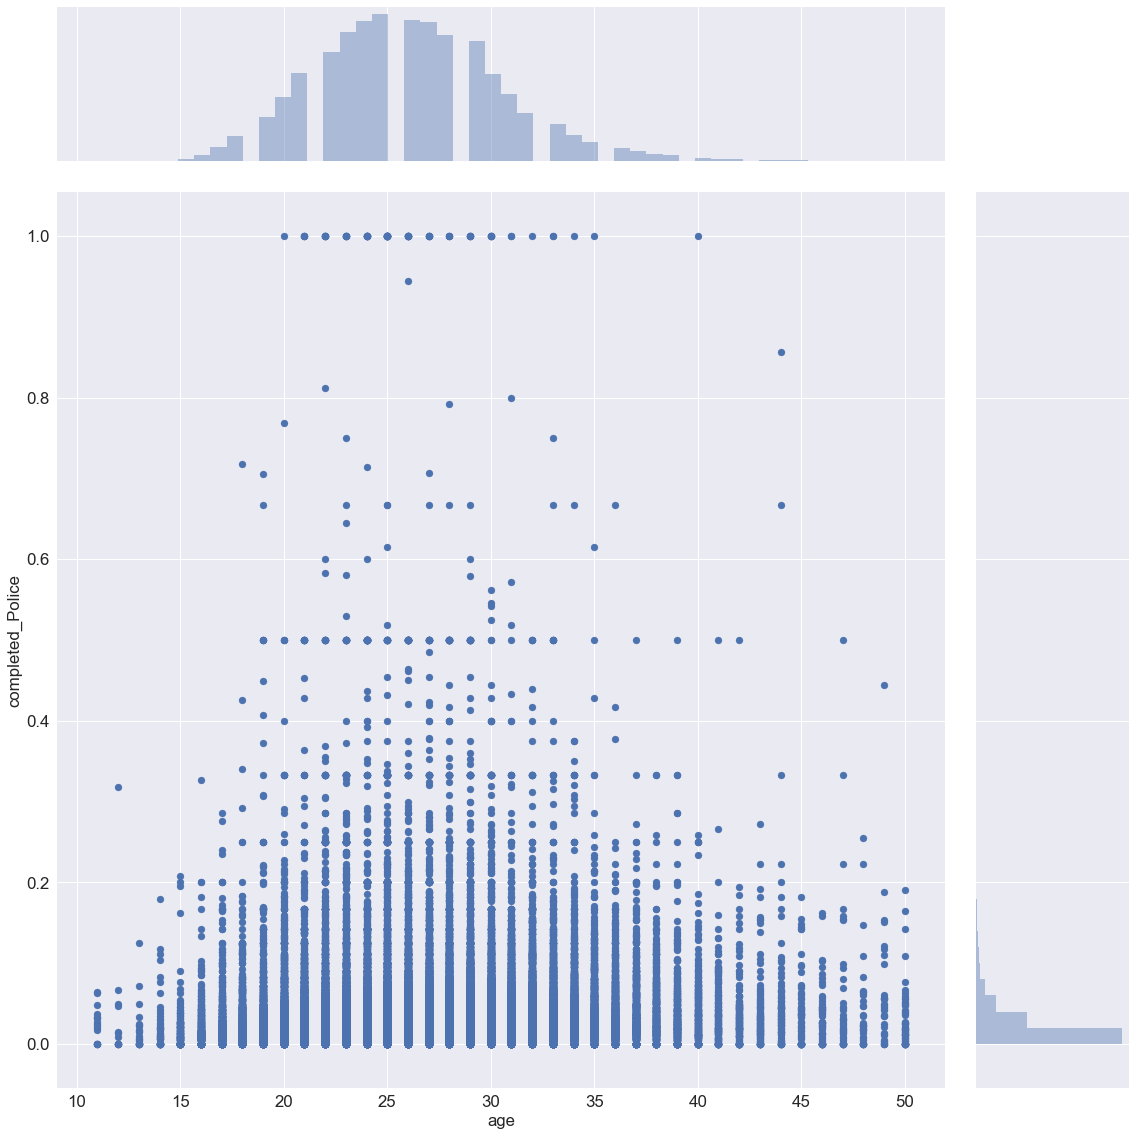

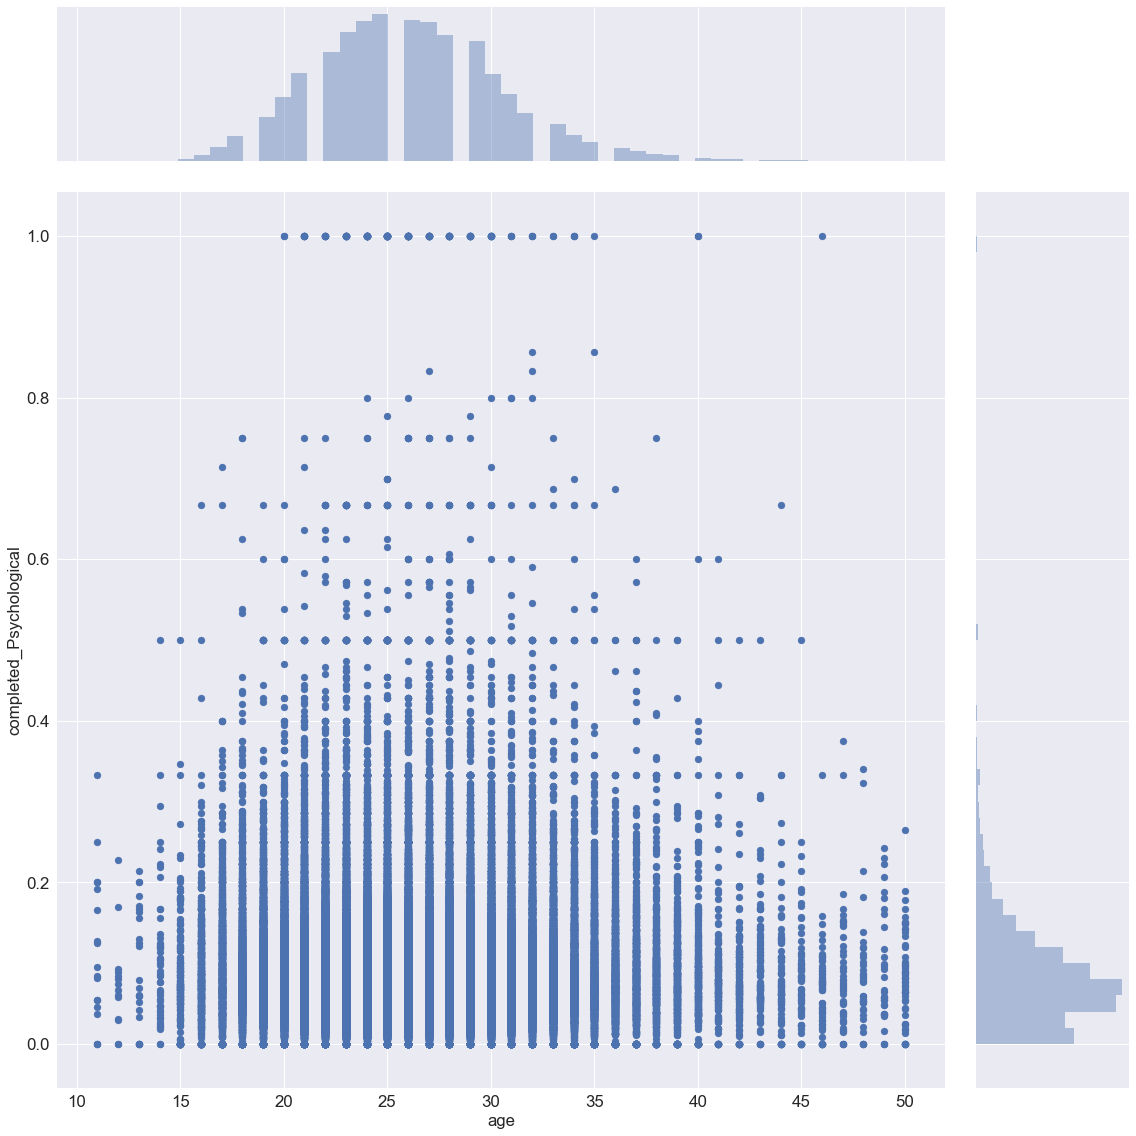

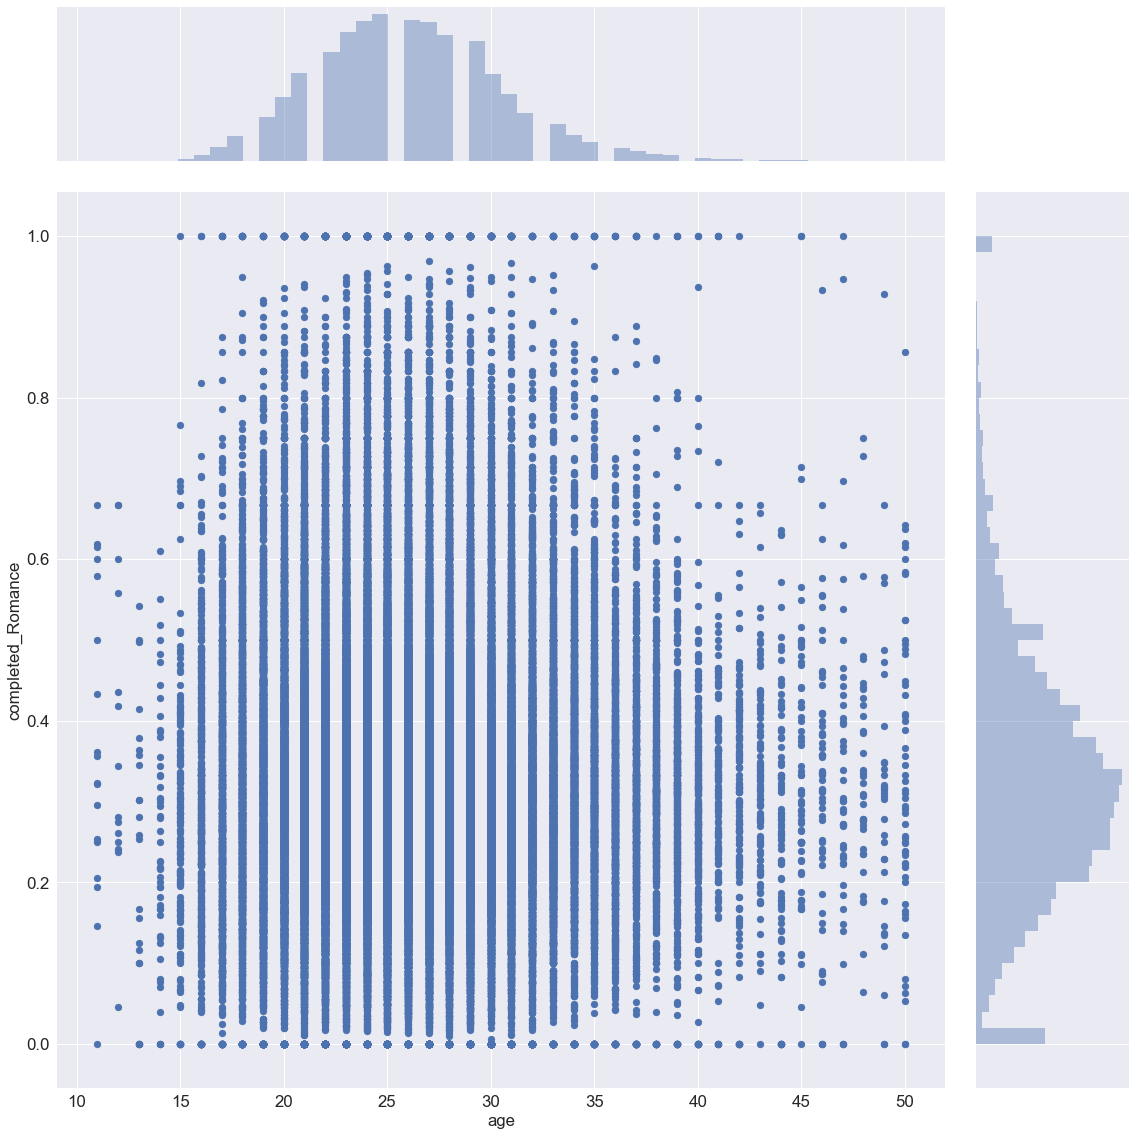

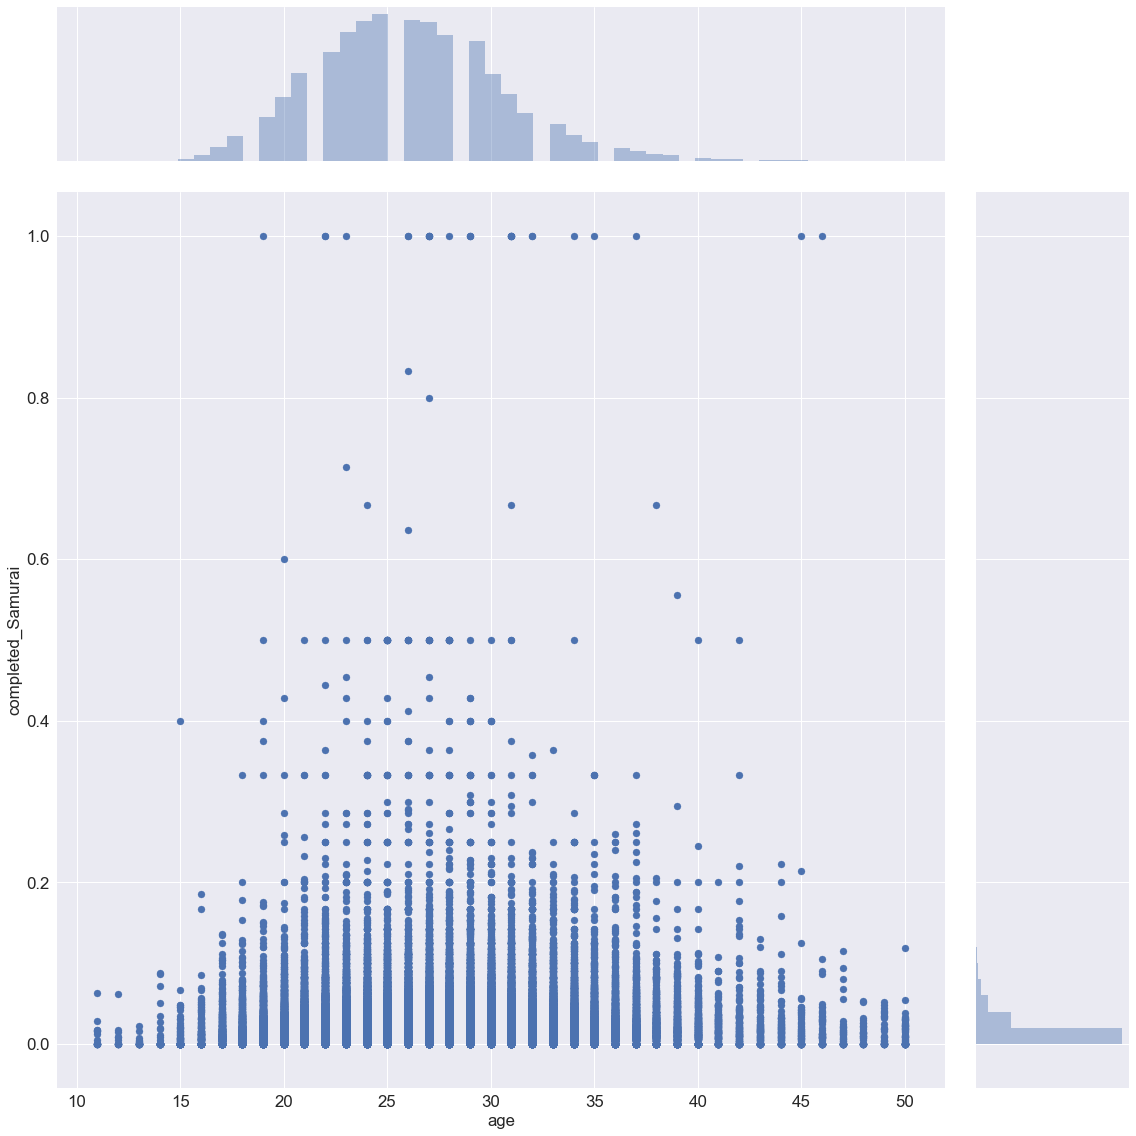

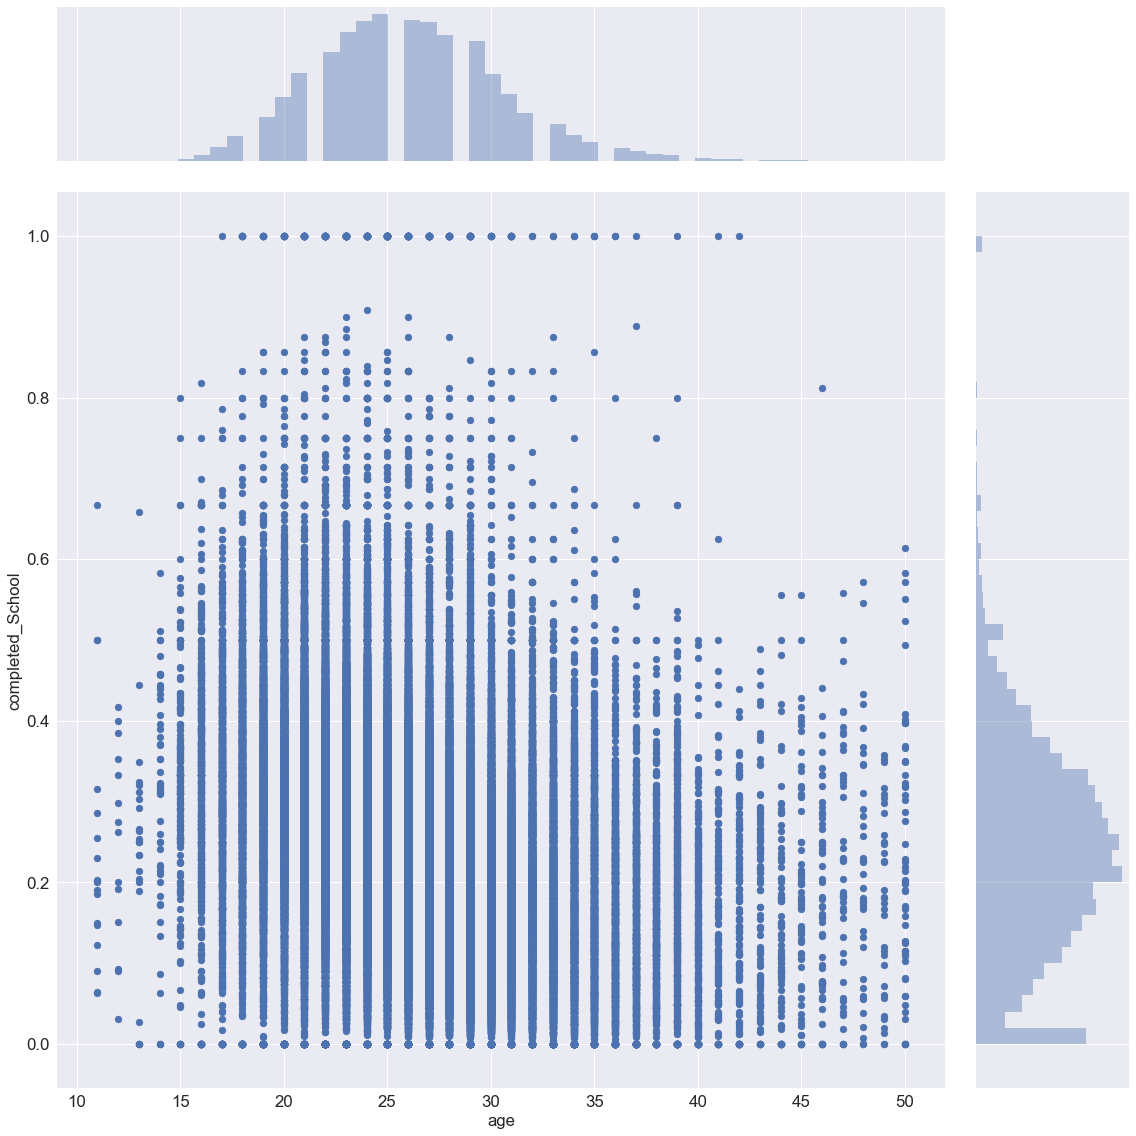

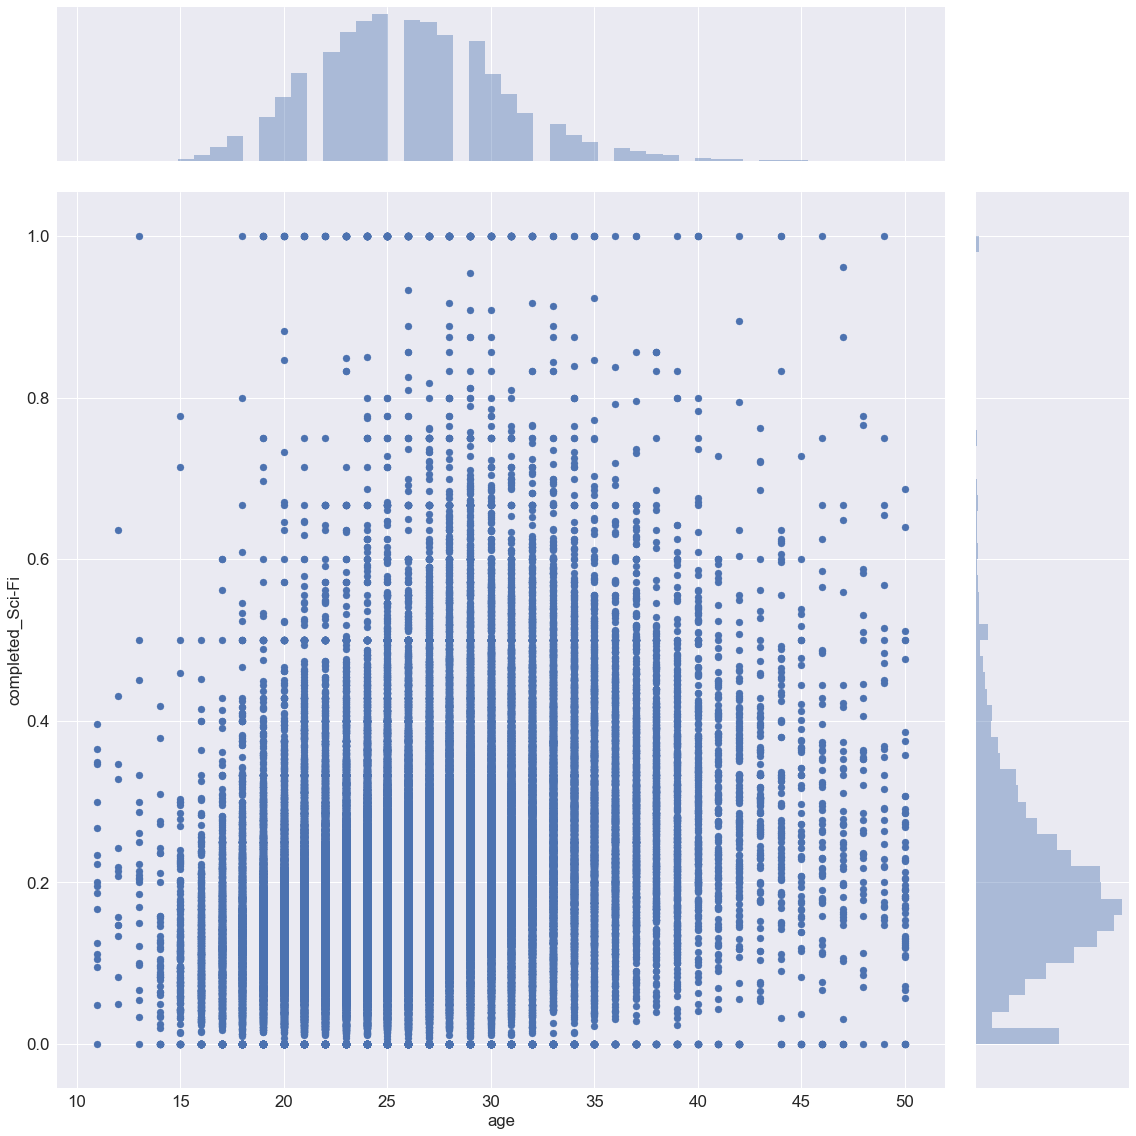

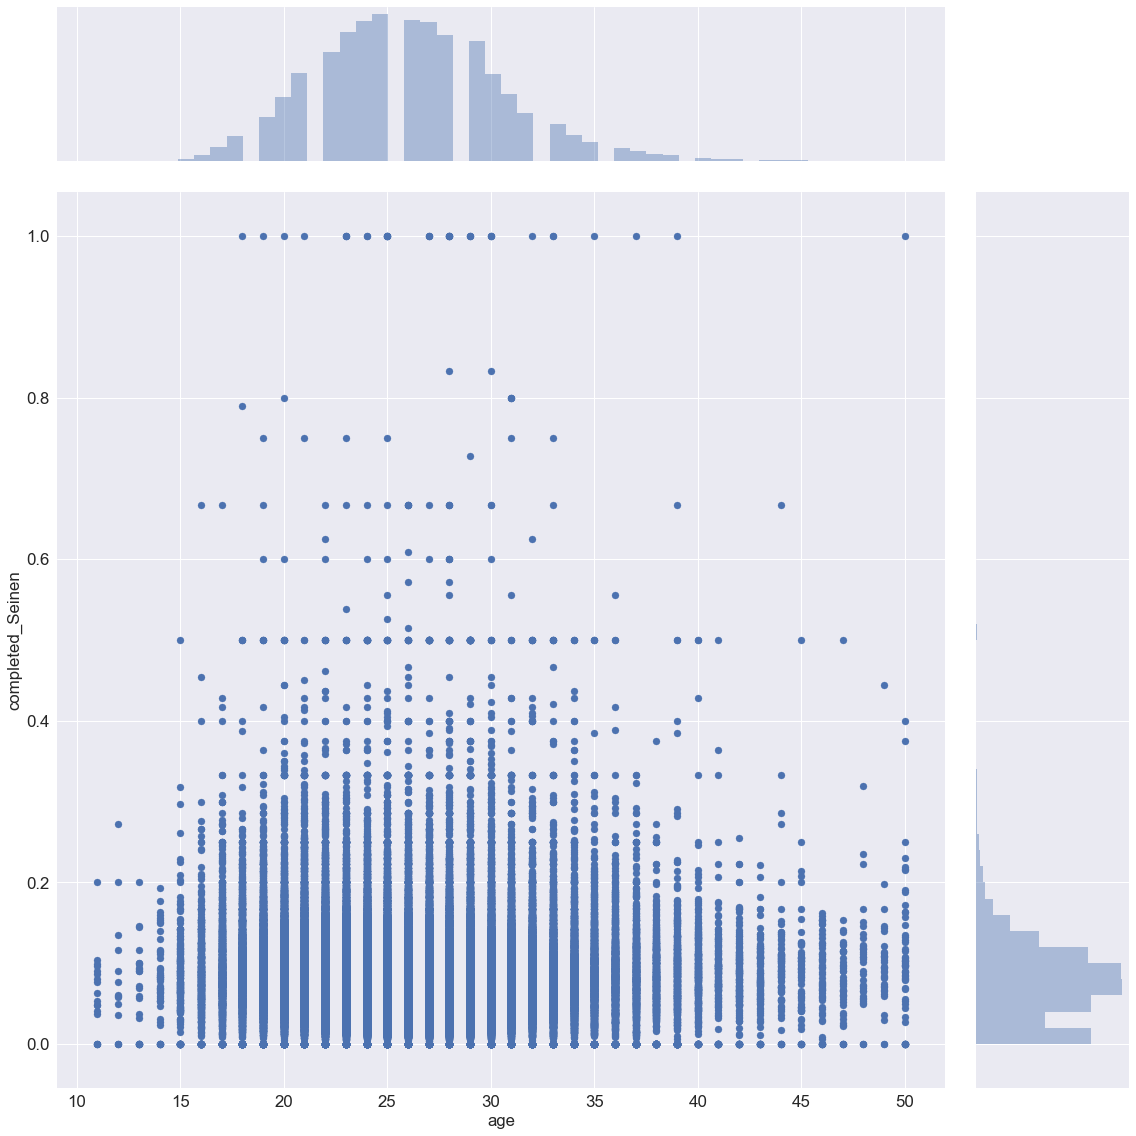

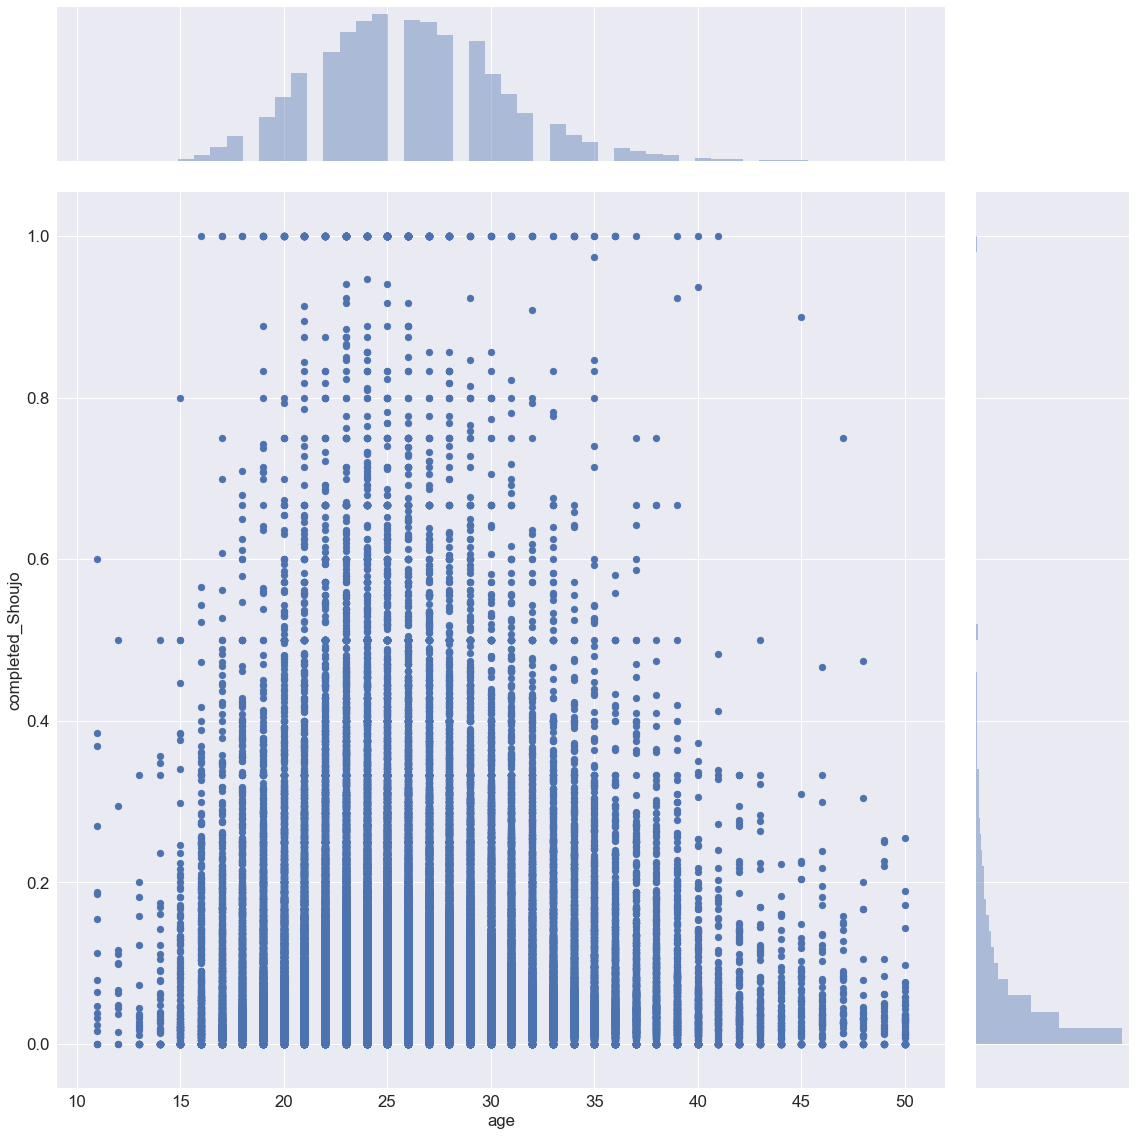

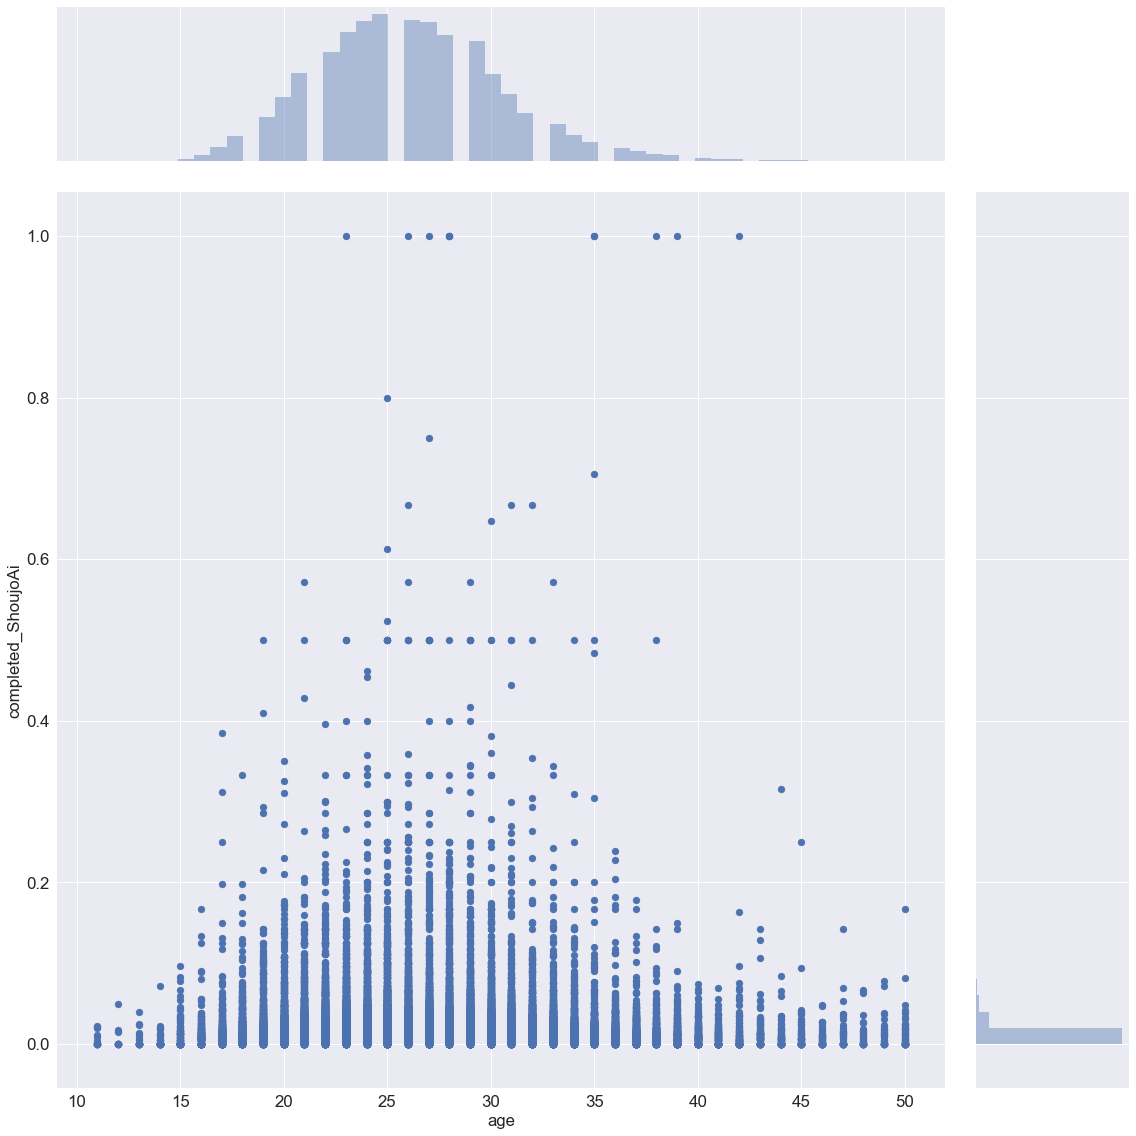

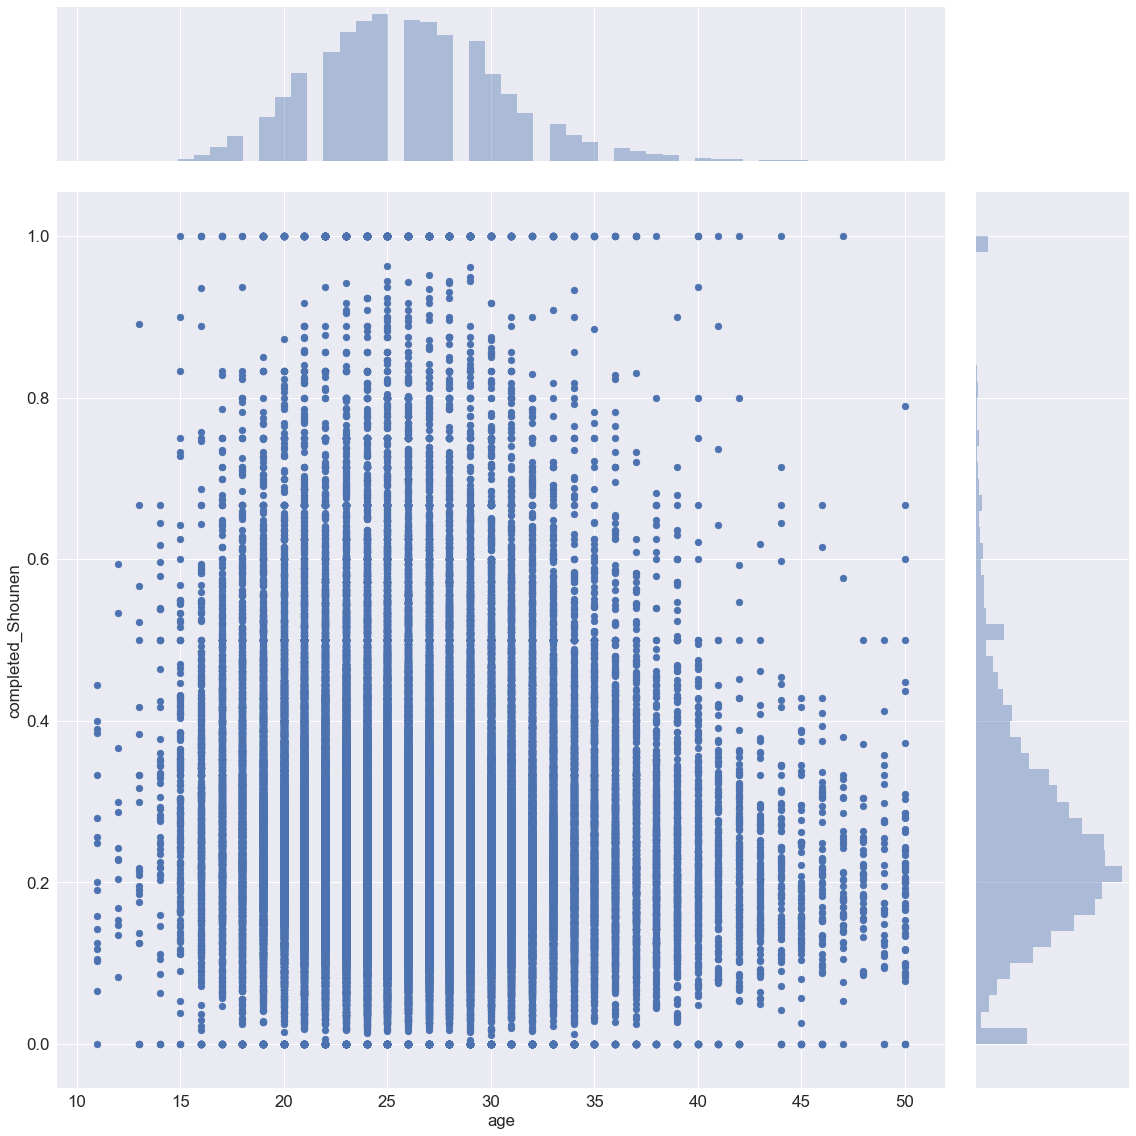

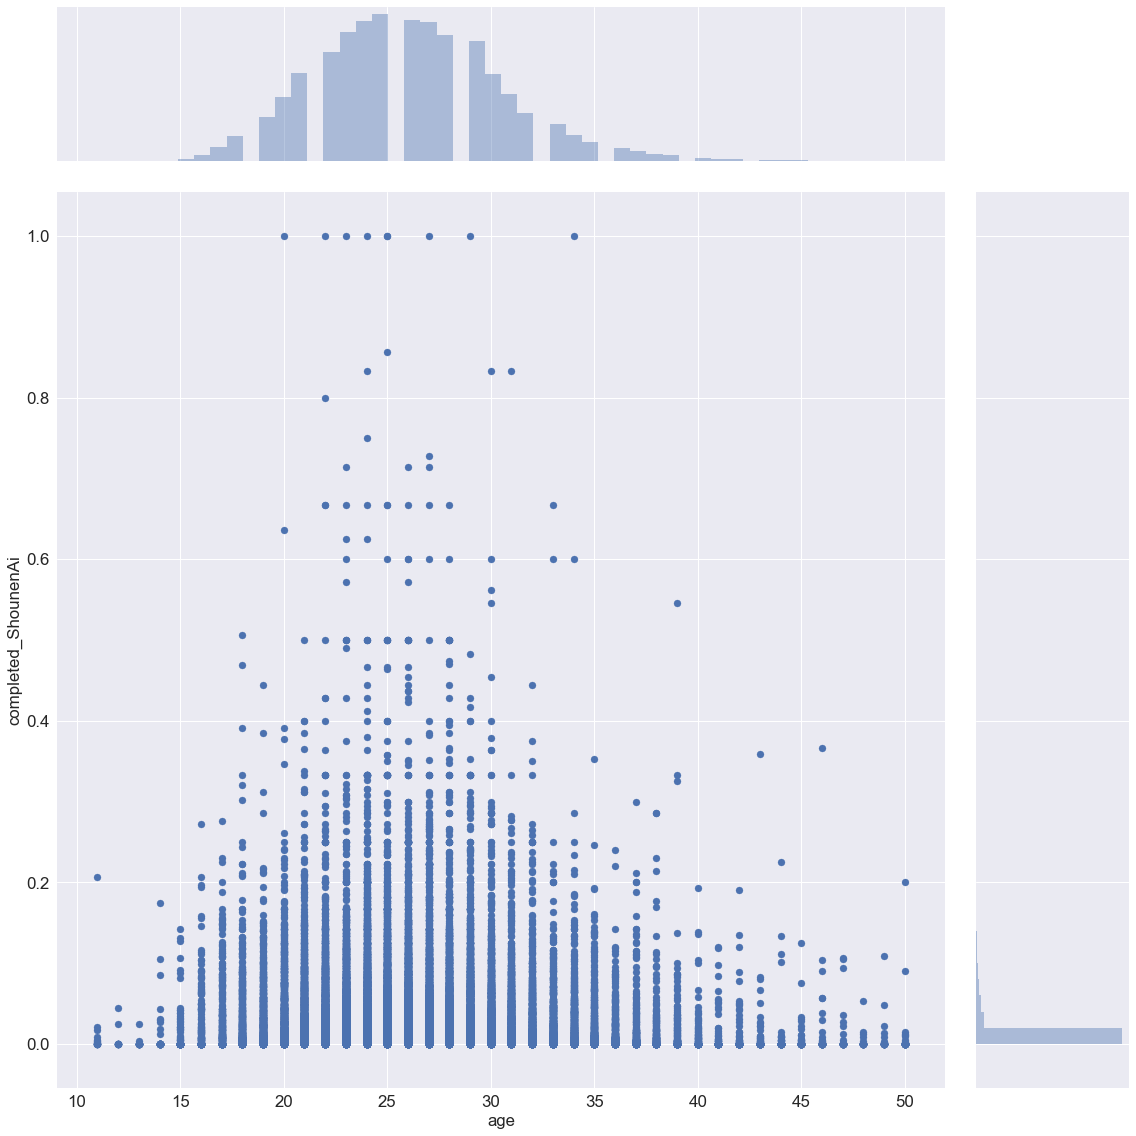

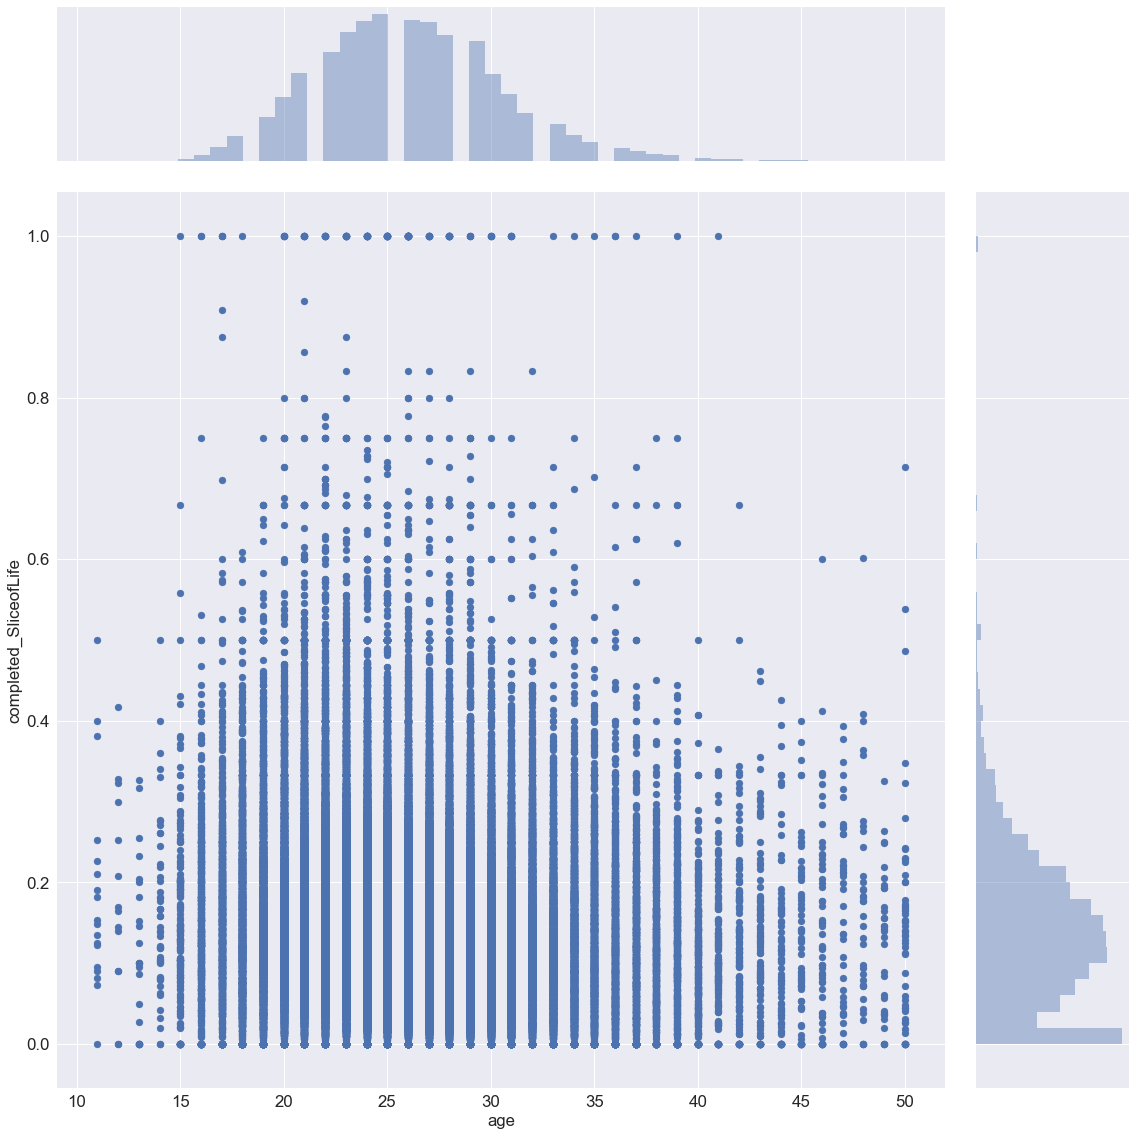

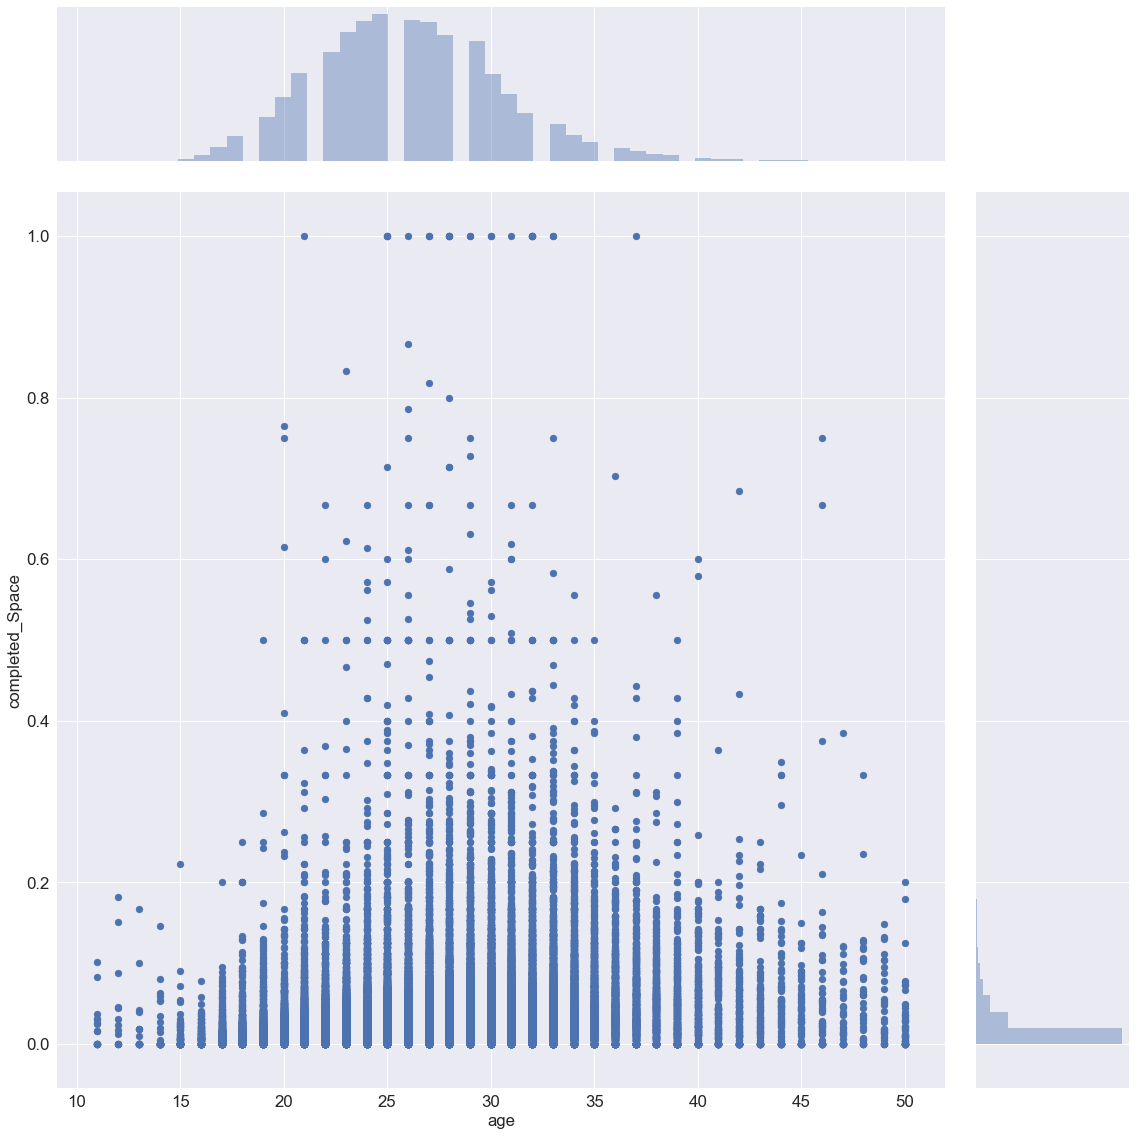

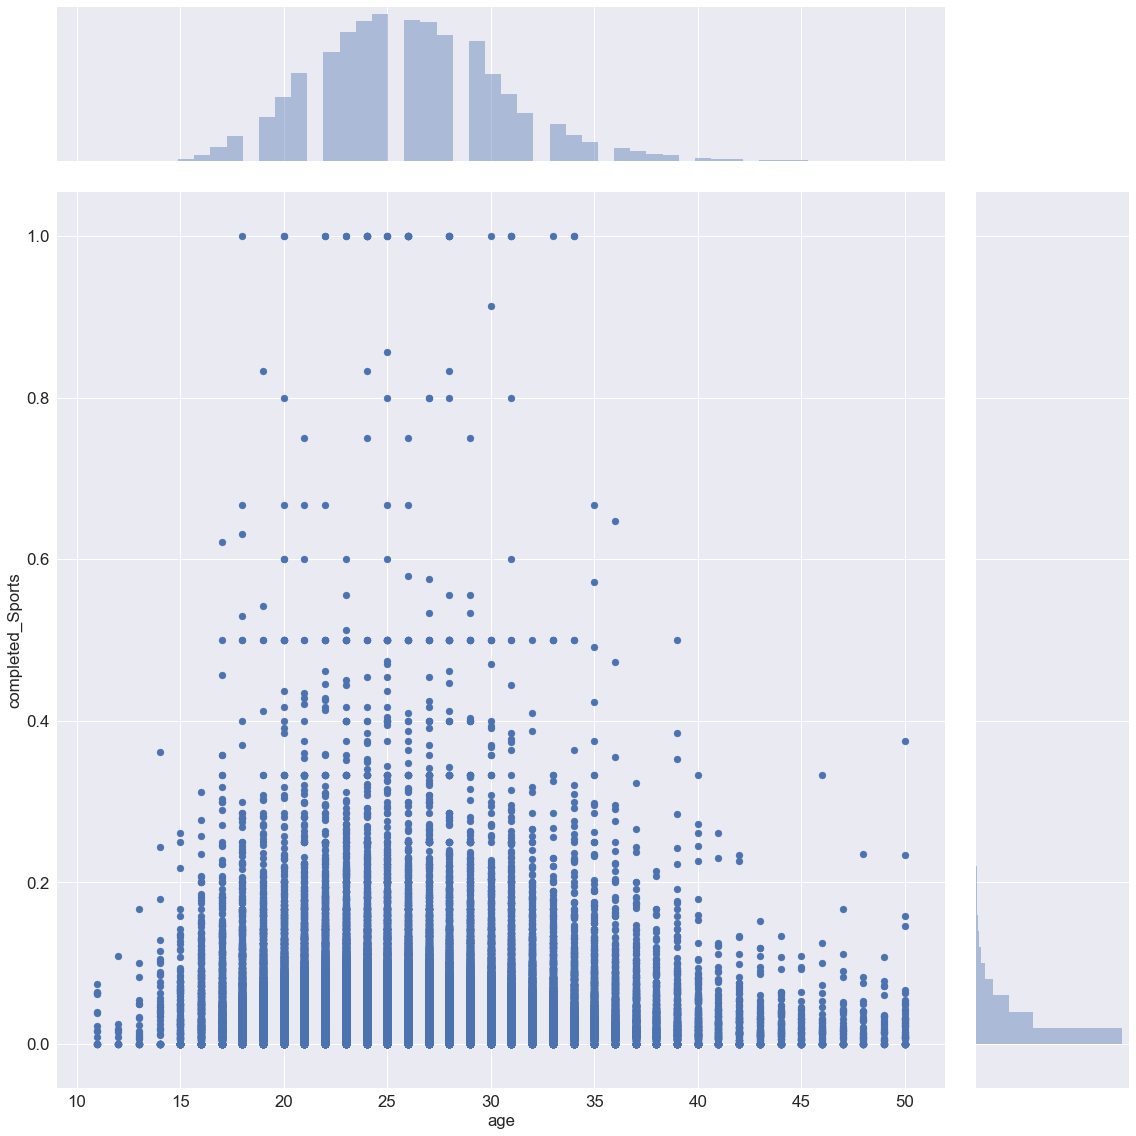

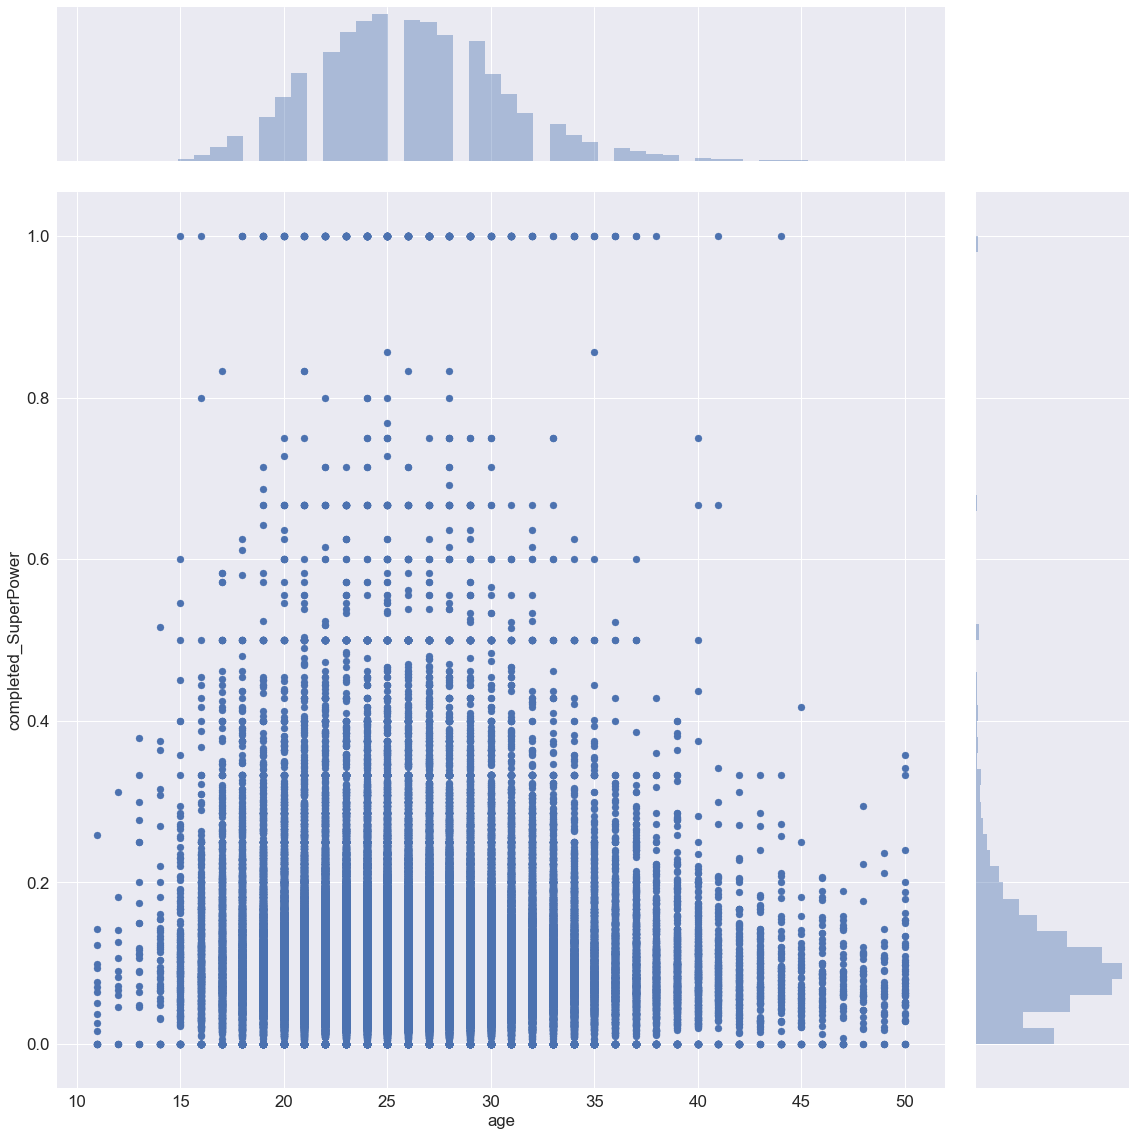

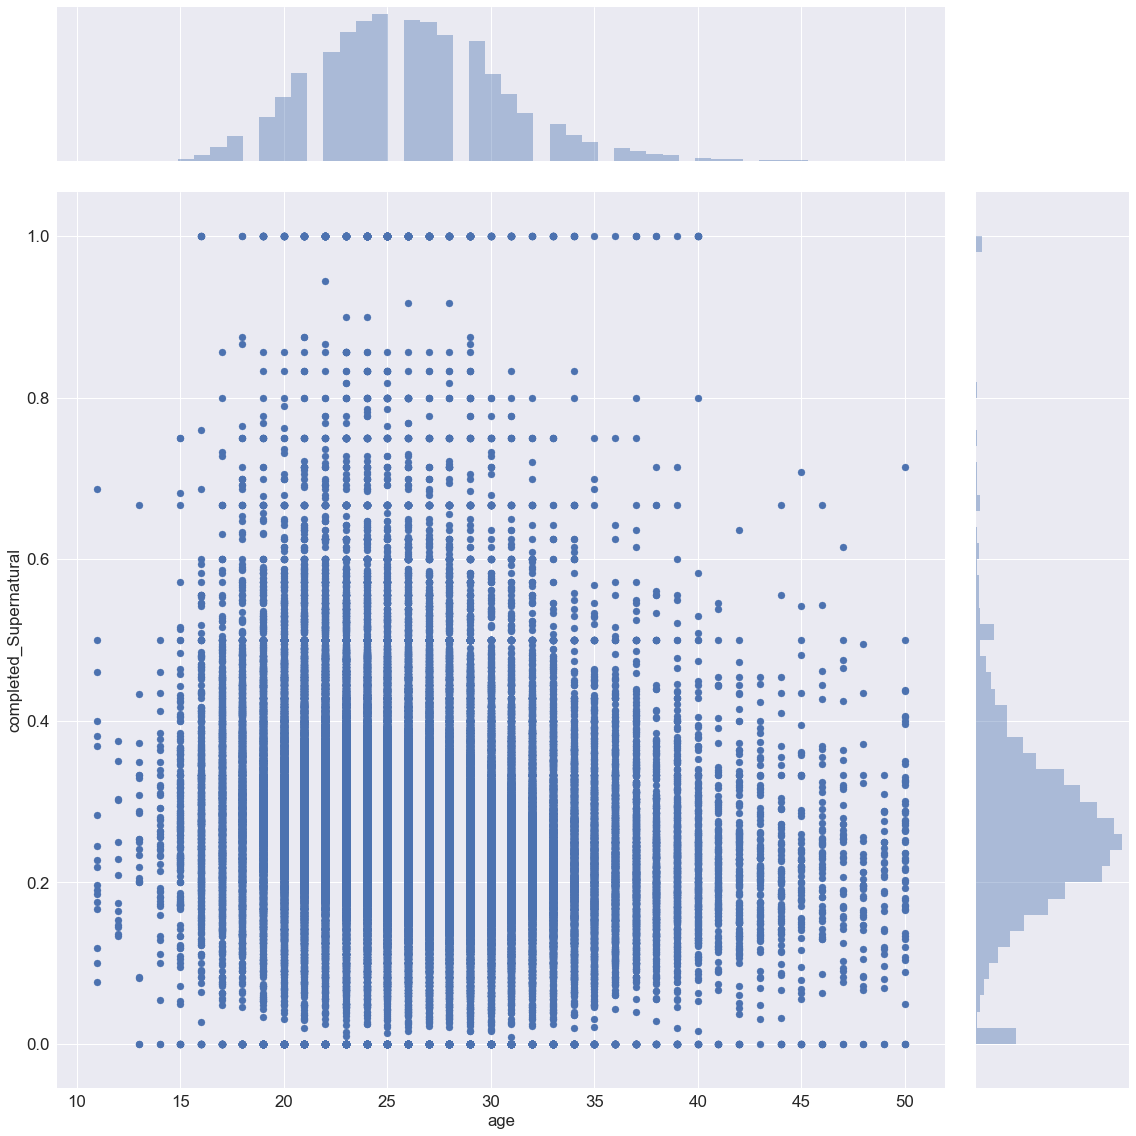

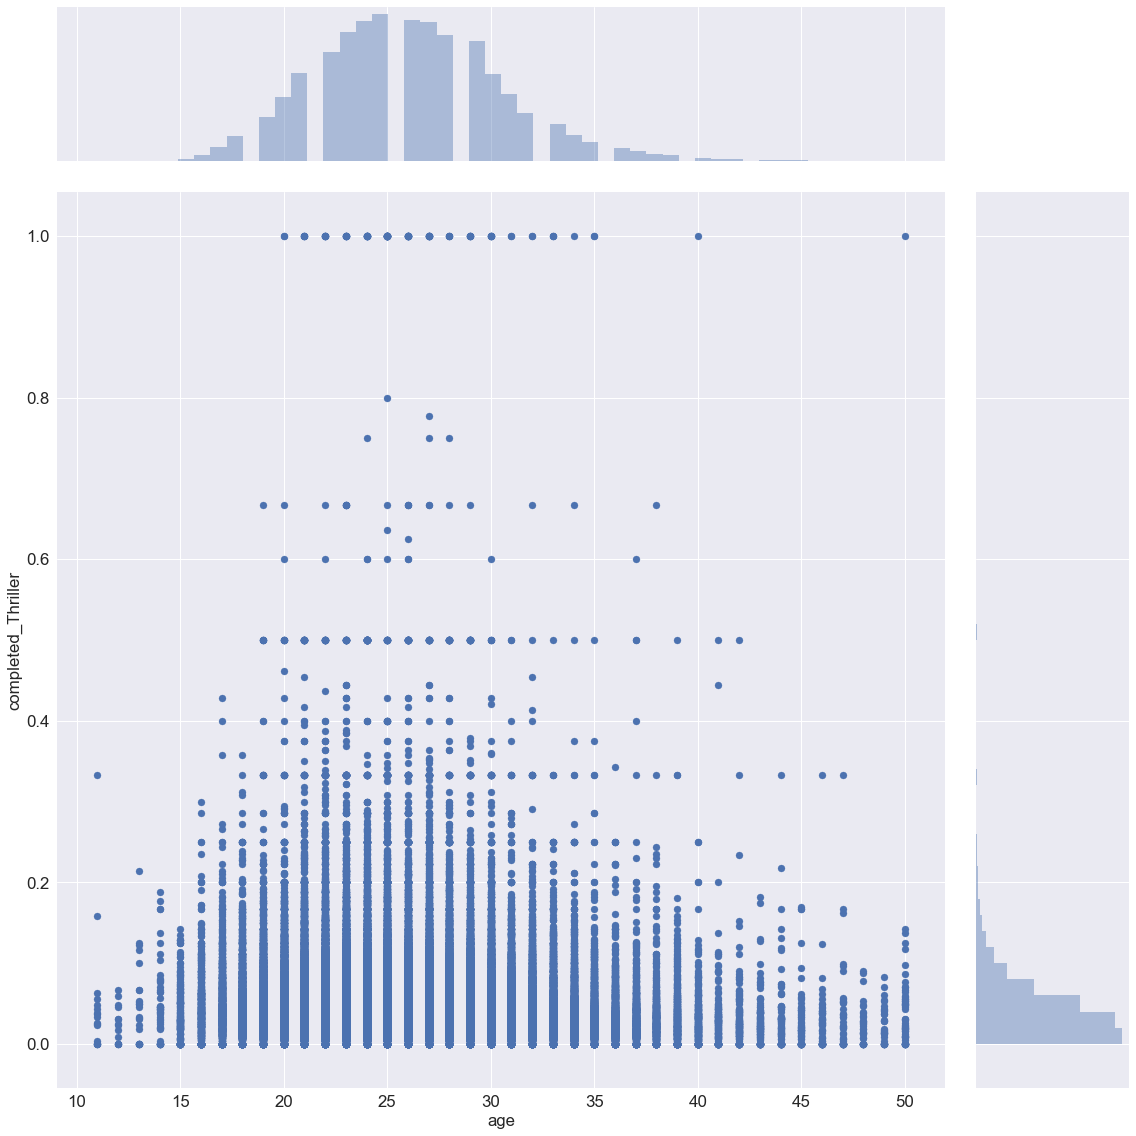

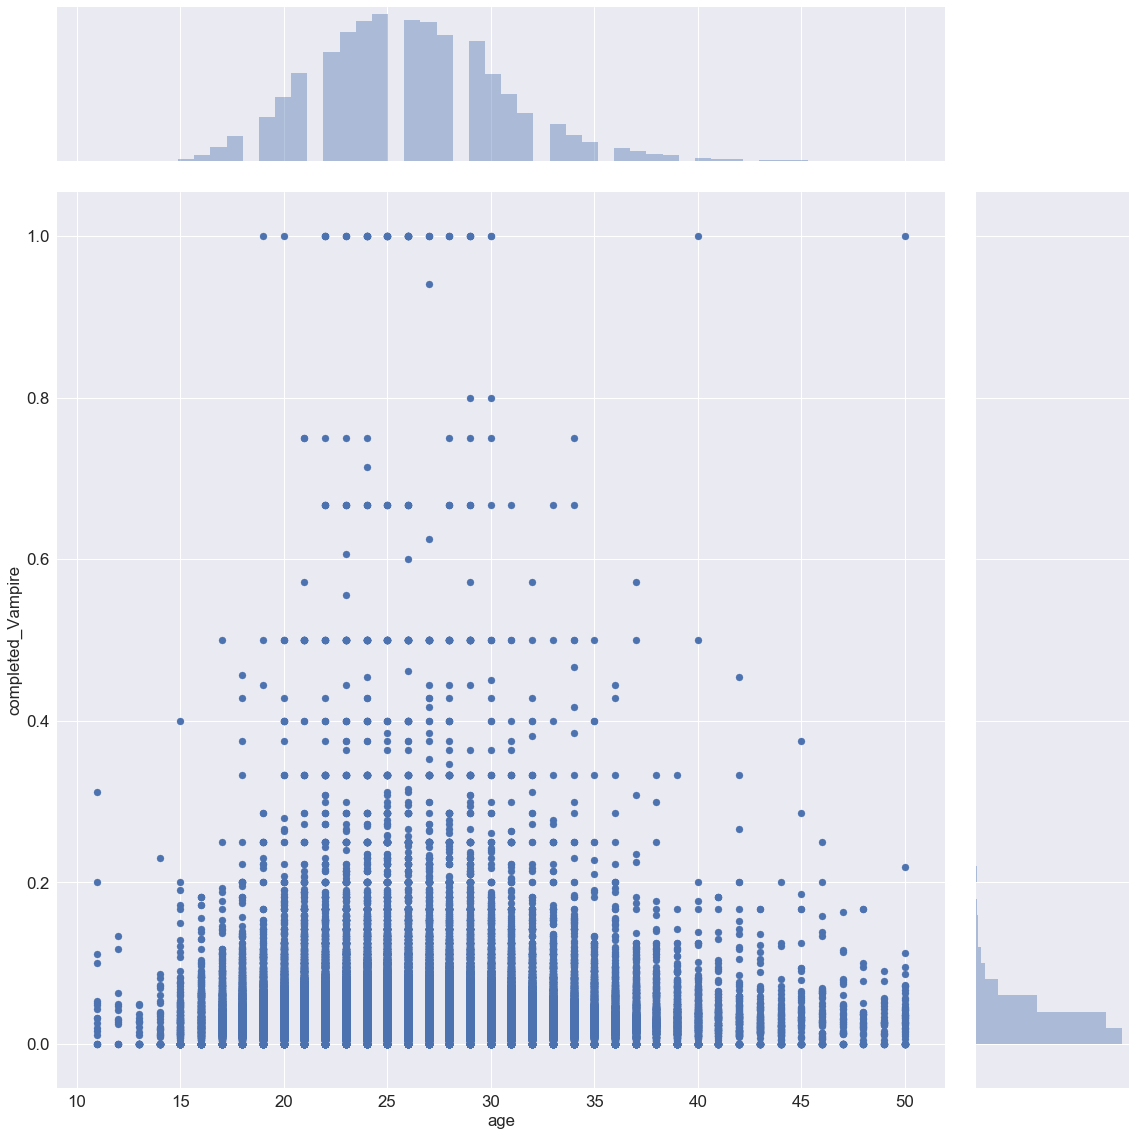

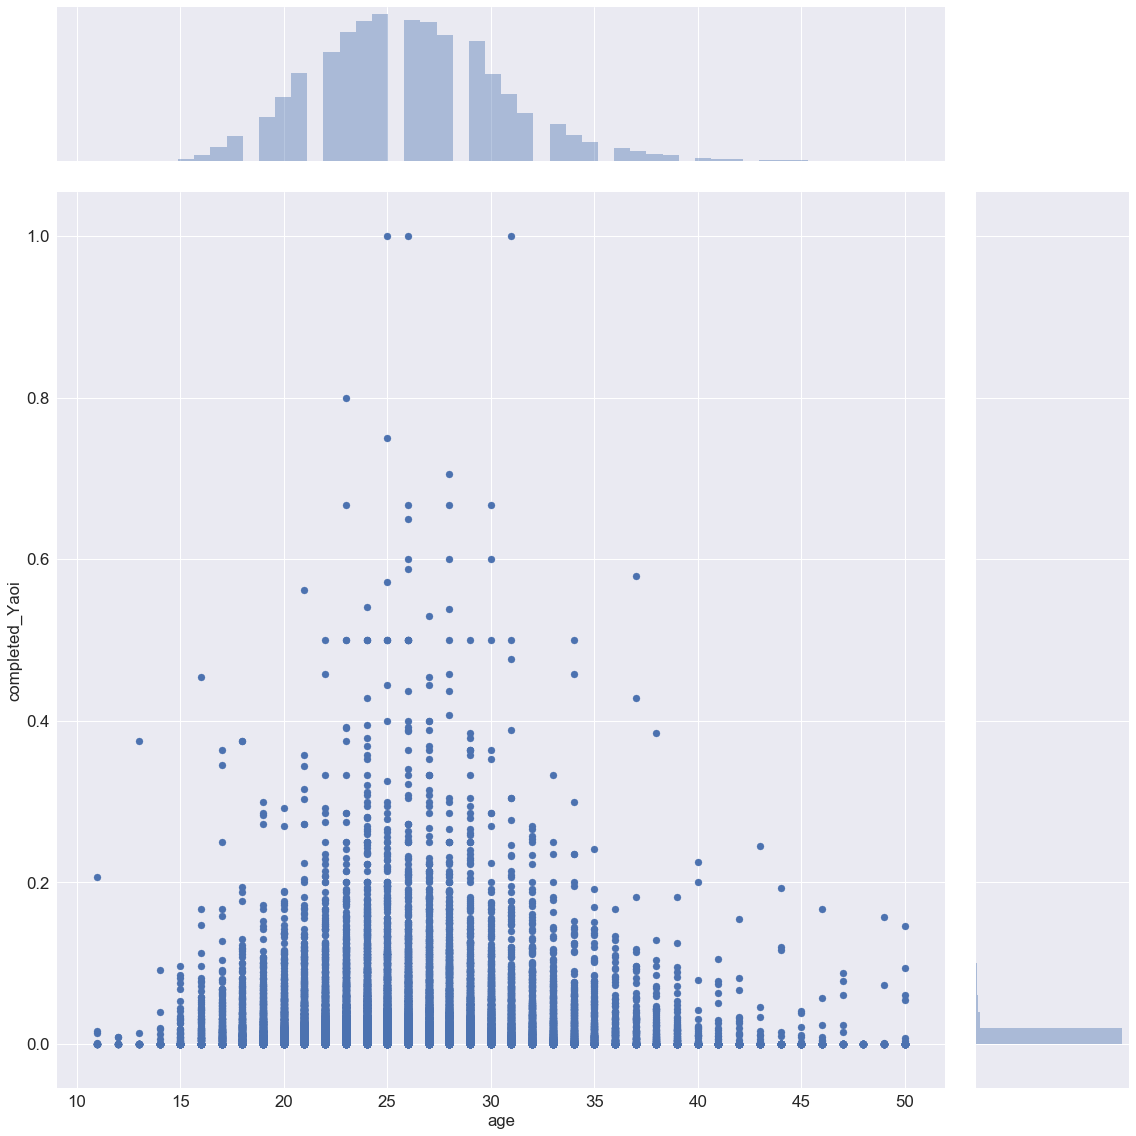

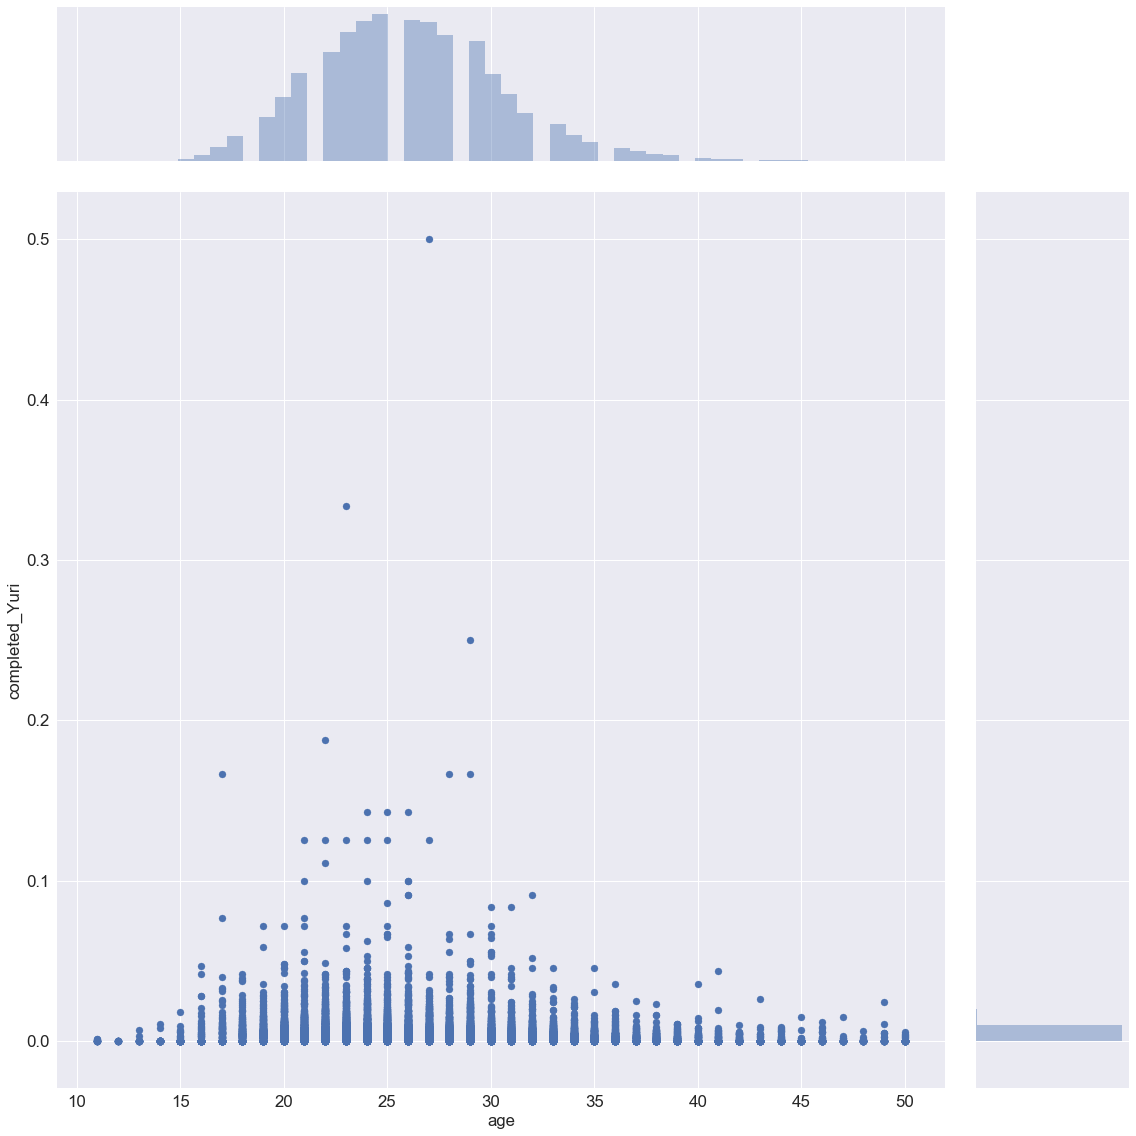

In [30]:
for genre in completed_columns:
    sns.jointplot(x='age', y=genre, data=users_ages_completed, height=16)
    plt.show()

In [31]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='scatter')

In [32]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='reg')

In [33]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='resid')

In [34]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='kde')

In [35]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='hex')

In [36]:
#sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16).plot_joint(sns.kdeplot, zorder=0, n_levels=20)

In [37]:
# entropy describes how many information it contains. Uniform distribution has highest entropy, dirac distribution lowest. 
# Lower entropy of genre means higher dependency on age
ages_genres[completed_columns].apply(entropy).sort_values()
# shows genres sorted by their dependency on age

completed_Cars             3.484776
completed_Space            3.492352
completed_Samurai          3.563545
completed_Yaoi             3.565160
completed_Mecha            3.584885
completed_Game             3.588596
completed_Kids             3.594614
completed_Yuri             3.598857
completed_Hentai           3.607686
completed_Police           3.624829
completed_Dementia         3.627799
completed_ShounenAi        3.634965
completed_ShoujoAi         3.641704
completed_Sci-Fi           3.644152
completed_Historical       3.648531
completed_Military         3.650001
completed_Josei            3.655107
completed_School           3.659287
completed_Sports           3.662839
completed_Thriller         3.663008
completed_Shoujo           3.664714
completed_Harem            3.667415
completed_Vampire          3.667830
completed_MartialArts      3.668790
completed_Parody           3.674241
completed_Demons           3.674993
completed_Music            3.675950
completed_SuperPower       3

In [38]:
arr = np.ones(ages_genres.index.size)
entropy(arr / arr.sum())

3.6888794541139363

In [150]:
dependent_genres = ages_genres[completed_columns].apply(entropy).sort_values().index[0:6]

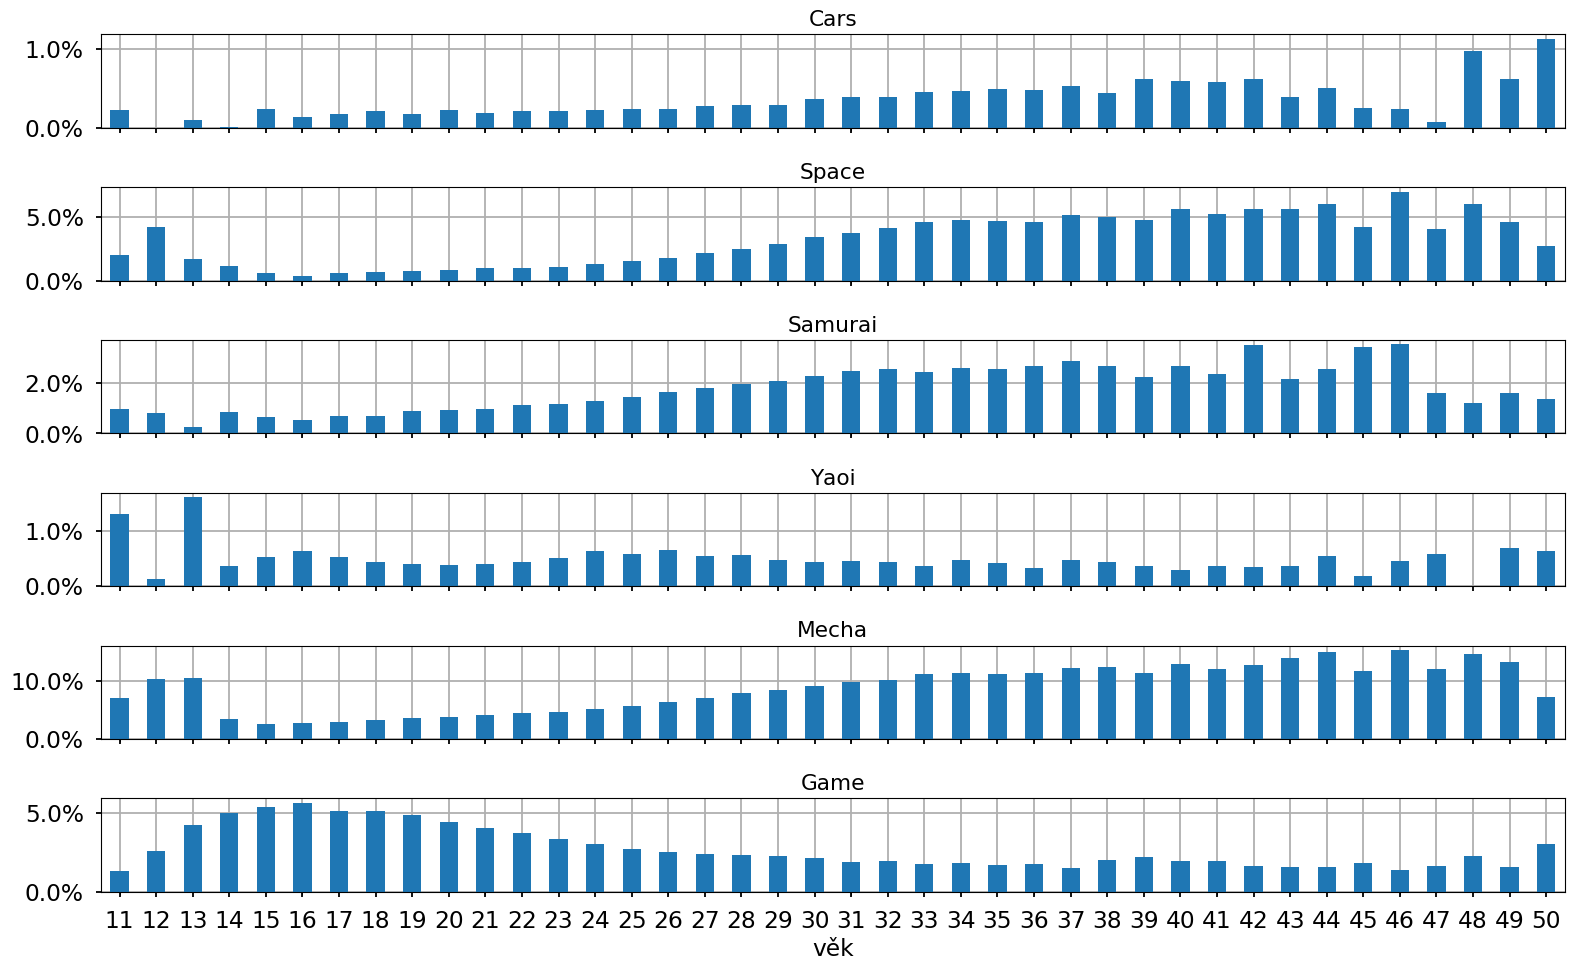

In [151]:
fig, ax = plt.subplots(len(dependent_genres), 1, sharex=True, figsize=(16, 10))
for i, genre in enumerate(dependent_genres):
    ages_genres[genre].plot(kind='bar', ax=ax[i], title=genre.replace('completed_', ''))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.tight_layout()
plt.xticks(rotation=0)
plt.xlabel('věk')
plt.savefig('graphs/uzivatele-vek-nejrozdilnejsi-bar.png', bbox_inches='tight')

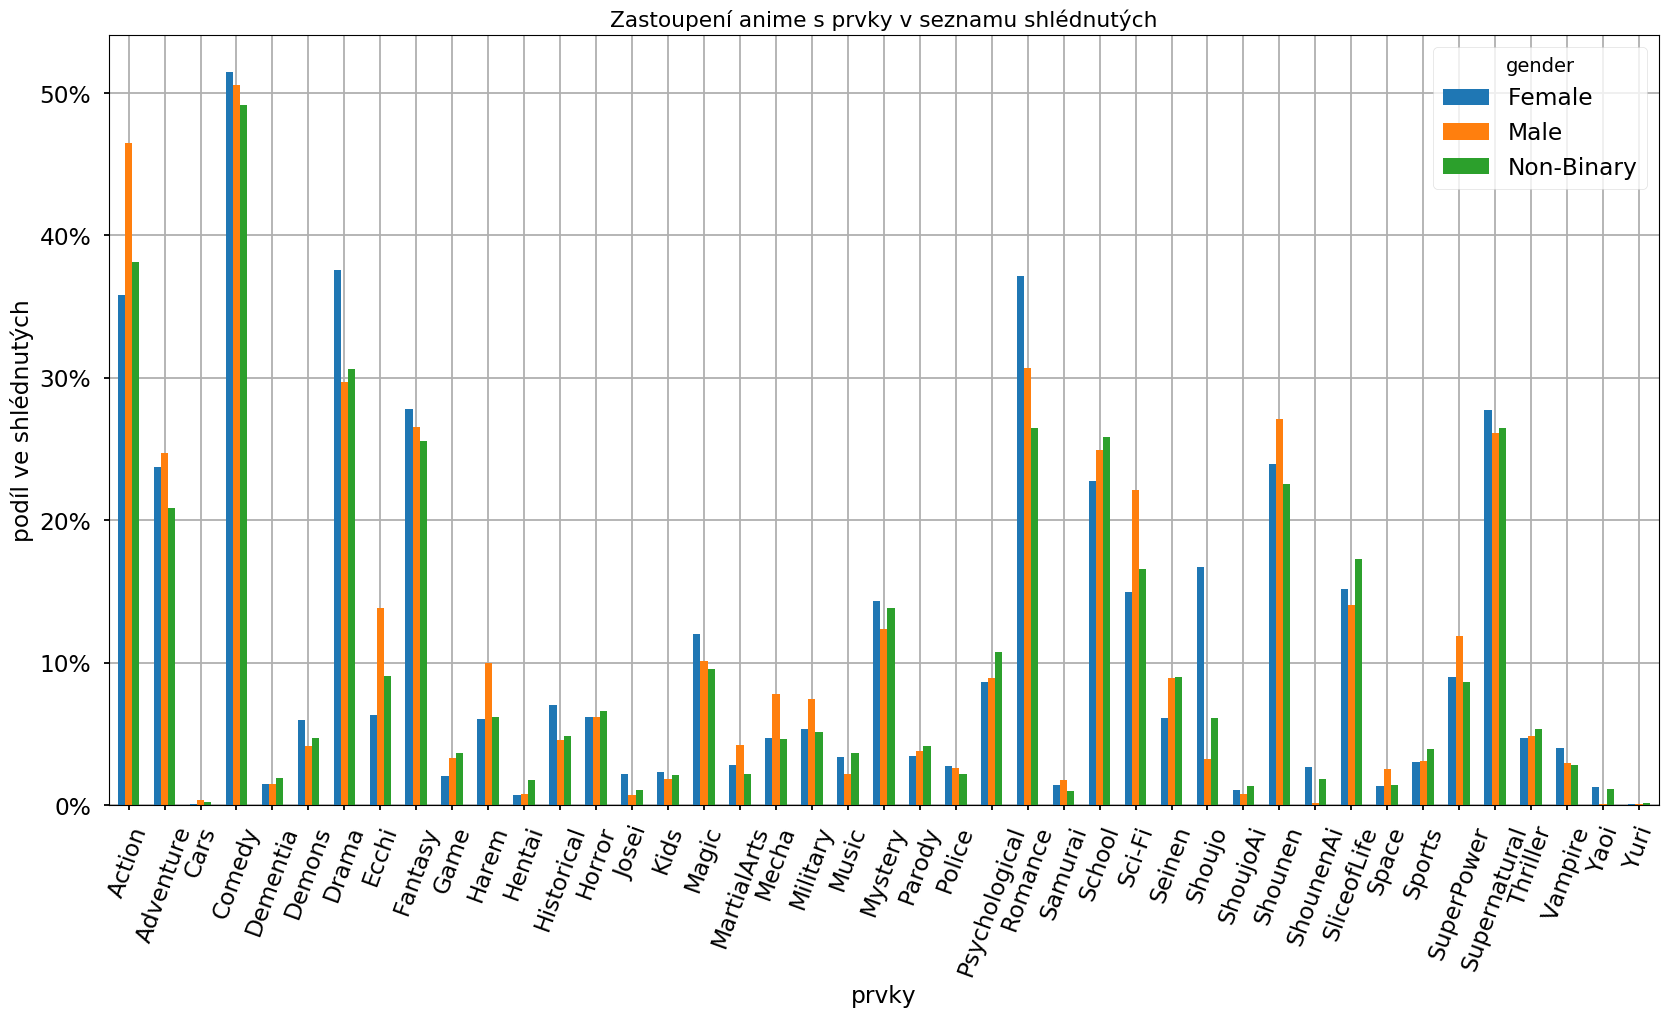

In [157]:
genders_genres.T.plot(kind='bar', figsize=(20, 10), width=0.6)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: genders_genres.columns[y].replace('completed_', '')))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.title('Zastoupení anime s prvky v seznamu shlédnutých')
plt.xticks(rotation=70)
plt.ylabel('podíl ve shlédnutých')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-pohlavi-bar.png', bbox_inches='tight')

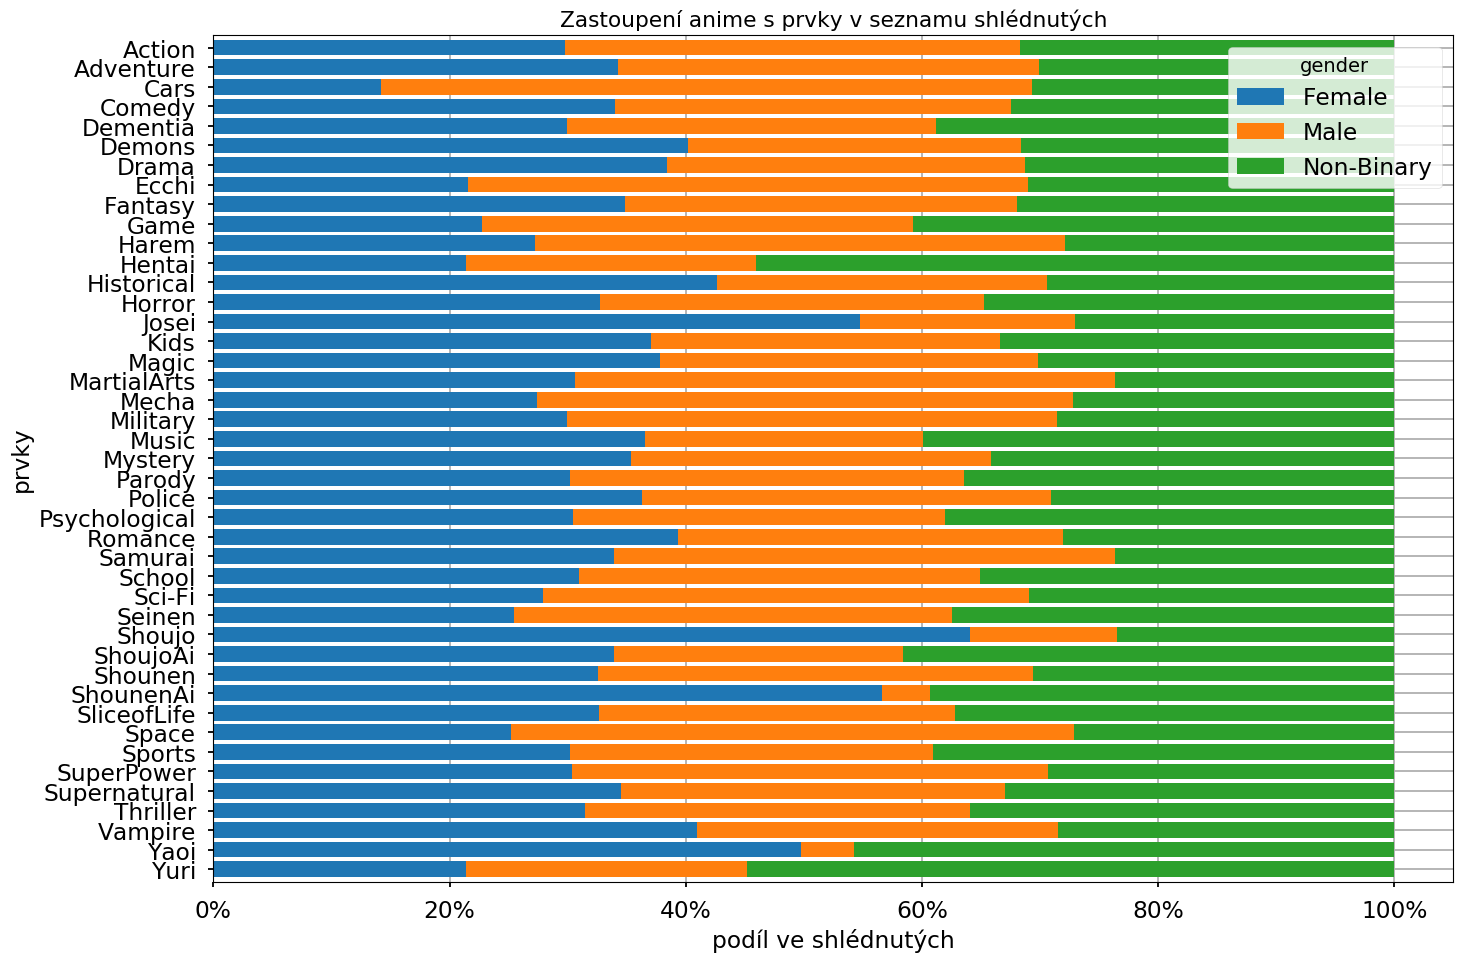

In [191]:
genders_genres.div(genders_genres.sum(axis=0), axis=1).T.sort_index(ascending=False).plot(kind='barh', figsize=(16, 11), stacked=True, width=0.8)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: genders_genres.columns.sort_values(ascending=False)[y].replace('completed_', '')))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.title('Zastoupení anime s prvky v seznamu shlédnutých')
plt.xticks(rotation=0)
plt.xlabel('podíl ve shlédnutých')
plt.ylabel('prvky')
plt.savefig('graphs/uzivatele-pohlavi-barh-normed.png', bbox_inches='tight')

In [192]:
genders_genres

completed_Action  completed_Adventure  completed_Cars  \
gender                                                              
Female              0.357806             0.237703        0.000953   
Male                0.464505             0.247508        0.003698   
Non-Binary          0.381215             0.208710        0.002063   

            completed_Comedy  completed_Dementia  completed_Demons  \
gender                                                               
Female              0.514789            0.014539          0.059669   
Male                0.505912            0.015203          0.041891   
Non-Binary          0.491372            0.018845          0.046933   

            completed_Drama  completed_Ecchi  completed_Fantasy  \
gender                                                            
Female             0.375588         0.063029           0.278374   
Male               0.296853         0.138605           0.265483   
Non-Binary         0.306425         0.090623           0.255745   

            completed_Game  ...  completed_ShounenAi  completed_SliceofLife  \
gender                      ...                                               
Female            0.020527  ...             0.026588               0.151860   
Male              0.032814  ...             0.001885               0.140410   
Non-Binary        0.036768  ...             0.018470               0.173095   

            completed_Space  completed_Sports  completed_SuperPower  \
gender                                                                
Female             0.013445          0.030511              0.089748   
Male               0.025418          0.031080              0.118980   
Non-Binary         0.014444          0.039485              0.086483   

            completed_Supernatural  completed_Thriller  completed_Vampire  \
gender                                                                      
Female                    0.277439            0.046833           0.040075   
Male                      0.261243            0.048396           0.029888   
Non-Binary                0.264936            0.053453           0.027889   

            completed_Yaoi  completed_Yuri  
gender                                      
Female            0.012684        0.000596  
Male              0.001146        0.000664  
Non-Binary        0.011676        0.001529  

[3 rows x 43 columns]

In [42]:
genders_genres[completed_columns].apply(entropy).sort_values()

completed_ShounenAi        0.818101
completed_Yaoi             0.844484
completed_Shoujo           0.884273
completed_Cars             0.968212
completed_Josei            0.993397
completed_Yuri             1.000895
completed_Hentai           1.007162
completed_Ecchi            1.047714
completed_Space            1.054377
completed_MartialArts      1.061509
completed_Mecha            1.067239
completed_Harem            1.069608
completed_Game             1.070607
completed_Samurai          1.071659
completed_Music            1.075227
completed_ShoujoAi         1.076199
completed_Historical       1.079689
completed_Military         1.083965
completed_Seinen           1.083979
completed_Sci-Fi           1.084417
completed_Vampire          1.085612
completed_Demons           1.087402
completed_SuperPower       1.087906
completed_Romance          1.088950
completed_Sports           1.091383
completed_Dementia         1.091931
completed_Action           1.092220
completed_Drama            1

In [194]:
genders_genres[completed_columns].apply(np.var).sort_values(ascending=False)

completed_Shoujo           3.372238e-03
completed_Action           2.096643e-03
completed_Romance          1.921287e-03
completed_Drama            1.230466e-03
completed_Ecchi            9.750548e-04
completed_Sci-Fi           9.325351e-04
completed_Shounen          3.632916e-04
completed_Harem            3.323975e-04
completed_Adventure        2.713330e-04
completed_Mecha            2.151913e-04
completed_SuperPower       2.134701e-04
completed_SliceofLife      1.833634e-04
completed_Seinen           1.797318e-04
completed_School           1.655390e-04
completed_Historical       1.177837e-04
completed_Military         1.081437e-04
completed_Magic            1.073377e-04
completed_ShounenAi        1.056848e-04
completed_Comedy           9.317663e-05
completed_Psychological    8.913269e-05
completed_Fantasy          8.590055e-05
completed_Mystery          7.136885e-05
completed_MartialArts      7.095209e-05
completed_Demons           5.596417e-05
completed_Supernatural     4.803192e-05


In [195]:
arr = np.ones(genders_genres.index.size)
entropy(arr / arr.sum())

1.0986122886681096

In [231]:
# variance is better than entropy now
dependent_genres = genders_genres[completed_columns].div(genders_genres[completed_columns].sum(axis=0), axis=1).apply(np.var).sort_values(ascending=False).index[0:9]
dependent_genres

Index(['completed_Shoujo', 'completed_ShounenAi', 'completed_Yaoi',
       'completed_Cars', 'completed_Josei', 'completed_Yuri',
       'completed_Hentai', 'completed_Ecchi', 'completed_Space'],
      dtype='object')

In [225]:
genders_genres[completed_columns]

completed_Action  completed_Adventure  completed_Cars  \
gender                                                              
Female              0.357806             0.237703        0.000953   
Male                0.464505             0.247508        0.003698   
Non-Binary          0.381215             0.208710        0.002063   

            completed_Comedy  completed_Dementia  completed_Demons  \
gender                                                               
Female              0.514789            0.014539          0.059669   
Male                0.505912            0.015203          0.041891   
Non-Binary          0.491372            0.018845          0.046933   

            completed_Drama  completed_Ecchi  completed_Fantasy  \
gender                                                            
Female             0.375588         0.063029           0.278374   
Male               0.296853         0.138605           0.265483   
Non-Binary         0.306425         0.090623           0.255745   

            completed_Game  ...  completed_ShounenAi  completed_SliceofLife  \
gender                      ...                                               
Female            0.020527  ...             0.026588               0.151860   
Male              0.032814  ...             0.001885               0.140410   
Non-Binary        0.036768  ...             0.018470               0.173095   

            completed_Space  completed_Sports  completed_SuperPower  \
gender                                                                
Female             0.013445          0.030511              0.089748   
Male               0.025418          0.031080              0.118980   
Non-Binary         0.014444          0.039485              0.086483   

            completed_Supernatural  completed_Thriller  completed_Vampire  \
gender                                                                      
Female                    0.277439            0.046833           0.040075   
Male                      0.261243            0.048396           0.029888   
Non-Binary                0.264936            0.053453           0.027889   

            completed_Yaoi  completed_Yuri  
gender                                      
Female            0.012684        0.000596  
Male              0.001146        0.000664  
Non-Binary        0.011676        0.001529  

[3 rows x 43 columns]

In [226]:
genders_genres[completed_columns].div(genders_genres[completed_columns].sum(axis=0), axis=1)

completed_Action  completed_Adventure  completed_Cars  \
gender                                                              
Female              0.297298             0.342551        0.141958   
Male                0.385953             0.356680        0.550787   
Non-Binary          0.316748             0.300769        0.307255   

            completed_Comedy  completed_Dementia  completed_Demons  \
gender                                                               
Female              0.340452            0.299227          0.401830   
Male                0.334582            0.312910          0.282108   
Non-Binary          0.324966            0.387863          0.316062   

            completed_Drama  completed_Ecchi  completed_Fantasy  \
gender                                                            
Female             0.383697         0.215662           0.348141   
Male               0.303263         0.474258           0.332019   
Non-Binary         0.313041         0.310080           0.319840   

            completed_Game  ...  completed_ShounenAi  completed_SliceofLife  \
gender                      ...                                               
Female            0.227803  ...             0.566388               0.326324   
Male              0.364159  ...             0.040161               0.301721   
Non-Binary        0.408038  ...             0.393451               0.371955   

            completed_Space  completed_Sports  completed_SuperPower  \
gender                                                                
Female             0.252214          0.301864              0.304012   
Male               0.476820          0.307492              0.403034   
Non-Binary         0.270965          0.390644              0.292954   

            completed_Supernatural  completed_Thriller  completed_Vampire  \
gender                                                                      
Female                    0.345238            0.314989           0.409544   
Male                      0.325083            0.325499           0.305443   
Non-Binary                0.329679            0.359512           0.285013   

            completed_Yaoi  completed_Yuri  
gender                                      
Female            0.497301        0.213726  
Male              0.044926        0.237947  
Non-Binary        0.457773        0.548327  

[3 rows x 43 columns]

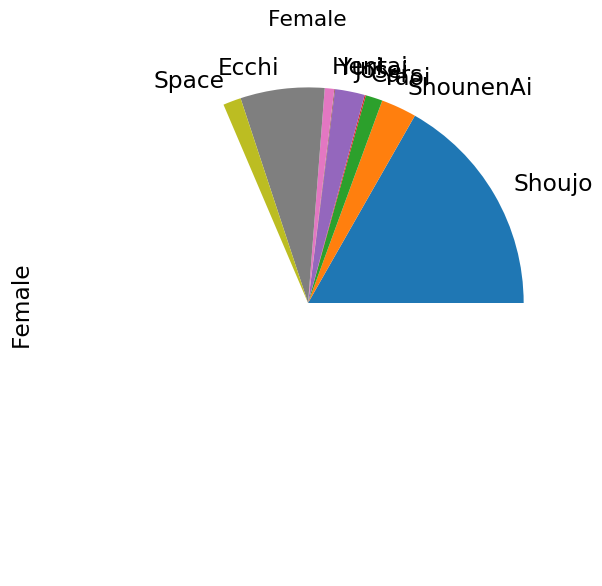

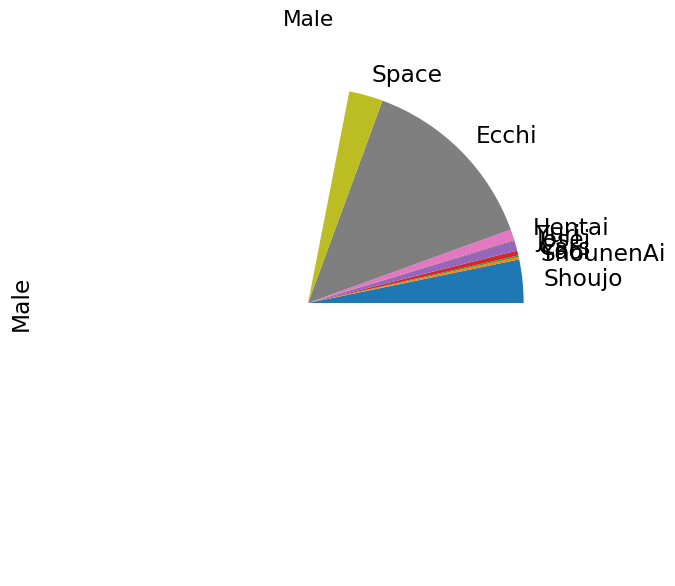

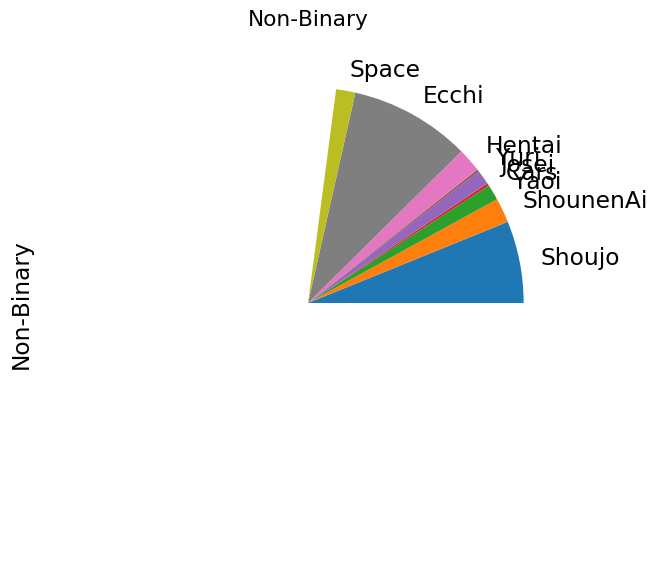

In [233]:
genders_genres[completed_columns].loc['Female'][dependent_genres].plot.pie(title='Female', labels=[x.replace('completed_', '') for x in dependent_genres])
plt.show()
genders_genres[completed_columns].loc['Male'][dependent_genres].plot.pie(title='Male', labels=[x.replace('completed_', '') for x in dependent_genres])
plt.show()
genders_genres[completed_columns].loc['Non-Binary'][dependent_genres].plot.pie(title='Non-Binary', labels=[x.replace('completed_', '') for x in dependent_genres])
plt.show()

In [228]:
genders_genres[completed_columns].apply(np.var).sort_values(ascending=False)

completed_Shoujo           3.372238e-03
completed_Action           2.096643e-03
completed_Romance          1.921287e-03
completed_Drama            1.230466e-03
completed_Ecchi            9.750548e-04
completed_Sci-Fi           9.325351e-04
completed_Shounen          3.632916e-04
completed_Harem            3.323975e-04
completed_Adventure        2.713330e-04
completed_Mecha            2.151913e-04
completed_SuperPower       2.134701e-04
completed_SliceofLife      1.833634e-04
completed_Seinen           1.797318e-04
completed_School           1.655390e-04
completed_Historical       1.177837e-04
completed_Military         1.081437e-04
completed_Magic            1.073377e-04
completed_ShounenAi        1.056848e-04
completed_Comedy           9.317663e-05
completed_Psychological    8.913269e-05
completed_Fantasy          8.590055e-05
completed_Mystery          7.136885e-05
completed_MartialArts      7.095209e-05
completed_Demons           5.596417e-05
completed_Supernatural     4.803192e-05


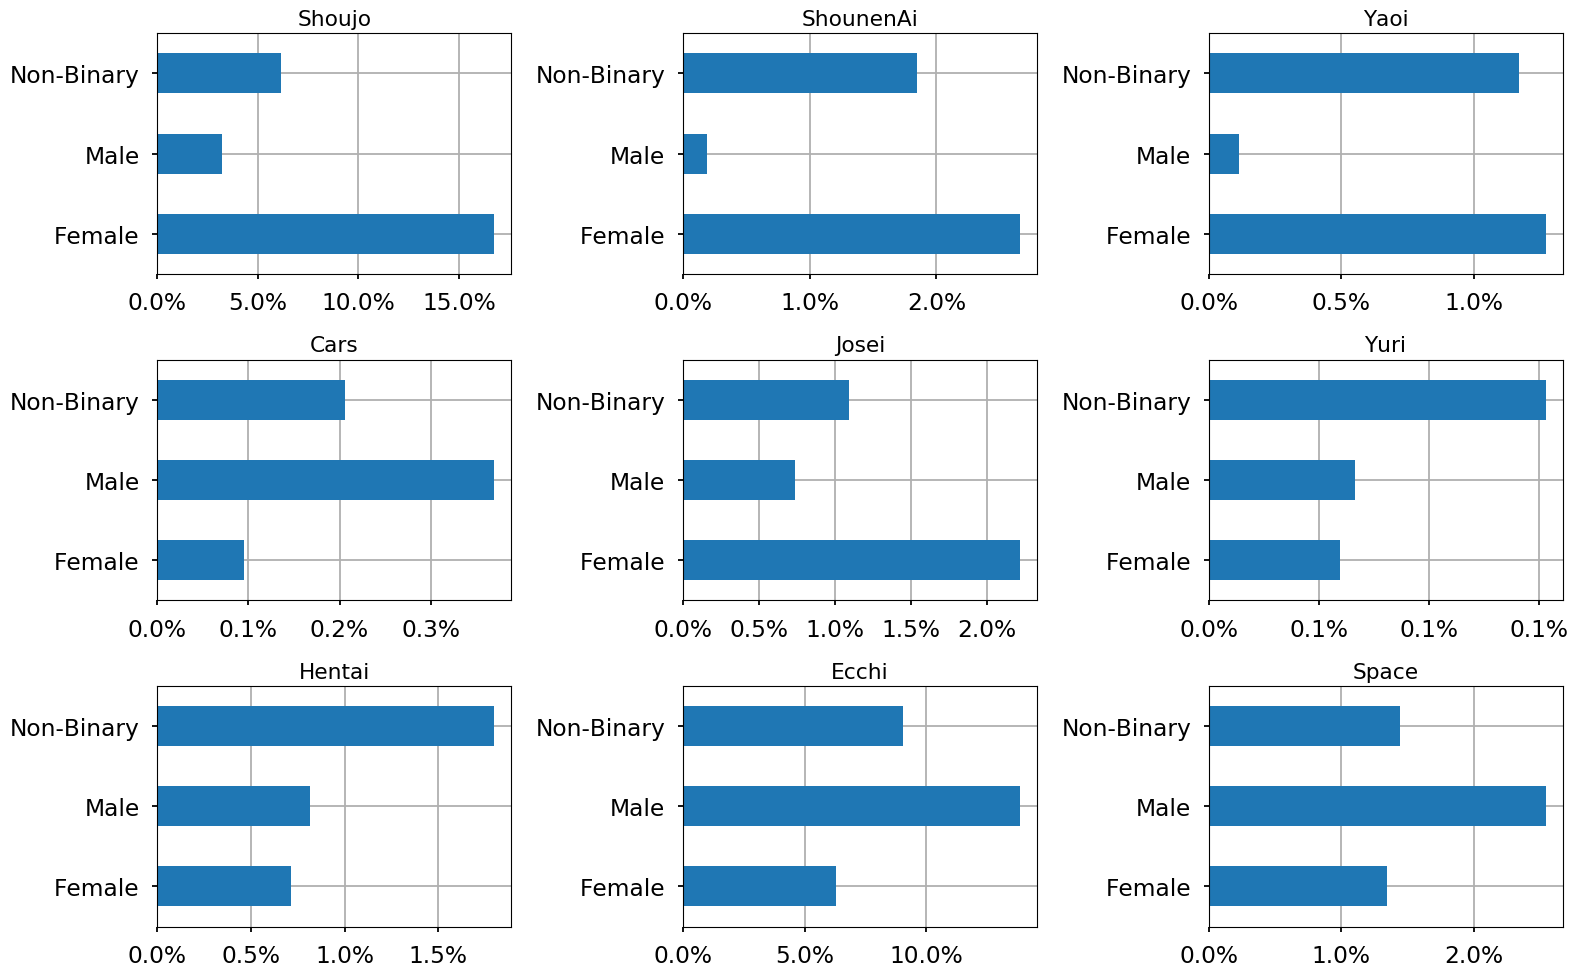

In [232]:
sqrt_num = np.ceil(np.sqrt(len(dependent_genres))).astype('int')
#fig, ax = plt.subplots(sqrt_num, sqrt_num, figsize=(16, 10), squeeze=False)
fig, ax = plt.subplots(3, 3, figsize=(16, 10), squeeze=False)
ax = ax.flatten()
for i, genre in enumerate(dependent_genres):
    genders_genres[genre].plot(kind='barh', ax=ax[i], title=genre.replace('completed_', ''))
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    ax[i].set_ylabel('')
plt.tight_layout()
#plt.subplots_adjust()
#plt.xticks(rotation=70)
plt.savefig('graphs/uzivatele-pohlavi-bar-jednotlive.png', bbox_inches='tight')

In [47]:
### and now binning ages into equi-sized bins
age_bins, intervals = pd.qcut(users['age'], 10, retbins=True)
intervals

array([11., 21., 22., 24., 25., 26., 27., 28., 30., 32., 50.])

In [48]:
age_bins.value_counts()
# these intervals suck, they fit 10-20 into one interval

(22.0, 24.0]      17871
(10.999, 21.0]    16448
(28.0, 30.0]      13788
(24.0, 25.0]       9760
(25.0, 26.0]       9379
(26.0, 27.0]       9231
(32.0, 50.0]       8927
(27.0, 28.0]       8383
(30.0, 32.0]       7690
(21.0, 22.0]       7234
Name: age, dtype: int64

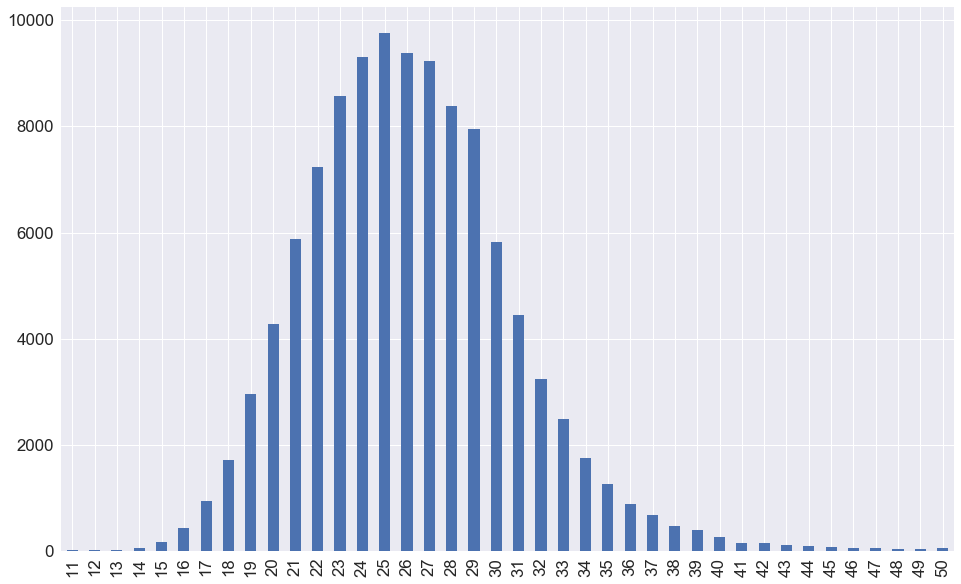

In [49]:
users_ages_completed['age'].value_counts().sort_index().plot(kind='bar', figsize=(16, 10))

In [50]:
bins = [9, 14, 17, 20, 23, 26, 30, 40, 50]
pd.cut(users_ages_completed['age'], bins, right=True).value_counts()
# hand-crafted by intuition

(26, 30]    31402
(23, 26]    28441
(20, 23]    21683
(30, 40]    15860
(17, 20]     8921
(14, 17]     1541
(40, 50]      757
(9, 14]       106
Name: age, dtype: int64

In [51]:
users_ages_completed['age_bin'] = pd.cut(users_ages_completed['age'], bins, right=True).astype(str)

In [52]:
users_ages_completed['age_bin'].value_counts()

(26, 30]    31402
(23, 26]    28441
(20, 23]    21683
(30, 40]    15860
(17, 20]     8921
(14, 17]     1541
(40, 50]      757
(9, 14]       106
Name: age_bin, dtype: int64

In [53]:
def tree_to_table(clf, target_column):
    def expand_node(curr_node, prefix):
        # three is balanced
        thr_percent = "{0:.1%}".format(threshold[curr_node])
        fname = fnames[feature[curr_node]]
        if children_left[curr_node] == -1 and children_right[curr_node] == -1:
            return [prefix], [targets[curr_node]], [value[curr_node, 0, :]]
        l_res, l_target, l_distr = expand_node(children_left[curr_node], prefix + [fname + ' <= ' + thr_percent])
        r_res, r_target, r_distr = expand_node(children_right[curr_node], prefix + [fname + ' > ' + thr_percent])
        return l_res + r_res, l_target + r_target, l_distr + r_distr

    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    value = clf.tree_.value

    fnames = [i.replace('completed_', '') for i in completed_columns]
    targets = [target_names[np.argmax(v)] for v in value]
    paths, classes, distr = expand_node(0, [])
    distr = np.array(distr)
    indices = pd.MultiIndex.from_tuples(paths)
    df = pd.DataFrame({target_column: classes, 'precision': (distr.max(axis=1) / distr.sum(axis=1))},
                      index=indices)
    df['precision'] = df['precision'].apply(lambda x: "{0:.2f}%".format(x * 100))
    # precision in classification terminology is # correctly classified / # totally classified (correctly + incorrectly)
    return df

In [54]:
# guessing gender based on completed genres histogram
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.82      0.79      0.80     37330
        Male       0.89      0.91      0.90     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.87      0.87      0.87    108711
   macro avg       0.57      0.57      0.57    108711
weighted avg       0.86      0.87      0.86    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


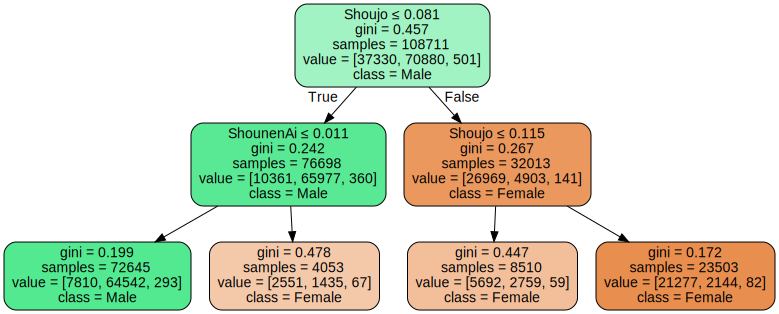

In [55]:
tree.export_graphviz(clf, out_file='gender_classifier.dot',
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [56]:
tree_to_table(clf, 'gender')

gender precision
Shoujo <= 8.1% ShounenAi <= 1.1%    Male    88.85%
               ShounenAi > 1.1%   Female    62.94%
Shoujo > 8.1%  Shoujo <= 11.5%    Female    66.89%
               Shoujo > 11.5%     Female    90.53%

In [57]:
# comparing precision depending on depth
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.84      0.72      0.78     37330
        Male       0.86      0.93      0.89     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.85      0.85      0.85    108711
   macro avg       0.57      0.55      0.56    108711
weighted avg       0.85      0.85      0.85    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender precision
Shoujo <= 8.1%    Male    86.02%
Shoujo > 8.1%   Female    84.24%

In [58]:
# comparing precision depending on depth
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.82      0.79      0.80     37330
        Male       0.89      0.91      0.90     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.87      0.87      0.87    108711
   macro avg       0.57      0.57      0.57    108711
weighted avg       0.86      0.87      0.86    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender precision
Shoujo <= 8.1% ShounenAi <= 1.1%    Male    88.85%
               ShounenAi > 1.1%   Female    62.94%
Shoujo > 8.1%  Shoujo <= 11.5%    Female    66.89%
               Shoujo > 11.5%     Female    90.53%

In [59]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.83      0.77      0.80     37330
        Male       0.88      0.92      0.90     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.87      0.87      0.87    108711
   macro avg       0.57      0.56      0.57    108711
weighted avg       0.86      0.87      0.86    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender precision
Shoujo <= 8.1% ShounenAi <= 1.1% Ecchi <= 2.1%        Male    68.65%
                                 Ecchi > 2.1%         Male    91.68%
               ShounenAi > 1.1%  ShounenAi <= 2.0%    Male    51.66%
                                 ShounenAi > 2.0%   Female    72.40%
Shoujo > 8.1%  Shoujo <= 11.5%   ShounenAi <= 0.5%  Female    50.97%
                                 ShounenAi > 0.5%   Female    85.44%
               Shoujo > 11.5%    Josei <= 0.5%      Female    83.64%
                                 Josei > 0.5%       Female    94.25%

In [60]:
import pickle
with open('tree_clf.rick', 'wb+') as f:
    pickle.dump(clf, f)

In [61]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.86      0.77      0.81     37330
        Male       0.88      0.93      0.91     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.87      0.87      0.87    108711
   macro avg       0.58      0.57      0.57    108711
weighted avg       0.87      0.87      0.87    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender  \
Shoujo <= 8.1% ShounenAi <= 1.1% Ecchi <= 2.1%     Sci-Fi <= 17.5%    Male   
                                                   Sci-Fi > 17.5%     Male   
                                 Ecchi > 2.1%      Shoujo <= 5.5%     Male   
                                                   Shoujo > 5.5%      Male   
               ShounenAi > 1.1%  ShounenAi <= 2.0% Shoujo <= 4.8%     Male   
                                                   Shoujo > 4.8%    Female   
                                 ShounenAi > 2.0%  Shoujo <= 4.5%   Female   
                                                   Shoujo > 4.5%    Female   
Shoujo > 8.1%  Shoujo <= 11.5%   ShounenAi <= 0.5% Ecchi <= 9.3%    Female   
                                                   Ecchi > 9.3%       Male   
                                 ShounenAi > 0.5%  Harem <= 11.2%   Female   
                                                   Harem > 11.2%    Female   
               Shoujo > 11.5%    Josei <= 0.5%     Shoujo <= 17.4%  Female   
                                                   Shoujo > 17.4%   Female   
                                 Josei > 0.5%      Shoujo <= 16.8%  Female   
                                                   Shoujo > 16.8%   Female   

                                                                   precision  
Shoujo <= 8.1% ShounenAi <= 1.1% Ecchi <= 2.1%     Sci-Fi <= 17.5%    57.43%  
                                                   Sci-Fi > 17.5%     77.21%  
                                 Ecchi > 2.1%      Shoujo <= 5.5%     93.72%  
                                                   Shoujo > 5.5%      77.38%  
               ShounenAi > 1.1%  ShounenAi <= 2.0% Shoujo <= 4.8%     68.90%  
                                                   Shoujo > 4.8%      60.99%  
                                 ShounenAi > 2.0%  Shoujo <= 4.5%     61.23%  
                                                   Shoujo > 4.5%      79.06%  
Shoujo > 8.1%  Shoujo <= 11.5%   ShounenAi <= 0.5% Ecchi <= 9.3%      63.13%  
                                                   Ecchi > 9.3%       66.88%  
                                 ShounenAi > 0.5%  Harem <= 11.2%     87.39%  
                                                   Harem > 11.2%      61.74%  
               Shoujo > 11.5%    Josei <= 0.5%     Shoujo <= 17.4%    71.03%  
                                                   Shoujo > 17.4%     89.59%  
                                 Josei > 0.5%      Shoujo <= 16.8%    90.70%  
                                                   Shoujo > 16.8%     96.79%

In [62]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.87      0.76      0.81     37330
        Male       0.88      0.94      0.91     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.87      0.87      0.87    108711
   macro avg       0.58      0.57      0.57    108711
weighted avg       0.87      0.87      0.87    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender  \
Shoujo <= 8.1% ShounenAi <= 1.1% Ecchi <= 2.1%     Sci-Fi <= 17.5% MartialArts <= 3.7%    Male   
                                                                   MartialArts > 3.7%     Male   
                                                   Sci-Fi > 17.5%  Shoujo <= 5.2%         Male   
                                                                   Shoujo > 5.2%          Male   
                                 Ecchi > 2.1%      Shoujo <= 5.5%  MartialArts <= 0.2%    Male   
                                                                   MartialArts > 0.2%     Male   
                                                   Shoujo > 5.5%   Romance <= 30.0%       Male   
                                                                   Romance > 30.0%        Male   
               ShounenAi > 1.1%  ShounenAi <= 2.0% Shoujo <= 4.8%  Harem <= 3.9%          Male   
                                                                   Harem > 3.9%           Male   
                                                   Shoujo > 4.8%   Harem <= 12.1%       Female   
                                                                   Harem > 12.1%          Male   
                                 ShounenAi > 2.0%  Shoujo <= 4.5%  Space <= 0.9%        Female   
                                                                   Space > 0.9%           Male   
                                                   Shoujo > 4.5%   Mecha <= 8.1%        Female   
                                                                   Mecha > 8.1%         Female   
Shoujo > 8.1%  Shoujo <= 11.5%   ShounenAi <= 0.5% Ecchi <= 9.3%   Mecha <= 8.2%        Female   
                                                                   Mecha > 8.2%           Male   
                                                   Ecchi > 9.3%    Mystery <= 14.4%       Male   
                                                                   Mystery > 14.4%      Female   
                                 ShounenAi > 0.5%  Harem <= 11.2%  Space <= 5.0%        Female   
                                                                   Space > 5.0%         Female   
                                                   Harem > 11.2%   Mecha <= 2.3%        Female   
                                                                   Mecha > 2.3%         Female   
               Shoujo > 11.5%    Josei <= 0.5%     Shoujo <= 17.4% ShounenAi <= 0.7%    Female   
                                                                   ShounenAi > 0.7%     Female   
                                                   Shoujo > 17.4%  Shoujo <= 25.7%      Female   
                                                                   Shoujo > 25.7%       Female   
                                 Josei > 0.5%      Shoujo <= 16.8% ShounenAi <= 0.1%    Female   
                                                                   ShounenAi > 0.1%     Female   
                                                   Shoujo > 16.8%  Action <= 80.9%      Female   
                                                                   Action > 80.9%         Male   

                                                                                       precision  
Shoujo <= 8.1% ShounenAi <= 1.1% Ecchi <= 2.1%     Sci-Fi <= 17.5% MartialArts <= 3.7%    52.02%  
                                                                   MartialArts > 3.7%     70.76%  
                                                   Sci-Fi > 17.5%  Shoujo <= 5.2%         80.10%  
                                                                   Shoujo > 5.2%          55.87%  
                                 Ecchi > 2.1%      Shoujo <= 5.5%  MartialArts <= 0.2%    83.93%  
                                                                   MartialArts > 0.2%     95.45%  
                                                   Shoujo > 5.5%   Romance <= 30.0%       62.57%  
                                                             

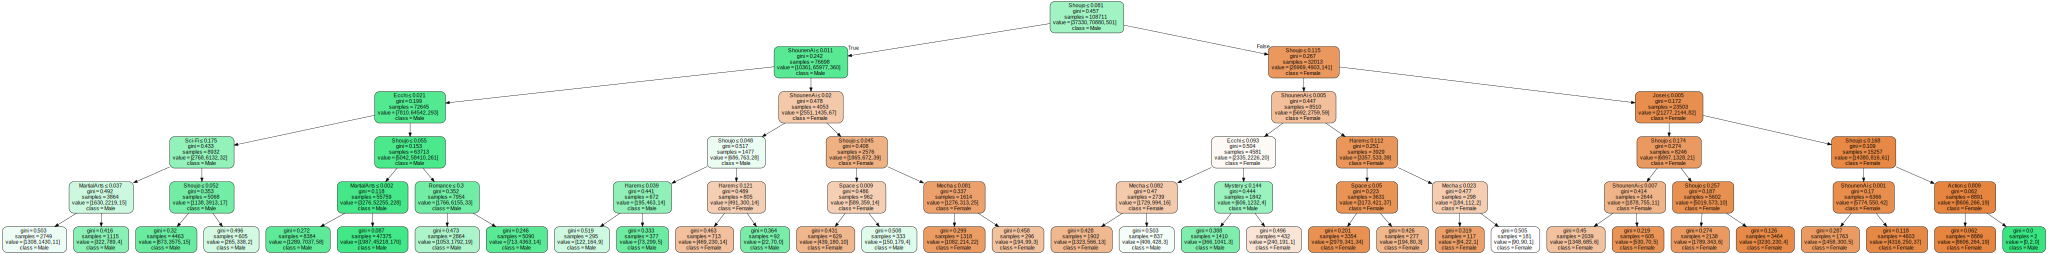

In [63]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [64]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.86      0.79      0.82     37330
        Male       0.89      0.93      0.91     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.88      0.88      0.88    108711
   macro avg       0.58      0.57      0.58    108711
weighted avg       0.88      0.88      0.88    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.87      0.79      0.83     37330
        Male       0.89      0.94      0.92     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.88      0.88      0.88    108711
   macro avg       0.59      0.58      0.58    108711
weighted avg       0.88      0.88      0.88    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [66]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      Female       0.88      0.80      0.83     37330
        Male       0.89      0.94      0.92     70880
  Non-Binary       0.00      0.00      0.00       501

   micro avg       0.89      0.89      0.89    108711
   macro avg       0.59      0.58      0.58    108711
weighted avg       0.88      0.89      0.89    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
# first, trying some depths

In [68]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      1541
    (20, 23]       0.00      0.00      0.00      8921
    (17, 20]       0.31      0.45      0.36     21683
    (30, 40]       0.31      0.49      0.38     28441
    (23, 26]       0.37      0.20      0.26     31402
    (14, 17]       0.38      0.36      0.37     15860
    (40, 50]       0.00      0.00      0.00       757
     (9, 14]       0.00      0.00      0.00       106

   micro avg       0.33      0.33      0.33    108711
   macro avg       0.17      0.19      0.17    108711
weighted avg       0.31      0.33      0.30    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      1541
    (20, 23]       0.00      0.00      0.00      8921
    (17, 20]       0.34      0.32      0.33     21683
    (30, 40]       0.32      0.40      0.36     28441
    (23, 26]       0.38      0.51      0.43     31402
    (14, 17]       0.44      0.27      0.33     15860
    (40, 50]       0.00      0.00      0.00       757
     (9, 14]       0.00      0.00      0.00       106

   micro avg       0.36      0.36      0.36    108711
   macro avg       0.19      0.19      0.18    108711
weighted avg       0.32      0.36      0.33    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      1541
    (20, 23]       0.00      0.00      0.00      8921
    (17, 20]       0.34      0.32      0.33     21683
    (30, 40]       0.32      0.38      0.35     28441
    (23, 26]       0.38      0.59      0.46     31402
    (14, 17]       0.52      0.17      0.26     15860
    (40, 50]       0.00      0.00      0.00       757
     (9, 14]       0.00      0.00      0.00       106

   micro avg       0.36      0.36      0.36    108711
   macro avg       0.19      0.18      0.17    108711
weighted avg       0.34      0.36      0.33    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [71]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      1541
    (20, 23]       0.00      0.00      0.00      8921
    (17, 20]       0.35      0.33      0.34     21683
    (30, 40]       0.32      0.45      0.37     28441
    (23, 26]       0.40      0.54      0.46     31402
    (14, 17]       0.49      0.21      0.29     15860
    (40, 50]       0.00      0.00      0.00       757
     (9, 14]       0.00      0.00      0.00       106

   micro avg       0.37      0.37      0.37    108711
   macro avg       0.19      0.19      0.18    108711
weighted avg       0.34      0.37      0.34    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      1541
    (20, 23]       0.00      0.00      0.00      8921
    (17, 20]       0.35      0.41      0.38     21683
    (30, 40]       0.33      0.40      0.36     28441
    (23, 26]       0.41      0.54      0.47     31402
    (14, 17]       0.52      0.22      0.30     15860
    (40, 50]       0.00      0.00      0.00       757
     (9, 14]       0.00      0.00      0.00       106

   micro avg       0.37      0.37      0.37    108711
   macro avg       0.20      0.20      0.19    108711
weighted avg       0.35      0.37      0.35    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      1541
    (20, 23]       0.00      0.00      0.00      8921
    (17, 20]       0.36      0.40      0.38     21683
    (30, 40]       0.34      0.41      0.37     28441
    (23, 26]       0.41      0.55      0.47     31402
    (14, 17]       0.52      0.26      0.34     15860
    (40, 50]       0.00      0.00      0.00       757
     (9, 14]       0.00      0.00      0.00       106

   micro avg       0.38      0.38      0.38    108711
   macro avg       0.20      0.20      0.20    108711
weighted avg       0.35      0.38      0.36    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.20      0.00      0.00      1541
    (20, 23]       0.38      0.07      0.12      8921
    (17, 20]       0.36      0.49      0.42     21683
    (30, 40]       0.35      0.35      0.35     28441
    (23, 26]       0.43      0.56      0.48     31402
    (14, 17]       0.54      0.29      0.38     15860
    (40, 50]       0.00      0.00      0.00       757
     (9, 14]       0.00      0.00      0.00       106

   micro avg       0.40      0.40      0.40    108711
   macro avg       0.28      0.22      0.22    108711
weighted avg       0.40      0.40      0.38    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
clf = tree.DecisionTreeClassifier(max_depth=9)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.50      0.00      0.01      1541
    (20, 23]       0.39      0.11      0.18      8921
    (17, 20]       0.38      0.48      0.43     21683
    (30, 40]       0.38      0.41      0.39     28441
    (23, 26]       0.45      0.54      0.49     31402
    (14, 17]       0.54      0.33      0.41     15860
    (40, 50]       0.00      0.00      0.00       757
     (9, 14]       0.00      0.00      0.00       106

   micro avg       0.42      0.42      0.42    108711
   macro avg       0.33      0.23      0.24    108711
weighted avg       0.42      0.42      0.40    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.78      0.00      0.01      1541
    (20, 23]       0.40      0.21      0.27      8921
    (17, 20]       0.41      0.47      0.43     21683
    (30, 40]       0.40      0.45      0.42     28441
    (23, 26]       0.47      0.55      0.51     31402
    (14, 17]       0.55      0.37      0.44     15860
    (40, 50]       0.00      0.00      0.00       757
     (9, 14]       0.00      0.00      0.00       106

   micro avg       0.44      0.44      0.44    108711
   macro avg       0.38      0.26      0.26    108711
weighted avg       0.45      0.44      0.43    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [77]:
# 5 depth seems like nice tradeoff based 
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    (26, 30]       0.00      0.00      0.00      1541
    (20, 23]       0.00      0.00      0.00      8921
    (17, 20]       0.35      0.33      0.34     21683
    (30, 40]       0.32      0.45      0.37     28441
    (23, 26]       0.40      0.54      0.46     31402
    (14, 17]       0.49      0.21      0.29     15860
    (40, 50]       0.00      0.00      0.00       757
     (9, 14]       0.00      0.00      0.00       106

   micro avg       0.37      0.37      0.37    108711
   macro avg       0.19      0.19      0.18    108711
weighted avg       0.34      0.37      0.34    108711



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


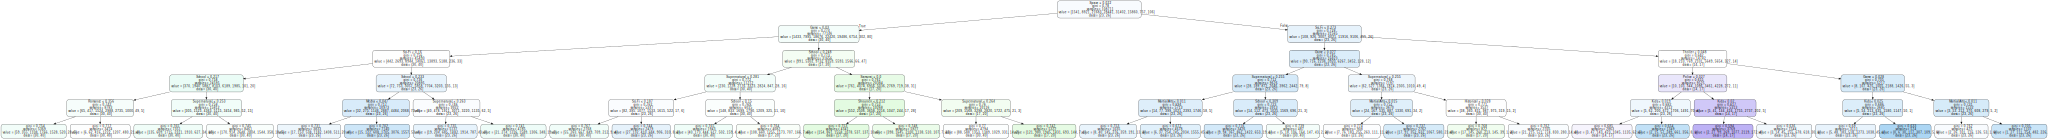

In [78]:
tree.export_graphviz(clf, out_file='age_classifier.dot',
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_completed['age_bin'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_completed['age_bin'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [79]:
tree_to_table(clf, 'age')

age  \
Space <= 2.2% Game <= 3.0%    Sci-Fi <= 16.0%  School <= 21.7%       Romance <= 35.6%       (30, 40]   
                                                                     Romance > 35.6%        (30, 40]   
                                               School > 21.7%        Supernatural <= 25.3%  (30, 40]   
                                                                     Supernatural > 25.3%   (30, 40]   
                              Sci-Fi > 16.0%   School <= 23.3%       Mecha <= 4.7%          (23, 26]   
                                                                     Mecha > 4.7%           (23, 26]   
                                               School > 23.3%        Supernatural <= 26.3%  (23, 26]   
                                                                     Supernatural > 26.3%   (30, 40]   
              Game > 3.0%     School <= 24.8%  Supernatural <= 28.1% Sci-Fi <= 18.7%        (30, 40]   
                                                                     Sci-Fi > 18.7%         (23, 26]   
                                               Supernatural > 28.1%  School <= 15.0%        (30, 40]   
                                                                     School > 15.0%         (17, 20]   
                              School > 24.8%   Samurai <= 0.0%       Shounen <= 21.2%       (17, 20]   
                                                                     Shounen > 21.2%        (17, 20]   
                                               Samurai > 0.0%        Supernatural <= 26.4%  (30, 40]   
                                                                     Supernatural > 26.4%   (17, 20]   
Space > 2.2%  Sci-Fi <= 27.3% Game <= 2.7%     Supernatural <= 25.5% MartialArts <= 1.1%    (23, 26]   
                                                                     MartialArts > 1.1%     (23, 26]   
                                               Supernatural > 25.5%  School <= 30.9%        (23, 26]   
                                                                     School > 30.9%         (30, 40]   
                              Game > 2.7%      Supernatural <= 25.5% MartialArts <= 1.5%    (23, 26]   
                                                                     MartialArts > 1.5%     (23, 26]   
                                               Supernatural > 25.5%  Historical <= 2.8%     (17, 20]   
                                                                     Historical > 2.8%      (23, 26]   
              Sci-Fi > 27.3%  Thriller <= 4.8% Police <= 2.7%        Kids <= 1.9%           (14, 17]   
                                                                     Kids > 1.9%            (23, 26]   
                                               Police > 2.7%         Kids <= 2.0%           (14, 17]   
                                                                     Kids > 2.0%            (23, 26]   
                              Thriller > 4.8%  Game <= 2.8%          Kids <= 2.5%           (23, 26]   
                                                                     Kids > 2.5%            (23, 26]   
                                               Game > 2.8%           MartialArts <= 1.1%    (23, 26]   
                                                                     MartialArts > 1.1%     (23, 26]   

                                                                                           precision  
Space <= 2.2% Game <= 3.0%    Sci-Fi <= 16.0%  School <= 21.7%       Romance <= 35.6%         32.89%  
                                                                     Romance > 35.6%          35.79%  
                                               School > 21.7%        Supernatural <= 25.3%    31.44%  
                                                                     Supernatural > 25.3%     33.14%  
                              Sci-Fi > 16.0%   School <= 23.3%       Mecha <= 4.7%            36.73%  
                                              

### genres in completed animests, compared with genres production

In [80]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
genres_arr = genres_arr[genres_arr['genre'] != '']
genres_arr.index.levels[0].name = 'anime_id'
animes_genres = pd.merge(animes, genres_arr, how='left', left_index=True, right_index=True)

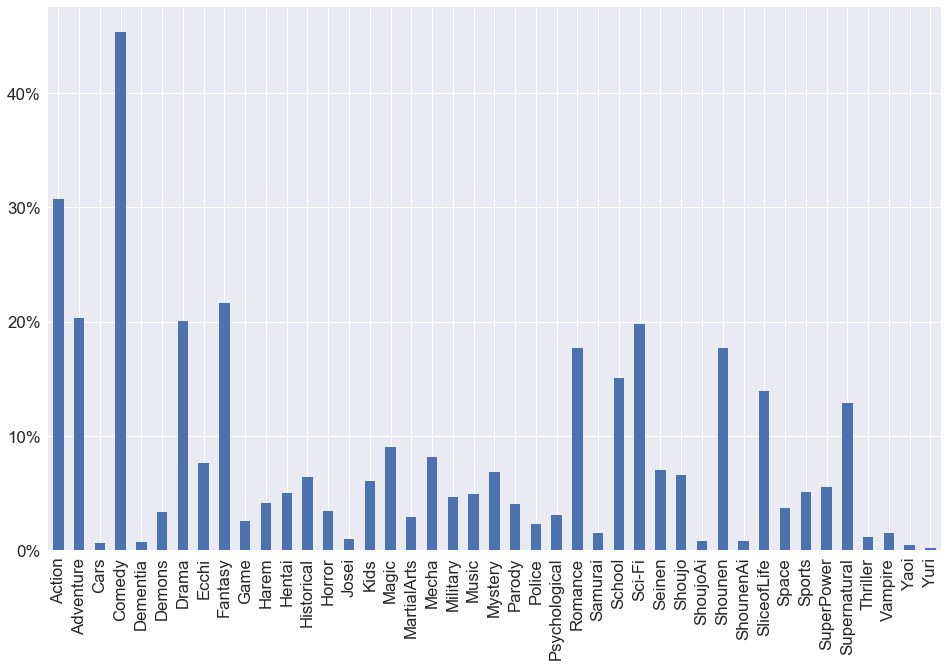

In [81]:
(animes_genres['genre'].value_counts() / animes.shape[0]).sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

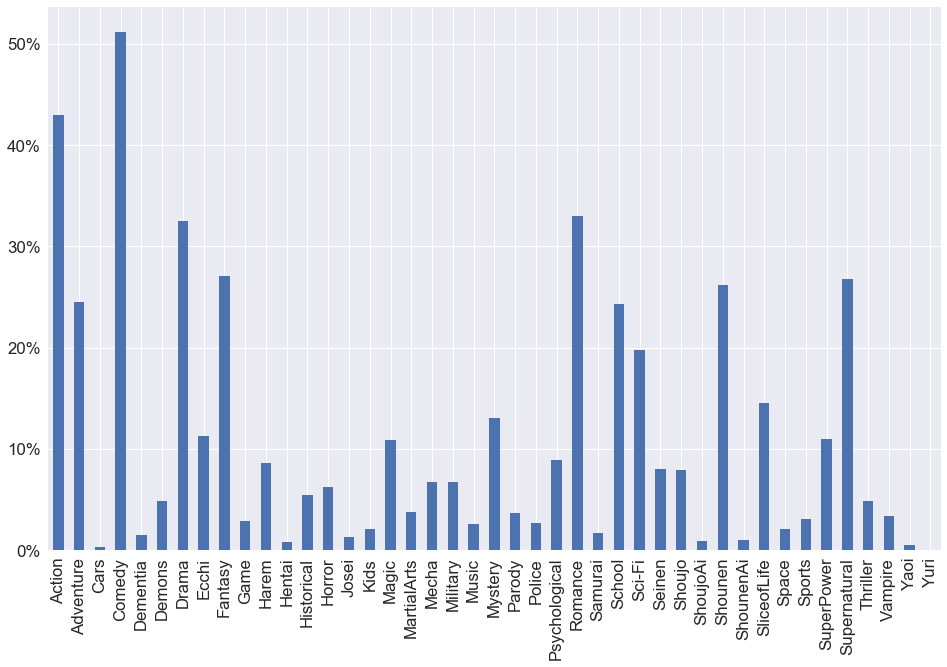

In [82]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

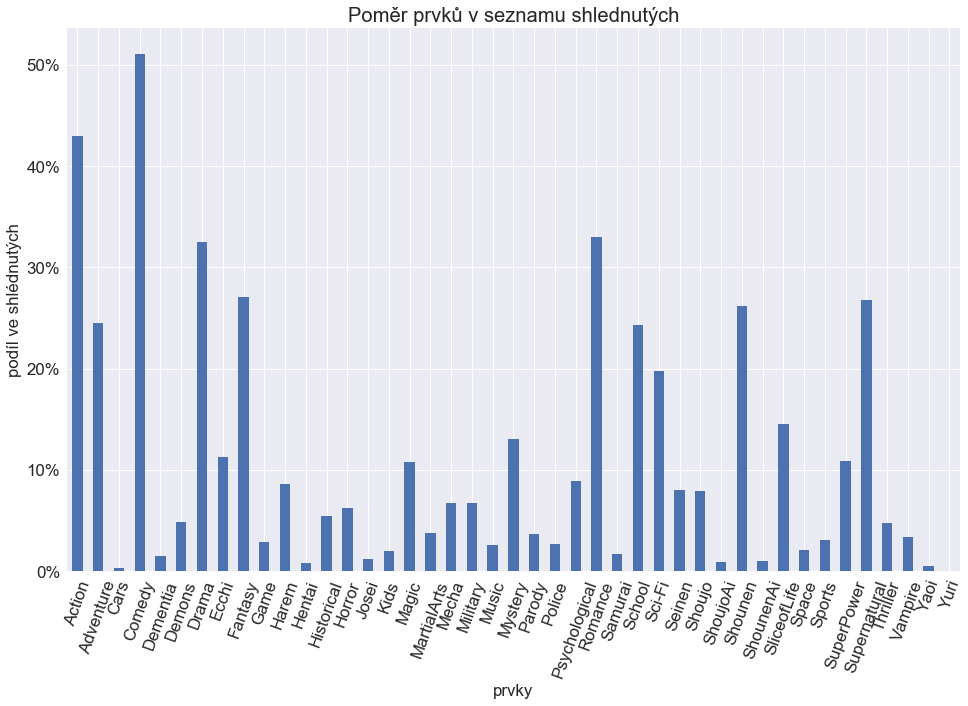

In [83]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.title('Poměr prvků v seznamu shlednutých')
plt.xticks(rotation=70)
plt.ylabel('podíl ve shlédnutých')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-shlednute-genres.png', bbox_inches="tight")

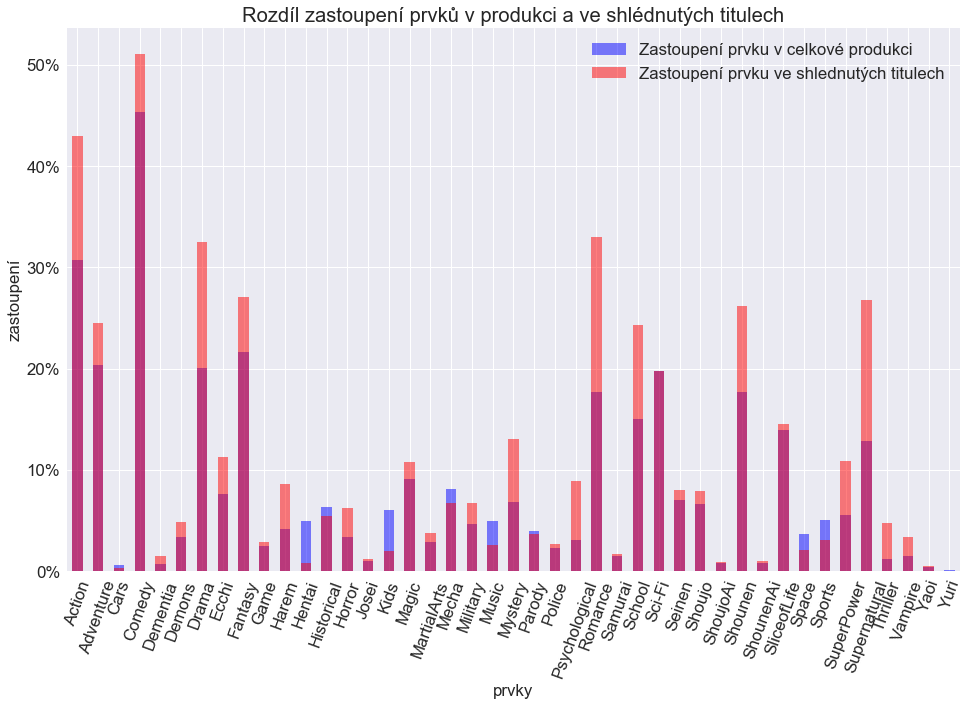

In [84]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
anime_genres_percent = (animes_genres['genre'].value_counts() / animes.shape[0]).sort_index()
anime_genres_percent.plot(kind='bar', figsize=(16, 10), title='Rozdíl zastoupení prvků v produkci a ve shlédnutých titulech', color='blue', alpha=0.5, label='Zastoupení prvku v celkové produkci')
users_genres_percent = users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index()
users_genres_percent.plot(kind='bar', color='red', alpha=0.5, label='Zastoupení prvku ve shlednutých titulech')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=1)
plt.xticks(rotation=70)
plt.ylabel('zastoupení')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-shlednute-genres-comparison.png', bbox_inches="tight")

In [85]:
# using new classes for users, both gender and age bin will be class, will try whether decision trees will have bigger success
users_ages_genders_completed = users_ages_completed.join(users_genders_completed['gender'])
users_ages_genders_completed['age_and_gender'] = users_ages_genders_completed['age_bin'] + ', ' + users_ages_genders_completed['gender']

In [86]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00       623
      (26, 30], Male       0.00      0.00      0.00       884
    (20, 23], Female       0.00      0.00      0.00        34
      (17, 20], Male       0.00      0.00      0.00      2884
      (30, 40], Male       0.00      0.00      0.00      5922
      (23, 26], Male       0.00      0.00      0.00       115
    (17, 20], Female       0.00      0.00      0.00      7875
      (20, 23], Male       0.00      0.00      0.00     13669
    (23, 26], Female       0.00      0.00      0.00       139
    (30, 40], Female       0.26      0.40      0.32     11094
    (14, 17], Female       0.23      0.71      0.34     17245
      (40, 50], Male       0.00      0.00      0.00       102
       (9, 14], Male       0.32      0.47      0.38     10265
(26, 30], Non-Binary       0.35      0.38      0.36     21063
      (14, 17], Male       0.00      0.00      0.00        74
(17, 20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age precision
Shoujo <= 8.1% Space <= 2.5%        (14, 17], Female    22.71%
               Space > 2.5%     (26, 30], Non-Binary    34.67%
Shoujo > 8.1%  School <= 21.9%         (9, 14], Male    32.03%
               School > 21.9%       (30, 40], Female    26.40%

In [87]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00       623
      (26, 30], Male       0.00      0.00      0.00       884
    (20, 23], Female       0.00      0.00      0.00        34
      (17, 20], Male       0.00      0.00      0.00      2884
      (30, 40], Male       0.00      0.00      0.00      5922
      (23, 26], Male       0.00      0.00      0.00       115
    (17, 20], Female       0.18      0.09      0.12      7875
      (20, 23], Male       0.27      0.61      0.38     13669
    (23, 26], Female       0.00      0.00      0.00       139
    (30, 40], Female       0.29      0.34      0.31     11094
    (14, 17], Female       0.00      0.00      0.00     17245
      (40, 50], Male       0.00      0.00      0.00       102
       (9, 14], Male       0.32      0.47      0.38     10265
(26, 30], Non-Binary       0.31      0.68      0.43     21063
      (14, 17], Male       0.00      0.00      0.00        74
(17, 20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age precision
Shoujo <= 8.1% Space <= 2.5%   Game <= 2.5%     (26, 30], Non-Binary    27.68%
                               Game > 2.5%            (20, 23], Male    27.13%
               Space > 2.5%    Sci-Fi <= 27.4%  (26, 30], Non-Binary    33.84%
                               Sci-Fi > 27.4%   (26, 30], Non-Binary    35.39%
Shoujo > 8.1%  School <= 21.9% Space <= 1.7%           (9, 14], Male    30.71%
                               Space > 1.7%            (9, 14], Male    34.34%
               School > 21.9%  Shoujo <= 11.2%      (17, 20], Female    17.74%
                               Shoujo > 11.2%       (30, 40], Female    29.15%

In [88]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00       623
      (26, 30], Male       0.00      0.00      0.00       884
    (20, 23], Female       0.00      0.00      0.00        34
      (17, 20], Male       0.00      0.00      0.00      2884
      (30, 40], Male       0.00      0.00      0.00      5922
      (23, 26], Male       0.00      0.00      0.00       115
    (17, 20], Female       0.30      0.27      0.29      7875
      (20, 23], Male       0.32      0.28      0.30     13669
    (23, 26], Female       0.00      0.00      0.00       139
    (30, 40], Female       0.30      0.34      0.32     11094
    (14, 17], Female       0.25      0.27      0.26     17245
      (40, 50], Male       0.00      0.00      0.00       102
       (9, 14], Male       0.36      0.34      0.35     10265
(26, 30], Non-Binary       0.31      0.57      0.40     21063
      (14, 17], Male       0.00      0.00      0.00        74
(17, 20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age  \
Shoujo <= 8.1% Space <= 2.5%   Game <= 2.5%    ShounenAi <= 1.1%   (26, 30], Non-Binary   
                                               ShounenAi > 1.1%        (30, 40], Female   
                               Game > 2.5%     Historical <= 2.3%        (20, 23], Male   
                                               Historical > 2.3%       (14, 17], Female   
               Space > 2.5%    Sci-Fi <= 27.4% Game <= 2.7%        (26, 30], Non-Binary   
                                               Game > 2.7%         (26, 30], Non-Binary   
                               Sci-Fi > 27.4%  Thriller <= 4.7%        (40, 50], Female   
                                               Thriller > 4.7%     (26, 30], Non-Binary   
Shoujo > 8.1%  School <= 21.9% Space <= 1.7%   Drama <= 36.4%          (30, 40], Female   
                                               Drama > 36.4%              (9, 14], Male   
                               Space > 1.7%    Sci-Fi <= 28.4%            (9, 14], Male   
                                               Sci-Fi > 28.4%      (17, 20], Non-Binary   
               School > 21.9%  Shoujo <= 11.2% ShounenAi <= 0.6%   (26, 30], Non-Binary   
                                               ShounenAi > 0.6%        (30, 40], Female   
                               Shoujo > 11.2%  Drama <= 37.9%          (17, 20], Female   
                                               Drama > 37.9%           (30, 40], Female   

                                                                  precision  
Shoujo <= 8.1% Space <= 2.5%   Game <= 2.5%    ShounenAi <= 1.1%     29.19%  
                                               ShounenAi > 1.1%      24.61%  
                               Game > 2.5%     Historical <= 2.3%    31.62%  
                                               Historical > 2.3%     25.30%  
               Space > 2.5%    Sci-Fi <= 27.4% Game <= 2.7%          38.36%  
                                               Game > 2.7%           28.91%  
                               Sci-Fi > 27.4%  Thriller <= 4.7%      40.90%  
                                               Thriller > 4.7%       38.28%  
Shoujo > 8.1%  School <= 21.9% Space <= 1.7%   Drama <= 36.4%        29.71%  
                                               Drama > 36.4%         33.77%  
                               Space > 1.7%    Sci-Fi <= 28.4%       38.19%  
                                               Sci-Fi > 28.4%        32.67%  
               School > 21.9%  Shoujo <= 11.2% ShounenAi <= 0.6%     15.96%  
                                               ShounenAi > 0.6%      26.41%  
                               Shoujo > 11.2%  Drama <= 37.9%        29.73%  
                                               Drama > 37.9%         31.96%

In [89]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00       623
      (26, 30], Male       0.00      0.00      0.00       884
    (20, 23], Female       0.00      0.00      0.00        34
      (17, 20], Male       0.00      0.00      0.00      2884
      (30, 40], Male       0.00      0.00      0.00      5922
      (23, 26], Male       0.00      0.00      0.00       115
    (17, 20], Female       0.27      0.25      0.26      7875
      (20, 23], Male       0.32      0.28      0.30     13669
    (23, 26], Female       0.00      0.00      0.00       139
    (30, 40], Female       0.32      0.47      0.38     11094
    (14, 17], Female       0.26      0.31      0.28     17245
      (40, 50], Male       0.00      0.00      0.00       102
       (9, 14], Male       0.34      0.30      0.32     10265
(26, 30], Non-Binary       0.33      0.57      0.42     21063
      (14, 17], Male       0.00      0.00      0.00        74
(17, 20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age  \
Shoujo <= 8.1% Space <= 2.5%   Game <= 2.5%    ShounenAi <= 1.1%  MartialArts <= 0.6%    (26, 30], Non-Binary   
                                                                  MartialArts > 0.6%     (26, 30], Non-Binary   
                                               ShounenAi > 1.1%   Sci-Fi <= 17.5%            (30, 40], Female   
                                                                  Sci-Fi > 17.5%                (9, 14], Male   
                               Game > 2.5%     Historical <= 2.3% Sci-Fi <= 13.0%              (20, 23], Male   
                                                                  Sci-Fi > 13.0%               (20, 23], Male   
                                               Historical > 2.3%  ShounenAi <= 1.0%          (14, 17], Female   
                                                                  ShounenAi > 1.0%           (17, 20], Female   
               Space > 2.5%    Sci-Fi <= 27.4% Game <= 2.7%       ShounenAi <= 0.9%      (26, 30], Non-Binary   
                                                                  ShounenAi > 0.9%              (9, 14], Male   
                                               Game > 2.7%        Supernatural <= 25.3%  (26, 30], Non-Binary   
                                                                  Supernatural > 25.3%       (14, 17], Female   
                               Sci-Fi > 27.4%  Thriller <= 4.7%   Kids <= 2.0%               (40, 50], Female   
                                                                  Kids > 2.0%            (26, 30], Non-Binary   
                                               Thriller > 4.7%    MartialArts <= 1.1%    (26, 30], Non-Binary   
                                                                  MartialArts > 1.1%     (26, 30], Non-Binary   
Shoujo > 8.1%  School <= 21.9% Space <= 1.7%   Drama <= 36.4%     Sci-Fi <= 21.7%            (30, 40], Female   
                                                                  Sci-Fi > 21.7%                (9, 14], Male   
                                               Drama > 36.4%      Sci-Fi <= 15.6%            (30, 40], Female   
                                                                  Sci-Fi > 15.6%                (9, 14], Male   
                               Space > 1.7%    Sci-Fi <= 28.4%    Shoujo <= 11.9%               (9, 14], Male   
                                                                  Shoujo > 11.9%                (9, 14], Male   
                                               Sci-Fi > 28.4%     ShounenAi <= 1.0%      (17, 20], Non-Binary   
                                                                  ShounenAi > 1.0%       (17, 20], Non-Binary   
               School > 21.9%  Shoujo <= 11.2% ShounenAi <= 0.6%  Romance <= 40.4%           (17, 20], Female   
                                                                  Romance > 40.4%        (26, 30], Non-Binary   
                                               ShounenAi > 0.6%   MartialArts <= 0.6%        (17, 20], Female   
                                                                  MartialArts > 0.6%         (30, 40], Female   
                               Shoujo > 11.2%  Drama <= 37.9%     School <= 29.0%            (30, 40], Female   
                                                                  School > 29.0%             (17, 20], Female   
                                               Drama > 37.9%      Space <= 1.1%              (30, 40], Female   
                                                                  Space > 1.1%                  (9, 14], Male   

                                                                                        precision  
Shoujo <= 8.1% Space <= 2.5%   Game <= 2.5%    ShounenAi <= 1.1%  MartialArts <= 0.6%      19.36%  
                                                                  MartialArts > 0.6%       33.80%  
                                               ShounenAi > 1.1%  

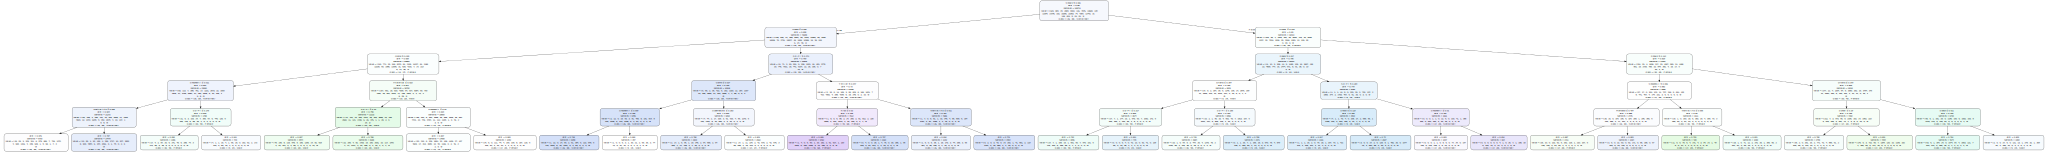

In [90]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_genders_completed['age_and_gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [91]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00       623
      (26, 30], Male       0.00      0.00      0.00       884
    (20, 23], Female       0.00      0.00      0.00        34
      (17, 20], Male       0.00      0.00      0.00      2884
      (30, 40], Male       0.00      0.00      0.00      5922
      (23, 26], Male       0.00      0.00      0.00       115
    (17, 20], Female       0.30      0.30      0.30      7875
      (20, 23], Male       0.30      0.44      0.36     13669
    (23, 26], Female       0.00      0.00      0.00       139
    (30, 40], Female       0.32      0.37      0.34     11094
    (14, 17], Female       0.27      0.21      0.24     17245
      (40, 50], Male       0.00      0.00      0.00       102
       (9, 14], Male       0.35      0.37      0.36     10265
(26, 30], Non-Binary       0.33      0.61      0.43     21063
      (14, 17], Male       0.00      0.00      0.00        74
(17, 20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age  \
Shoujo <= 8.1% Space <= 2.5%   Game <= 2.5%    ShounenAi <= 1.1%  MartialArts <= 0.6%   Harem <= 8.2%          (26, 30], Non-Binary   
                                                                                        Harem > 8.2%               (14, 17], Female   
                                                                  MartialArts > 0.6%    Mecha <= 4.8%          (26, 30], Non-Binary   
                                                                                        Mecha > 4.8%           (26, 30], Non-Binary   
                                               ShounenAi > 1.1%   Sci-Fi <= 17.5%       Harem <= 12.2%             (30, 40], Female   
                                                                                        Harem > 12.2%              (14, 17], Female   
                                                                  Sci-Fi > 17.5%        Ecchi <= 11.8%                (9, 14], Male   
                                                                                        Ecchi > 11.8%          (26, 30], Non-Binary   
                               Game > 2.5%     Historical <= 2.3% Sci-Fi <= 13.0%       Comedy <= 60.4%              (20, 23], Male   
                                                                                        Comedy > 60.4%               (20, 23], Male   
                                                                  Sci-Fi > 13.0%        Supernatural <= 24.2%        (20, 23], Male   
                                                                                        Supernatural > 24.2%         (20, 23], Male   
                                               Historical > 2.3%  ShounenAi <= 1.0%     Sci-Fi <= 16.0%              (20, 23], Male   
                                                                                        Sci-Fi > 16.0%             (14, 17], Female   
                                                                  ShounenAi > 1.0%      Sci-Fi <= 14.8%            (17, 20], Female   
                                                                                        Sci-Fi > 14.8%             (30, 40], Female   
               Space > 2.5%    Sci-Fi <= 27.4% Game <= 2.7%       ShounenAi <= 0.9%     MartialArts <= 1.2%    (26, 30], Non-Binary   
                                                                                        MartialArts > 1.2%     (26, 30], Non-Binary   
                                                                  ShounenAi > 0.9%      Harem <= 5.4%                 (9, 14], Male   
                                                                                        Harem > 5.4%           (26, 30], Non-Binary   
                                               Game > 2.7%        Supernatural <= 25.3% Shoujo <= 3.8%         (26, 30], Non-Binary   
                                                                                        Shoujo > 3.8%          (26, 30], Non-Binary   
                                                                  Supernatural > 25.3%  MartialArts <= 0.9%          (20, 23], Male   
                                                                                        MartialArts > 0.9%     (26, 30], Non-Binary   
                               Sci-Fi > 27.4%  Thriller <= 4.7%   Kids <= 2.0%          Police <= 1.9%         (26, 30], Non-Binary   
                                                                                        Police > 1.9%              (40, 50], Female   
                                                                  Kids > 2.0%           Police <= 3.6%         (26, 30], Non-Binary   
                                                                                        Police > 3.6%          (26, 30], Non-Binary   
                                               Thriller > 4.7%    MartialArts <= 1.1%   Game <= 2.0%           (26, 30], Non-Binary   
                                                                   

### nothing interesting in decision trees above, gender does not bring precision into age prediction
### going to measure genre distances by users animelists

<IPython.core.display.Javascript object>


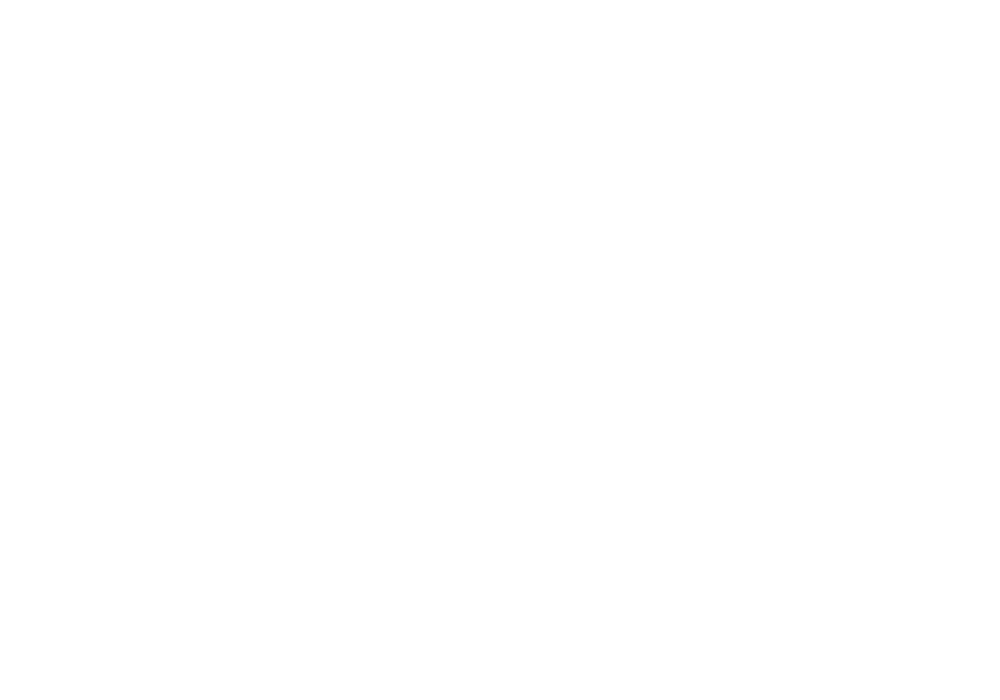

Text(0.5, 0.92, 'users by genres in 3D')

In [92]:
%matplotlib notebook
# doing PCA on genres distribution
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components=3)
embeddings = pca.fit_transform(users_ages_genders_completed[completed_columns])

plt.figure(figsize=(10, 7))

# colors per gender
ax = plt.axes(projection='3d')
le = preprocessing.LabelEncoder()
genders = le.fit_transform(users_ages_genders_completed['gender'])
genders = genders.astype(np.int)
colors = plt.cm.Set1(np.unique(genders))
ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=1, c=[colors[x] for x in genders])
plt.title("users by genres in 3D")

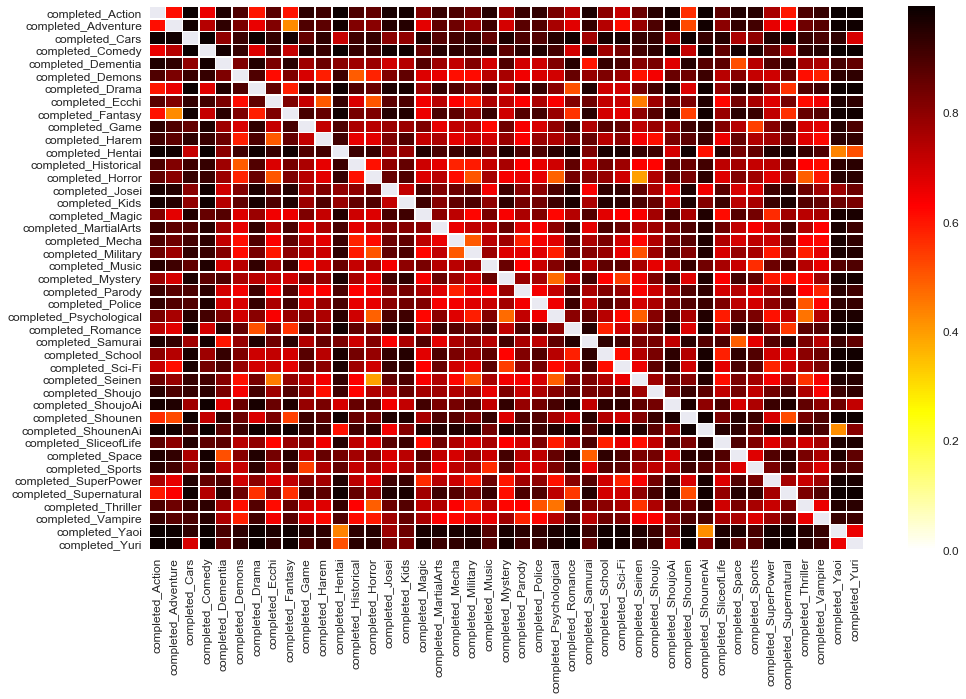

In [93]:
# safe nsd with eps
eps = np.finfo(np.float32).eps
def nsd(x, y):
    return (max(np.log(x.sum()), np.log(y.sum())) - np.log((x & y).sum())) / (np.log(x.size) - min(np.log(x.sum()), np.log(y.sum())))

def nsd_safe(x, y):
    return (max(np.log(x.sum() + eps), np.log(y.sum() + eps)) - np.log((x & y).sum() + eps)) / (np.log(x.size) - min(np.log(x.sum() + eps), np.log(y.sum() + eps)))

# todo: vymyslet co s tím, když je to spojité a ne binární
%matplotlib inline

renaming = {x: x.replace('completed_', '') for x in completed_columns}
dists = pdist(users_completed[completed_columns].rename(columns=renaming).T > 0, nsd)
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 0  # infinities mess color scale

dists_df = pd.DataFrame(dists_m)
dists_df.columns = users_completed.T.index
dists_df.index = users_completed.T.index

f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True
sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

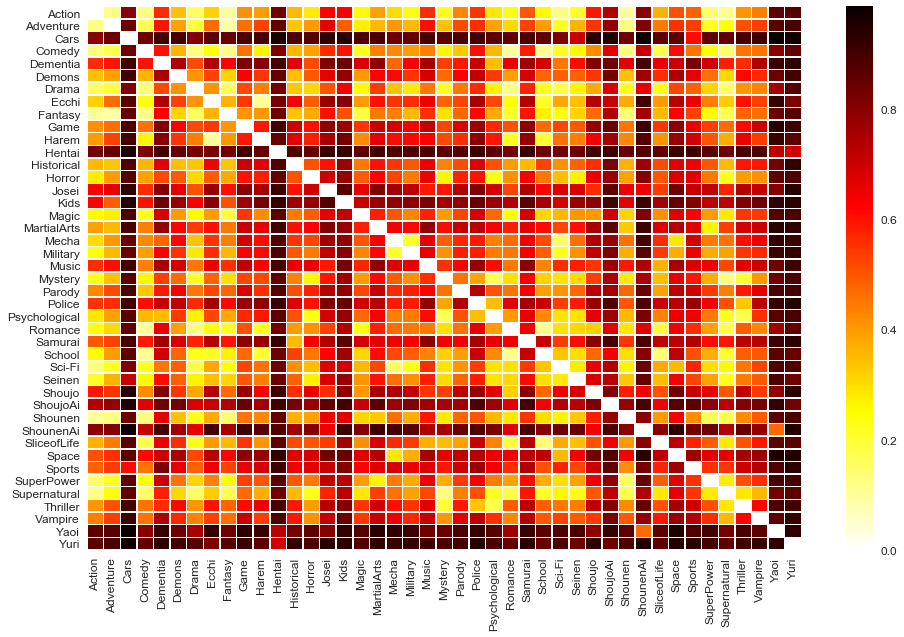

In [94]:
%matplotlib inline

renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

167

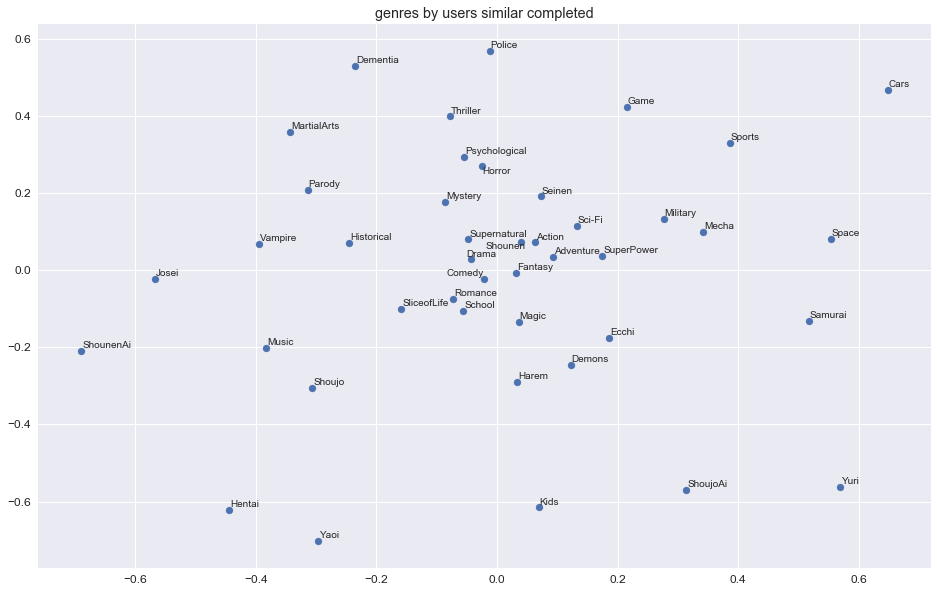

In [95]:
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("genres by users similar completed")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

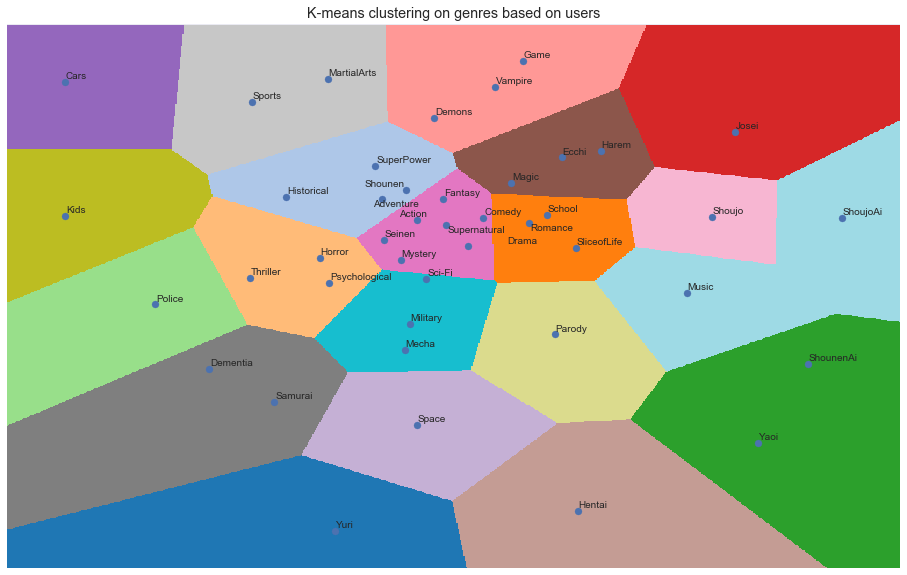

In [96]:
from sklearn.cluster import KMeans

embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

kmeans = KMeans(init='k-means++', n_clusters=21, n_init=10)
kmeans.fit(embeddings)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .002     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embeddings[:, 0].min() - 0.1, embeddings[:, 0].max() + 0.1
y_min, y_max = embeddings[:, 1].min() - 0.1, embeddings[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.tab20,
           aspect='auto', origin='lower')

plt.scatter(embeddings[:, 0], embeddings[:, 1])
#plt.plot(embeddings[:, 0], embeddings[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
plt.title('K-means clustering on genres based on users')

texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

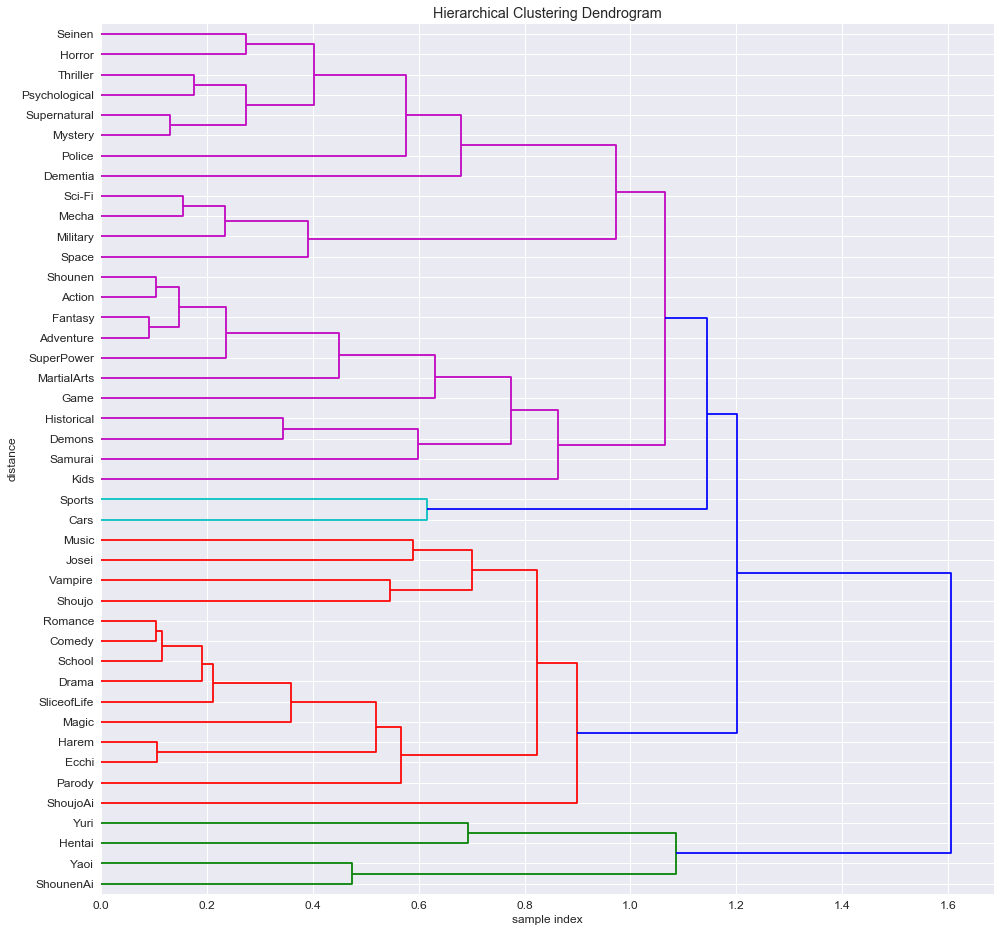

In [97]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix 
# squareform transfers between condensed and redundant distance form
Z = linkage(squareform(dists_m), 'ward')

# calculate full dendrogram
plt.figure(figsize=(16, 16))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='right',
    labels=dists_df.index
)
plt.show()

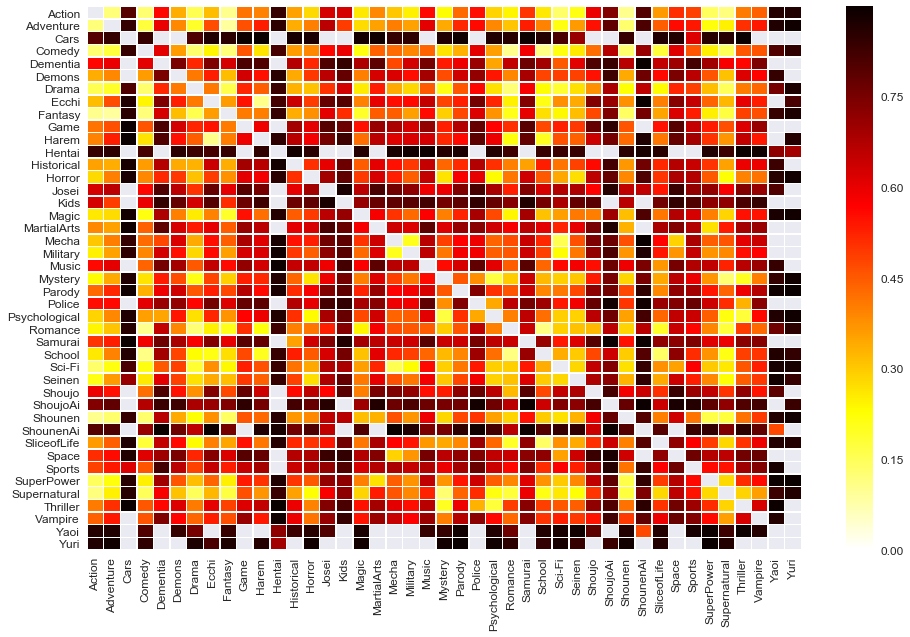

In [98]:
# now with thresholding, more than 0.9 dissimilarity is undefined
f, ax = plt.subplots(figsize=(16, 10))
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_m[dists_m > 0.9] = 0
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True

sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

In [99]:
def init(sizes):
    def my_init():
        ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=sizes)
        return fig,
    return my_init

def animate(i):
    ax.azim = ax.azim - 2
    ax.view_init(ax.elev, ax.azim)
    return fig,

def points_3d_to_gif(embeddings, labels, gif_filename, ax, sizes):
    for i, txt in enumerate(labels):
        ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)

    #plt.axis('off')
    #ax.grid(False)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.elev = 25.
    ax.azim = 321.
    ax.dist = 11.

    # Animate, interval in ms, frames == # of frames in animation
    anim = animation.FuncAnimation(fig, animate, init_func=init(sizes),
                                   frames=180, interval=80, blit=True)
    # Save
    anim.save('images/{}.gif'.format(gif_filename), dpi=80, writer='imagemagick')


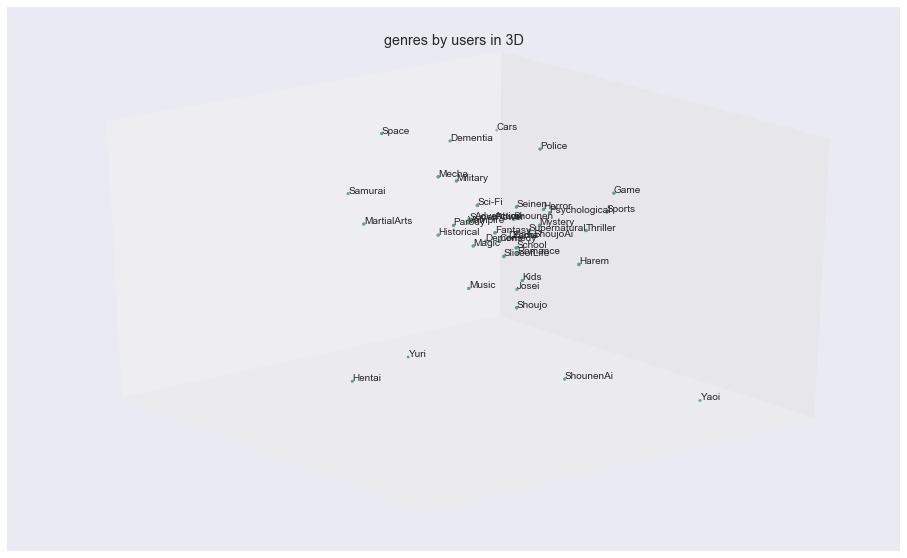

In [100]:
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_m[dists_m > 0.9] = 0  # I need to set infinities to zeros, then it handles infinities as missing data, which is wanted
embedder = manifold.MDS(3, metric=False, max_iter=2000, n_init=10, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')

plt.title("genres by users in 3D")
points_3d_to_gif(embeddings, genres_users.index, 'genres_users-cosine-MSD', ax, genres_users.sum(axis=1).apply(np.log))

In [101]:
pairs = np.array(list(combinations(genres_users.index, 2)))

# for gephi, higher edge cost means higher similarity
edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': 1-dists})
edges = edges[edges['weight'] != np.inf]

nodes = pd.DataFrame({'id': genres_users.index, 'label': genres_users.index})
edges['type'] = 'undirected'

nodes.to_csv('genres_users_nodes.csv', index=False, sep=',', encoding='utf-8')
edges.to_csv('genres_users_edges_cosine.csv', index=False, sep=',', encoding='utf-8')

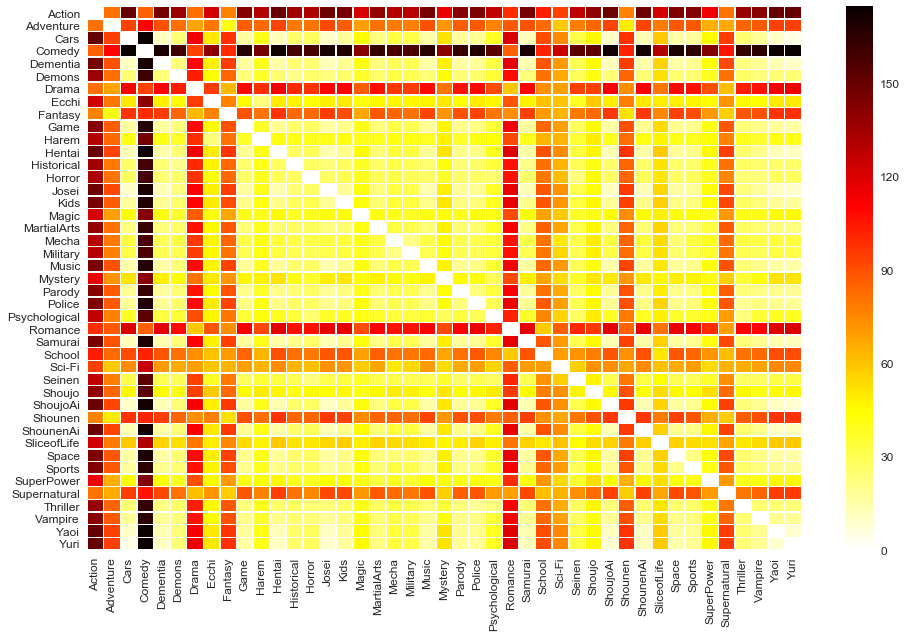

In [102]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'euclidean')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

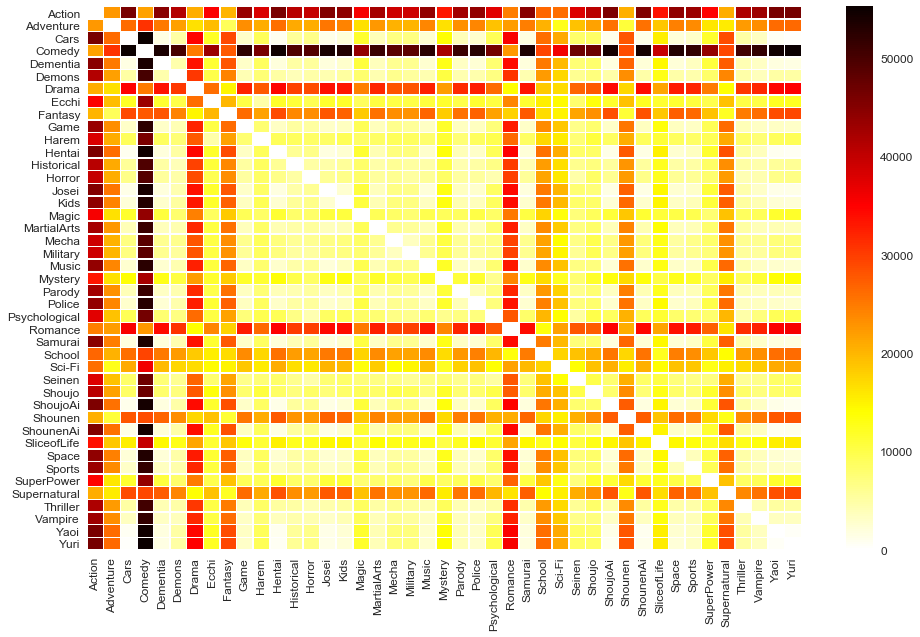

In [103]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cityblock')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

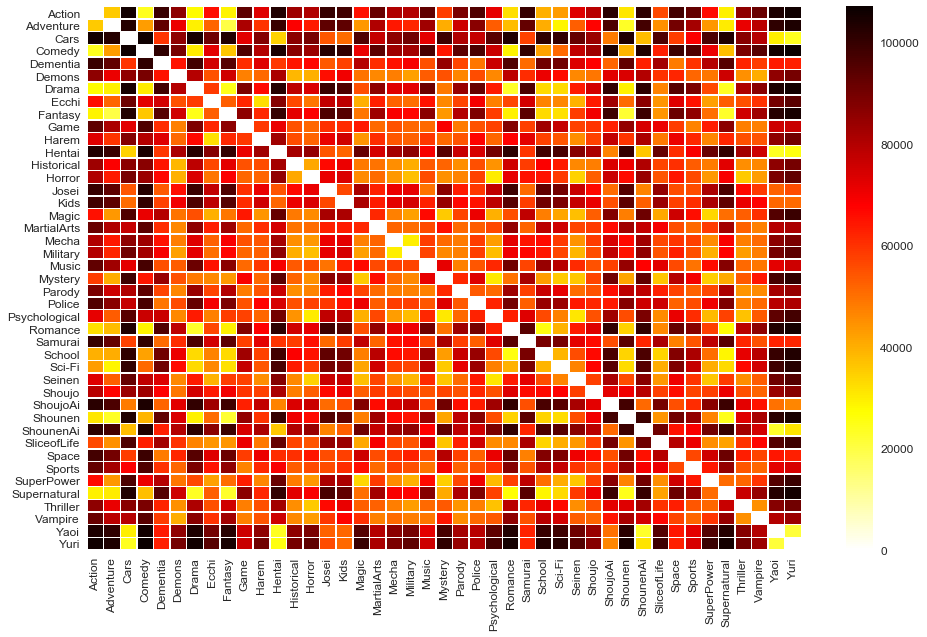

In [104]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'canberra')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

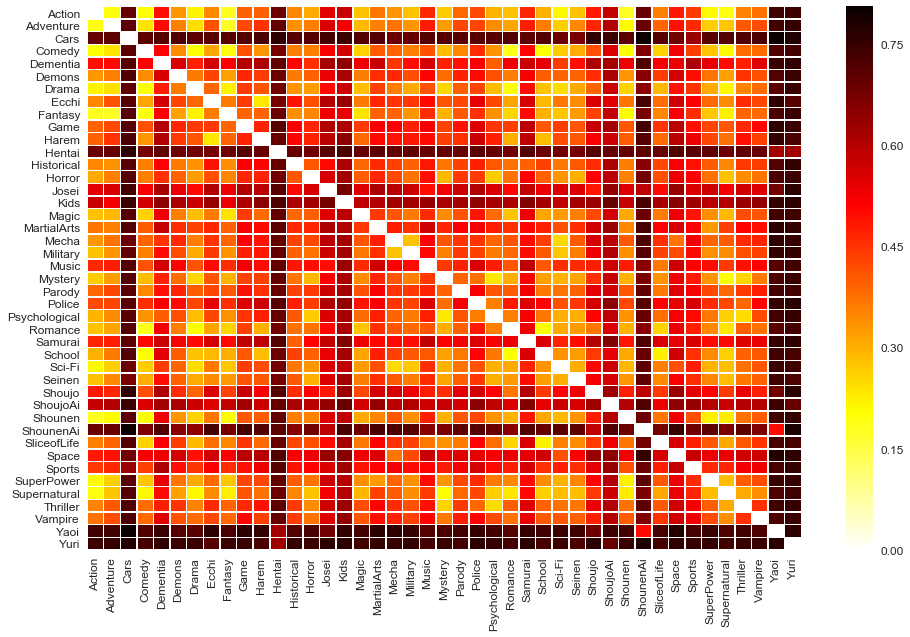

In [105]:
# using Jensen Shannon diverge, which is symeterized version of KL divergence
def js(p, q):
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2

def js_metric(p, q):
    # with square root it will satisfy triangle inequality
    return np.sqrt(js(p, q))

renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, lambda x, y: js_metric(x, y))
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

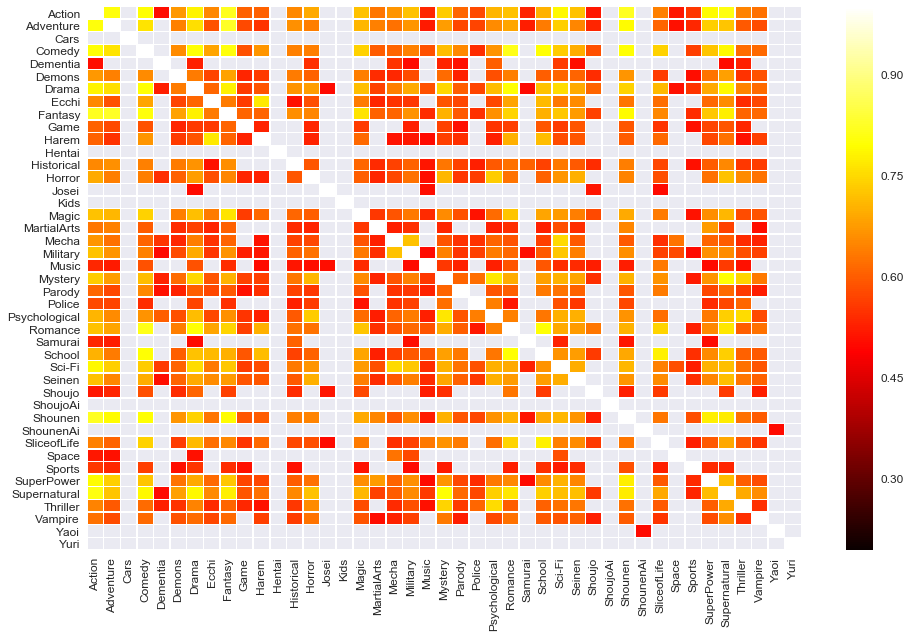

In [106]:
f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[(1-dists_df) < 0.5] = True

sns.heatmap(1-dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot)

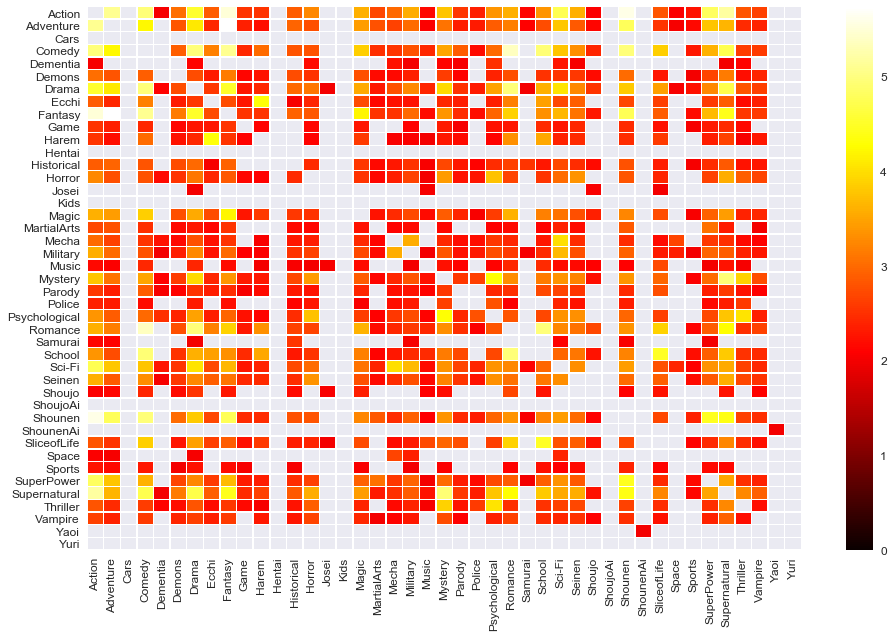

In [107]:
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True

dists_df_inv = 1 / dists_df
dists_df_inv[dists_df_inv == np.inf] = 0
mask[dists_df_inv < 2] = True  # inspect how filtering low similarities will look like

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df_inv, mask=mask, linewidths=.5, cmap=plt.cm.hot)

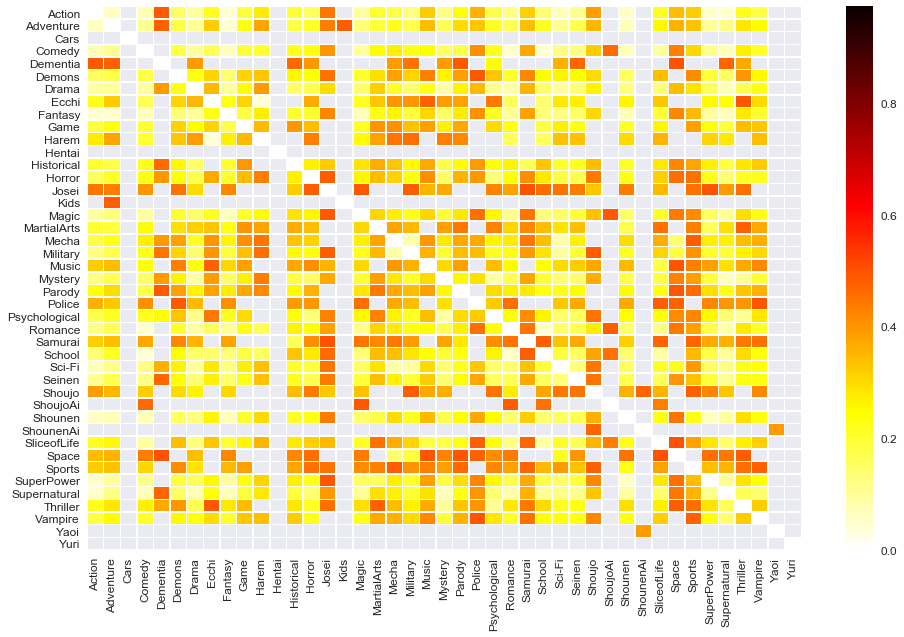

In [108]:
renaming = {x: x.replace('scoreabove8_', '') for x in above8_columns}
genres_users = users[above8_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df  > 0.5] = True

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

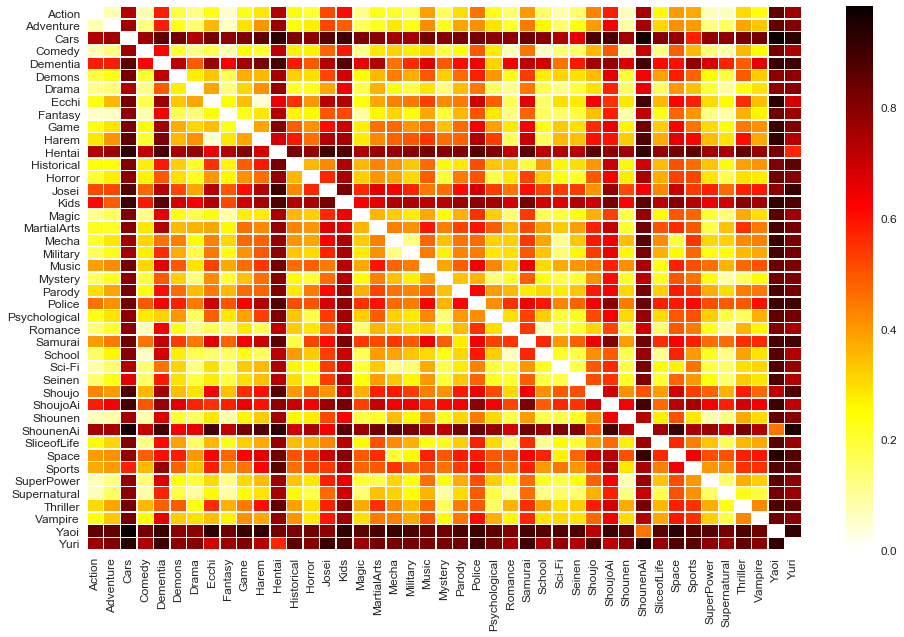

In [109]:
renaming = {x: x.replace('scoreabove9_', '') for x in above9_columns}
genres_users = users[above9_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

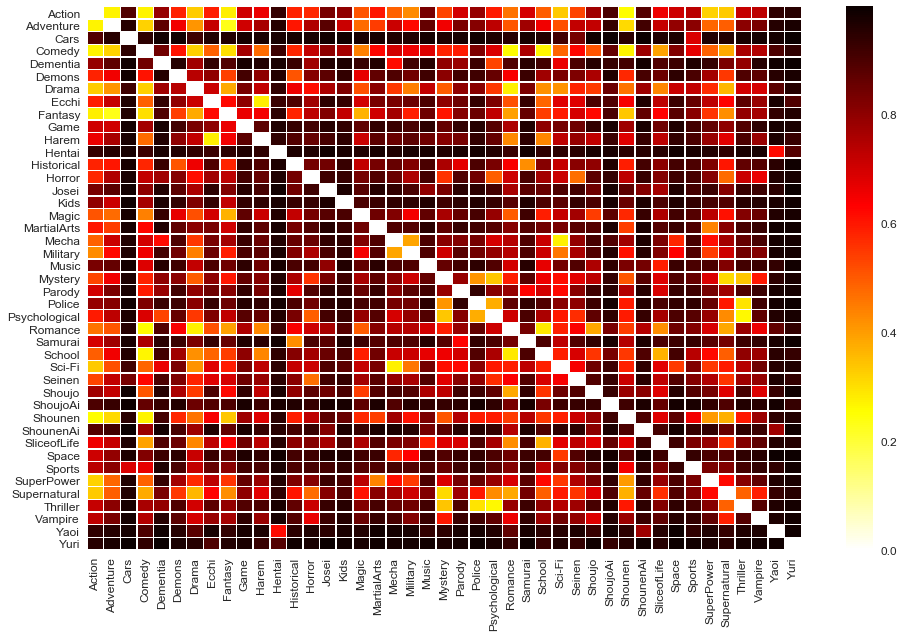

In [110]:
renaming = {x: x.replace('scoreabove9_', '') for x in above9_columns}
genres_users = users[above9_columns].div(users['all_rated'], axis=0).fillna(0).rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

In [111]:
# NSD on 9 or more mean score

renaming = {x: x.replace('meanscore_', '') for x in mean_columns}
genres_users = (users[mean_columns] >= 8.5).rename(columns=renaming).T
# filter out people with no anime rated positively, effectively filtering out zero vectors
genres_users = genres_users[genres_users.columns[genres_users.sum(axis=0) > 0]]
dists = pdist(genres_users, nsd)    # compare with pdist(genres_users, nsd)
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index
dists_df = dists_df.replace(np.inf, 0)
f, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

plt.title('vzdálenost žánrů podle kladně hodnotících uživatelů')
plt.xticks(rotation=80)
plt.ylabel('zastoupení')
plt.xlabel('prvky')
plt.savefig('graphs/uzivatele-zanry-9-a-vice-heatmap.png', bbox_inches="tight")

ValueError: cannot index with vector containing NA / NaN values

In [ ]:
# calculating again dists_df because in the previous, zeros and infinities are mixed up
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True

dists_df_inv = 1 / dists_df
dists_df_inv[dists_df_inv == np.inf] = 0
mask[dists_df_inv < 1.6] = True  # inspect how filtering low similarities will look like

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df_inv, mask=mask, linewidths=.5, cmap=plt.cm.hot)

In [ ]:
# MDS embedding for NSD
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
dists_m[dists_m == np.inf] = 50    # all inputs must be finite, so I have some big distance instead of infinity
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("genres by users similar completed")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

In [ ]:
from sklearn.cluster import KMeans

embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

kmeans = KMeans(init='k-means++', n_clusters=21, n_init=10)
kmeans.fit(embeddings)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .002     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embeddings[:, 0].min() - 0.1, embeddings[:, 0].max() + 0.1
y_min, y_max = embeddings[:, 1].min() - 0.1, embeddings[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.tab20,
           aspect='auto', origin='lower')

plt.scatter(embeddings[:, 0], embeddings[:, 1])
#plt.plot(embeddings[:, 0], embeddings[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
plt.title('K-means clustering on genres based on users')

texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix 
# squareform transfers between condensed and redundant distance form
Z = linkage(squareform(dists_m), 'ward')

# calculate full dendrogram
plt.figure(figsize=(16, 16))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='right',
    labels=dists_df.index
)
plt.show()

In [ ]:
pairs = np.array(list(combinations(genres_users.index, 2)))


# for gephi, higher edge cost means higher similarity
edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': 1/dists})
edges = edges[edges['weight'] != np.inf]

nodes = pd.DataFrame({'id': genres_users.index, 'label': genres_users.index})
edges['type'] = 'undirected'

nodes.to_csv('genres_users_nodes.csv', index=False, sep=',', encoding='utf-8')
edges.to_csv('genres_users_edges_NSD.csv', index=False, sep=',', encoding='utf-8')